In [1]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import warnings
warnings.filterwarnings('ignore')

print("1H-NMR Excel Workbook Analysis - Simplified Version")
print("=" * 55)

# Step 1: Load and examine workbook structure
def load_and_examine_workbook(file_path):
    """
    Load Excel workbook and examine its structure
    """
    print("\n1. WORKBOOK STRUCTURE ANALYSIS")
    print("-" * 50)
    
    try:
        # Load workbook to get sheet names
        wb = load_workbook(file_path, read_only=True)
        sheet_names = wb.sheetnames
        print(f"Number of sheets: {len(sheet_names)}")
        print(f"Sheet names: {sheet_names}")
        
        # Load all sheets into a dictionary
        sheets_data = {}
        for sheet in sheet_names:
            df = pd.read_excel(file_path, sheet_name=sheet)
            sheets_data[sheet] = df
            print(f"\nSheet '{sheet}':")
            print(f"  - Dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
            print(f"  - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            
            # Analyze column types without listing them
            string_cols = len(df.select_dtypes(include=['object']).columns)
            numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
            datetime_cols = len(df.select_dtypes(include=['datetime']).columns)
            
            print(f"  - String columns: {string_cols}")
            print(f"  - Numeric columns: {numeric_cols}")
            print(f"  - DateTime columns: {datetime_cols}")
        
        wb.close()
        return sheets_data
        
    except Exception as e:
        print(f"Error loading workbook: {e}")
        return None

# Step 2: Analyze sample composition (simplified)
def analyze_sample_composition(sheets_data):
    """
    Analyze sample composition from the loaded data (simplified)
    """
    print("\n2. SAMPLE COMPOSITION ANALYSIS")
    print("-" * 50)
    
    for sheet_name, df in sheets_data.items():
        print(f"\nAnalyzing sheet: {sheet_name}")
        
        # Count potential sample identification columns
        sample_cols = [col for col in df.columns if isinstance(col, str) and 
                      any(keyword in col.lower() for keyword in ['sample', 'id', 'name', 'compound', 'substance', 'class'])]
        
        print(f"Sample identification columns found: {len(sample_cols)}")
        
        # Count concentration/quantity columns
        conc_cols = [col for col in df.columns if isinstance(col, str) and 
                    any(keyword in col.lower() for keyword in ['conc', 'concentration', 'amount', 'quantity', 'molarity'])]
        
        print(f"Concentration/quantity columns found: {len(conc_cols)}")
        
        # Basic statistics
        print(f"Total rows: {len(df)}")
        print(f"Non-null rows: {df.dropna().shape[0]}")
        print(f"Duplicate rows: {df.duplicated().sum()}")
        
        # Analyze numeric data ranges
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"Numeric columns: {len(numeric_cols)}")
            print(f"Numeric data range: {df[numeric_cols].min().min():.6f} to {df[numeric_cols].max().max():.6f}")

# Step 3: Assess spectral resolution (simplified)
def assess_spectral_resolution(sheets_data):
    """
    Assess spectral resolution from NMR data (simplified)
    """
    print("\n3. SPECTRAL RESOLUTION ANALYSIS")
    print("-" * 50)
    
    for sheet_name, df in sheets_data.items():
        print(f"\nAnalyzing sheet: {sheet_name}")
        
        # Count potential PPM columns (numeric columns that could be chemical shifts)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        # Assume numeric columns are PPM values if they're in reasonable NMR range
        potential_ppm_cols = []
        for col in numeric_cols:
            if isinstance(col, (int, float)):
                if -5 <= col <= 15:  # Typical 1H-NMR range
                    potential_ppm_cols.append(col)
        
        print(f"Potential PPM columns (numeric headers in NMR range): {len(potential_ppm_cols)}")
        
        if len(potential_ppm_cols) > 0:
            ppm_min = min(potential_ppm_cols)
            ppm_max = max(potential_ppm_cols)
            ppm_range = ppm_max - ppm_min
            resolution = ppm_range / len(potential_ppm_cols) if len(potential_ppm_cols) > 0 else 0
            
            print(f"Chemical shift range: {ppm_min:.4f} to {ppm_max:.4f} ppm")
            print(f"Spectral width: {ppm_range:.4f} ppm")
            print(f"Data points: {len(potential_ppm_cols)}")
            print(f"Resolution: {resolution:.6f} ppm/point")
            
            # Check if range is typical for 1H-NMR
            if ppm_min >= -2 and ppm_max <= 12:
                print("✓ Chemical shift range appropriate for 1H-NMR")
            else:
                print("⚠ Chemical shift range may be outside typical 1H-NMR range")

# Step 4: Identify integrity issues (simplified)
def identify_integrity_issues(sheets_data):
    """
    Identify potential integrity issues in the data (simplified)
    """
    print("\n4. DATA INTEGRITY ANALYSIS")
    print("-" * 50)
    
    issues_found = []
    
    for sheet_name, df in sheets_data.items():
        print(f"\nAnalyzing sheet: {sheet_name}")
        
        # Check for missing values
        total_missing = df.isnull().sum().sum()
        if total_missing > 0:
            missing_percentage = (total_missing / (df.shape[0] * df.shape[1])) * 100
            print(f"⚠ Total missing values: {total_missing} ({missing_percentage:.1f}% of all data)")
            
            # Count columns with high missing data
            high_missing_cols = (df.isnull().sum() / len(df) > 0.5).sum()
            if high_missing_cols > 0:
                print(f"⚠ Columns with >50% missing data: {high_missing_cols}")
                issues_found.append(f"High missing data in {sheet_name}")
        
        # Check for duplicate rows
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            print(f"⚠ Duplicate rows: {duplicates}")
            issues_found.append(f"Duplicate rows in {sheet_name}")
        
        # Check numeric data integrity
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            # Check for infinite values
            infinite_count = np.isinf(df[numeric_cols]).sum().sum()
            if infinite_count > 0:
                print(f"⚠ Infinite values: {infinite_count}")
                issues_found.append(f"Infinite values in {sheet_name}")
            
            # Check for extremely large values
            max_abs_value = df[numeric_cols].abs().max().max()
            if max_abs_value > 1e6:
                print(f"⚠ Extremely large values detected (max: {max_abs_value:.2e})")
                issues_found.append(f"Extremely large values in {sheet_name}")
            
            # Check for negative values in intensity-like data
            negative_count = (df[numeric_cols] < 0).sum().sum()
            if negative_count > 0:
                print(f"⚠ Negative values in numeric data: {negative_count}")
                issues_found.append(f"Negative values in {sheet_name}")
        
        # Data consistency check
        print(f"Data consistency: {df.shape[0] - df.dropna().shape[0]} rows with missing data")
    
    # Summary of integrity issues
    print(f"\n{'='*50}")
    print("INTEGRITY ISSUES SUMMARY")
    print(f"{'='*50}")
    
    if issues_found:
        print(f"Total issues found: {len(issues_found)}")
        for i, issue in enumerate(issues_found, 1):
            print(f"{i}. {issue}")
    else:
        print("✓ No major integrity issues detected")
    
    return issues_found

# Main execution function
def main_analysis(file_path):
    """
    Main function to run the simplified analysis
    """
    print("Starting simplified 1H-NMR Excel Workbook Analysis...")
    print("Focus: Structure, dimensions, composition, resolution, and integrity")
    
    # Load and examine workbook
    sheets_data = load_and_examine_workbook(file_path)
    
    if sheets_data is None:
        print("Failed to load workbook. Please check the file path and try again.")
        return
    
    # Perform analyses
    analyze_sample_composition(sheets_data)
    assess_spectral_resolution(sheets_data)
    integrity_issues = identify_integrity_issues(sheets_data)
    
    # Final summary
    print(f"\n{'='*50}")
    print("FINAL SUMMARY")
    print(f"{'='*50}")
    
    for sheet_name, df in sheets_data.items():
        print(f"\nSheet: {sheet_name}")
        print(f"  Dimensions: {df.shape[0]} samples × {df.shape[1]} variables")
        
        # Identify likely spectral data
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        ppm_cols = [col for col in numeric_cols if isinstance(col, (int, float)) and -5 <= col <= 15]
        
        if len(ppm_cols) > 0:
            print(f"  Spectral data points: {len(ppm_cols)}")
            print(f"  Chemical shift range: {min(ppm_cols):.3f} - {max(ppm_cols):.3f} ppm")
        
        print(f"  Data integrity: {'Good' if sheet_name not in [issue.split(' in ')[1] for issue in integrity_issues] else 'Issues detected'}")
    
    return sheets_data, integrity_issues

# Replace with your actual file path
file_path = 'All_aligned_spectra v3.xlsx'

# Run the analysis
sheets_data, issues = main_analysis(file_path)

1H-NMR Excel Workbook Analysis - Simplified Version
Starting simplified 1H-NMR Excel Workbook Analysis...
Focus: Structure, dimensions, composition, resolution, and integrity

1. WORKBOOK STRUCTURE ANALYSIS
--------------------------------------------------
Number of sheets: 1
Sheet names: ['NMR Oils']

Sheet 'NMR Oils':
  - Dimensions: 66 rows × 1397 columns
  - Memory usage: 0.71 MB
  - String columns: 2
  - Numeric columns: 1395
  - DateTime columns: 0

2. SAMPLE COMPOSITION ANALYSIS
--------------------------------------------------

Analyzing sheet: NMR Oils
Sample identification columns found: 2
Concentration/quantity columns found: 0
Total rows: 66
Non-null rows: 57
Duplicate rows: 0
Numeric columns: 1395
Numeric data range: -3.319420 to 100.000000

3. SPECTRAL RESOLUTION ANALYSIS
--------------------------------------------------

Analyzing sheet: NMR Oils
Potential PPM columns (numeric headers in NMR range): 1395
Chemical shift range: -1.9398 to 12.0000 ppm
Spectral width: 13.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import signal
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

print("NMR Data Preprocessing Pipeline")
print("=" * 40)

class NMRPreprocessor:
    """
    Comprehensive NMR data preprocessing pipeline
    """
    
    def __init__(self):
        self.original_data = None
        self.processed_data = None
        self.preprocessing_steps = []
        self.metadata = {}
        
    def load_data(self, sheets_data, sheet_name='NMR Oils'):
        """
        Load NMR data from the analyzed sheets
        """
        print("\n1. LOADING NMR DATA")
        print("-" * 30)
        
        if sheet_name not in sheets_data:
            print(f"Error: Sheet '{sheet_name}' not found")
            return False
            
        df = sheets_data[sheet_name].copy()
        
        # Separate metadata columns from spectral data
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        string_cols = df.select_dtypes(include=['object']).columns
        
        # Extract spectral data (numeric columns that are likely PPM values)
        spectral_cols = [col for col in numeric_cols if isinstance(col, (int, float)) and -5 <= col <= 15]
        spectral_cols = sorted(spectral_cols)  # Sort by PPM value
        
        self.original_data = df[spectral_cols].copy()
        self.metadata = df[string_cols].copy() if len(string_cols) > 0 else pd.DataFrame()
        
        print(f"✓ Data loaded successfully")
        print(f"  - Samples: {self.original_data.shape[0]}")
        print(f"  - Spectral points: {self.original_data.shape[1]}")
        print(f"  - PPM range: {min(spectral_cols):.3f} to {max(spectral_cols):.3f}")
        print(f"  - Metadata columns: {len(string_cols)}")
        
        # Initial data quality check
        missing_samples = self.original_data.isnull().any(axis=1).sum()
        if missing_samples > 0:
            print(f"  ⚠ Samples with missing data: {missing_samples}")
        
        return True
    
    def handle_missing_data(self, method='interpolate'):
        """
        Handle missing data in NMR spectra
        
        Parameters:
        method: 'interpolate', 'mean', 'median', 'remove'
        """
        print("\n2. HANDLING MISSING DATA")
        print("-" * 30)
        
        if self.original_data is None:
            print("Error: No data loaded")
            return
        
        missing_count = self.original_data.isnull().sum().sum()
        if missing_count == 0:
            print("✓ No missing data detected")
            self.processed_data = self.original_data.copy()
            return
        
        print(f"Missing data points: {missing_count}")
        
        if method == 'interpolate':
            # Linear interpolation across spectral dimension
            self.processed_data = self.original_data.interpolate(axis=1, method='linear')
            print("✓ Applied linear interpolation across spectral dimension")
            
        elif method == 'mean':
            # Fill with column mean
            self.processed_data = self.original_data.fillna(self.original_data.mean())
            print("✓ Filled missing values with column means")
            
        elif method == 'median':
            # Fill with column median
            self.processed_data = self.original_data.fillna(self.original_data.median())
            print("✓ Filled missing values with column medians")
            
        elif method == 'remove':
            # Remove samples with missing data
            self.processed_data = self.original_data.dropna()
            print(f"✓ Removed {self.original_data.shape[0] - self.processed_data.shape[0]} samples with missing data")
        
        self.preprocessing_steps.append(f"Missing data handling: {method}")
        
        # Verify no missing data remains
        remaining_missing = self.processed_data.isnull().sum().sum()
        if remaining_missing > 0:
            print(f"⚠ Warning: {remaining_missing} missing values still remain")
        else:
            print("✓ All missing data successfully handled")
    
    def baseline_correction(self, method='als', lambda_=1e4, p=0.001):
        """
        Apply baseline correction to NMR spectra
        
        Parameters:
        method: 'als' (Asymmetric Least Squares), 'polynomial', 'linear'
        lambda_: smoothness parameter for ALS
        p: asymmetry parameter for ALS
        """
        print("\n3. BASELINE CORRECTION")
        print("-" * 30)
        
        if self.processed_data is None:
            print("Error: No processed data available")
            return
        
        print(f"Applying {method} baseline correction...")
        
        if method == 'als':
            # Asymmetric Least Squares baseline correction
            corrected_data = self.processed_data.copy()
            
            for idx in range(len(corrected_data)):
                spectrum = corrected_data.iloc[idx].values
                baseline = self._als_baseline(spectrum, lambda_, p)
                corrected_data.iloc[idx] = spectrum - baseline
            
            self.processed_data = corrected_data
            print(f"✓ Applied ALS baseline correction (λ={lambda_}, p={p})")
            
        elif method == 'polynomial':
            # Polynomial baseline correction (degree 2)
            corrected_data = self.processed_data.copy()
            
            for idx in range(len(corrected_data)):
                spectrum = corrected_data.iloc[idx].values
                x = np.arange(len(spectrum))
                # Fit polynomial to lower percentile of data
                low_points = spectrum <= np.percentile(spectrum, 10)
                if np.sum(low_points) > 10:
                    coeffs = np.polyfit(x[low_points], spectrum[low_points], 2)
                    baseline = np.polyval(coeffs, x)
                    corrected_data.iloc[idx] = spectrum - baseline
            
            self.processed_data = corrected_data
            print("✓ Applied polynomial baseline correction")
            
        elif method == 'linear':
            # Simple linear baseline correction
            corrected_data = self.processed_data.copy()
            
            for idx in range(len(corrected_data)):
                spectrum = corrected_data.iloc[idx].values
                baseline = np.linspace(spectrum[0], spectrum[-1], len(spectrum))
                corrected_data.iloc[idx] = spectrum - baseline
            
            self.processed_data = corrected_data
            print("✓ Applied linear baseline correction")
        
        self.preprocessing_steps.append(f"Baseline correction: {method}")
        
        # Check for negative values after baseline correction
        negative_count = (self.processed_data < 0).sum().sum()
        print(f"Negative values after baseline correction: {negative_count}")
        
        if negative_count > 0:
            print("Note: Negative values are normal after baseline correction")
    
    def _als_baseline(self, y, lambda_, p, max_iter=10):
        """
        Asymmetric Least Squares baseline correction algorithm
        """
        L = len(y)
        D = np.diff(np.eye(L), 2, axis=0)
        w = np.ones(L)
        
        for _ in range(max_iter):
            W = np.diag(w)
            Z = W + lambda_ * D.T @ D
            z = np.linalg.solve(Z, w * y)
            w = p * (y > z) + (1 - p) * (y < z)
        
        return z
    
    def noise_reduction(self, method='savgol', window_length=5, polyorder=2):
        """
        Apply noise reduction to NMR spectra
        
        Parameters:
        method: 'savgol', 'gaussian', 'median'
        window_length: window size for smoothing
        polyorder: polynomial order for Savitzky-Golay
        """
        print("\n4. NOISE REDUCTION")
        print("-" * 30)
        
        if self.processed_data is None:
            print("Error: No processed data available")
            return
        
        print(f"Applying {method} noise reduction...")
        
        if method == 'savgol':
            # Savitzky-Golay smoothing
            smoothed_data = self.processed_data.copy()
            
            for idx in range(len(smoothed_data)):
                spectrum = smoothed_data.iloc[idx].values
                smoothed = signal.savgol_filter(spectrum, window_length, polyorder)
                smoothed_data.iloc[idx] = smoothed
            
            self.processed_data = smoothed_data
            print(f"✓ Applied Savitzky-Golay smoothing (window={window_length}, order={polyorder})")
            
        elif method == 'gaussian':
            # Gaussian smoothing
            from scipy.ndimage import gaussian_filter1d
            smoothed_data = self.processed_data.copy()
            
            for idx in range(len(smoothed_data)):
                spectrum = smoothed_data.iloc[idx].values
                smoothed = gaussian_filter1d(spectrum, sigma=window_length/3)
                smoothed_data.iloc[idx] = smoothed
            
            self.processed_data = smoothed_data
            print(f"✓ Applied Gaussian smoothing (sigma={window_length/3:.1f})")
            
        elif method == 'median':
            # Median filtering
            smoothed_data = self.processed_data.copy()
            
            for idx in range(len(smoothed_data)):
                spectrum = smoothed_data.iloc[idx].values
                smoothed = signal.medfilt(spectrum, kernel_size=window_length)
                smoothed_data.iloc[idx] = smoothed
            
            self.processed_data = smoothed_data
            print(f"✓ Applied median filtering (kernel={window_length})")
        
        self.preprocessing_steps.append(f"Noise reduction: {method}")
    
    def normalization(self, method='total_area'):
        """
        Apply normalization to NMR spectra
        
        Parameters:
        method: 'total_area', 'max_peak', 'unit_area', 'probabilistic_quotient'
        """
        print("\n5. NORMALIZATION")
        print("-" * 30)
        
        if self.processed_data is None:
            print("Error: No processed data available")
            return
        
        print(f"Applying {method} normalization...")
        
        if method == 'total_area':
            # Total area normalization
            normalized_data = self.processed_data.copy()
            
            for idx in range(len(normalized_data)):
                spectrum = normalized_data.iloc[idx].values
                total_area = np.trapz(np.abs(spectrum))
                if total_area > 0:
                    normalized_data.iloc[idx] = spectrum / total_area
            
            self.processed_data = normalized_data
            print("✓ Applied total area normalization")
            
        elif method == 'max_peak':
            # Maximum peak normalization
            normalized_data = self.processed_data.copy()
            
            for idx in range(len(normalized_data)):
                spectrum = normalized_data.iloc[idx].values
                max_val = np.max(np.abs(spectrum))
                if max_val > 0:
                    normalized_data.iloc[idx] = spectrum / max_val
            
            self.processed_data = normalized_data
            print("✓ Applied maximum peak normalization")
            
        elif method == 'unit_area':
            # Unit area normalization (area = 1)
            normalized_data = self.processed_data.copy()
            
            for idx in range(len(normalized_data)):
                spectrum = normalized_data.iloc[idx].values
                area = np.trapz(spectrum)
                if area > 0:
                    normalized_data.iloc[idx] = spectrum / area
            
            self.processed_data = normalized_data
            print("✓ Applied unit area normalization")
            
        elif method == 'probabilistic_quotient':
            # Probabilistic Quotient Normalization (PQN)
            normalized_data = self.processed_data.copy()
            
            # Calculate reference spectrum (median)
            reference = normalized_data.median()
            
            for idx in range(len(normalized_data)):
                spectrum = normalized_data.iloc[idx].values
                quotients = spectrum / reference
                quotients = quotients[~np.isnan(quotients) & ~np.isinf(quotients)]
                if len(quotients) > 0:
                    median_quotient = np.median(quotients)
                    if median_quotient > 0:
                        normalized_data.iloc[idx] = spectrum / median_quotient
            
            self.processed_data = normalized_data
            print("✓ Applied Probabilistic Quotient Normalization")
        
        self.preprocessing_steps.append(f"Normalization: {method}")
        
        # Check normalization results
        areas = []
        for idx in range(len(self.processed_data)):
            spectrum = self.processed_data.iloc[idx].values
            area = np.trapz(np.abs(spectrum))
            areas.append(area)
        
        print(f"Normalized areas - Mean: {np.mean(areas):.4f}, Std: {np.std(areas):.4f}")
    
    def scaling(self, method='standard'):
        """
        Apply scaling to NMR data
        
        Parameters:
        method: 'standard', 'minmax', 'robust', 'unit_variance'
        """
        print("\n6. SCALING")
        print("-" * 30)
        
        if self.processed_data is None:
            print("Error: No processed data available")
            return
        
        print(f"Applying {method} scaling...")
        
        if method == 'standard':
            # Standard scaling (z-score normalization)
            scaler = StandardScaler()
            scaled_data = pd.DataFrame(
                scaler.fit_transform(self.processed_data.T).T,
                columns=self.processed_data.columns,
                index=self.processed_data.index
            )
            print("✓ Applied standard scaling (z-score)")
            
        elif method == 'minmax':
            # Min-max scaling
            scaler = MinMaxScaler()
            scaled_data = pd.DataFrame(
                scaler.fit_transform(self.processed_data.T).T,
                columns=self.processed_data.columns,
                index=self.processed_data.index
            )
            print("✓ Applied min-max scaling")
            
        elif method == 'robust':
            # Robust scaling (using median and IQR)
            scaler = RobustScaler()
            scaled_data = pd.DataFrame(
                scaler.fit_transform(self.processed_data.T).T,
                columns=self.processed_data.columns,
                index=self.processed_data.index
            )
            print("✓ Applied robust scaling")
            
        elif method == 'unit_variance':
            # Unit variance scaling
            scaled_data = self.processed_data.copy()
            
            for col in scaled_data.columns:
                col_std = scaled_data[col].std()
                if col_std > 0:
                    scaled_data[col] = scaled_data[col] / col_std
            
            print("✓ Applied unit variance scaling")
        
        self.processed_data = scaled_data
        self.preprocessing_steps.append(f"Scaling: {method}")
        
        # Check scaling results
        print(f"Scaled data - Mean: {self.processed_data.mean().mean():.4f}, Std: {self.processed_data.std().mean():.4f}")
    
    def region_selection(self, exclude_regions=None):
        """
        Select specific regions of the NMR spectrum
        
        Parameters:
        exclude_regions: list of tuples [(start_ppm, end_ppm), ...] to exclude
        """
        print("\n7. REGION SELECTION")
        print("-" * 30)
        
        if self.processed_data is None:
            print("Error: No processed data available")
            return
        
        original_cols = len(self.processed_data.columns)
        
        if exclude_regions is None:
            # Default: exclude water region (4.5-5.0 ppm) and solvent regions
            exclude_regions = [(4.5, 5.0)]  # Water region
            print("Using default exclusion: water region (4.5-5.0 ppm)")
        
        # Convert column names to float and filter
        selected_cols = []
        for col in self.processed_data.columns:
            ppm_val = float(col)
            exclude = False
            
            for start, end in exclude_regions:
                if start <= ppm_val <= end:
                    exclude = True
                    break
            
            if not exclude:
                selected_cols.append(col)
        
        self.processed_data = self.processed_data[selected_cols]
        
        excluded_count = original_cols - len(selected_cols)
        print(f"✓ Excluded {excluded_count} data points from {len(exclude_regions)} regions")
        print(f"  Remaining spectral points: {len(selected_cols)}")
        
        self.preprocessing_steps.append(f"Region selection: excluded {len(exclude_regions)} regions")
    
    def get_summary(self):
        """
        Get summary of preprocessing steps and data characteristics
        """
        print("\n" + "="*50)
        print("PREPROCESSING SUMMARY")
        print("="*50)
        
        if self.original_data is not None and self.processed_data is not None:
            print(f"Original data shape: {self.original_data.shape}")
            print(f"Processed data shape: {self.processed_data.shape}")
            
            print(f"\nData characteristics:")
            print(f"  - Mean: {self.processed_data.mean().mean():.4f}")
            print(f"  - Std: {self.processed_data.std().mean():.4f}")
            print(f"  - Min: {self.processed_data.min().min():.4f}")
            print(f"  - Max: {self.processed_data.max().max():.4f}")
            
            print(f"\nPreprocessing steps applied:")
            for i, step in enumerate(self.preprocessing_steps, 1):
                print(f"  {i}. {step}")
        
        return self.processed_data

# Example usage and recommended preprocessing pipeline
def run_preprocessing_pipeline(sheets_data):
    """
    Run the complete preprocessing pipeline with recommended settings
    """
    print("Running recommended NMR preprocessing pipeline...")
    
    # Initialize preprocessor
    preprocessor = NMRPreprocessor()
    
    # Load data
    if not preprocessor.load_data(sheets_data):
        return None
    
    # Apply preprocessing steps
    preprocessor.handle_missing_data(method='interpolate')
    preprocessor.baseline_correction(method='als', lambda_=1e4)
    preprocessor.noise_reduction(method='savgol', window_length=5)
    preprocessor.normalization(method='total_area')
    preprocessor.region_selection(exclude_regions=[(4.5, 5.0)])  # Exclude water
    preprocessor.scaling(method='standard')
    
    # Get summary
    processed_data = preprocessor.get_summary()
    
    return processed_data, preprocessor

# Instructions for use
print("\nINSTRUCTIONS:")
print("1. Use the sheets_data from the previous analysis")
print("2. Run: processed_data, preprocessor = run_preprocessing_pipeline(sheets_data)")
print("3. The processed_data will be ready for further analysis")

# Example call (uncomment to run)
processed_data, preprocessor = run_preprocessing_pipeline(sheets_data)

NMR Data Preprocessing Pipeline

INSTRUCTIONS:
1. Use the sheets_data from the previous analysis
2. Run: processed_data, preprocessor = run_preprocessing_pipeline(sheets_data)
3. The processed_data will be ready for further analysis
Running recommended NMR preprocessing pipeline...

1. LOADING NMR DATA
------------------------------
✓ Data loaded successfully
  - Samples: 66
  - Spectral points: 1395
  - PPM range: -1.940 to 12.000
  - Metadata columns: 2

2. HANDLING MISSING DATA
------------------------------
✓ No missing data detected

3. BASELINE CORRECTION
------------------------------
Applying als baseline correction...
✓ Applied ALS baseline correction (λ=10000.0, p=0.001)
Negative values after baseline correction: 3796
Note: Negative values are normal after baseline correction

4. NOISE REDUCTION
------------------------------
Applying savgol noise reduction...
✓ Applied Savitzky-Golay smoothing (window=5, order=2)

5. NORMALIZATION
------------------------------
Applying tota


INSTRUCTIONS:
1. Ensure you have the processed_data and preprocessor from the previous step
2. Run: eda_analyzer = run_eda_analysis(processed_data, preprocessor)
3. The analysis will generate comprehensive statistics and visualizations
4. Access detailed results via the returned eda_analyzer object
Starting comprehensive exploratory data analysis...
Debugging: preprocessed_data keys: Not a dict
✓ Extracted spectral data from preprocessor.processed_data (DataFrame)
✓ Loaded preprocessed data: 66 samples, 1345 variables

EXPLORATORY DATA ANALYSIS SUMMARY REPORT

BASIC STATISTICAL ANALYSIS

Dataset Overview:
• Samples: 66
• Variables (chemical shifts): 1345
• Missing values: 0

Spectral Intensity Statistics:
• Mean intensity: 0.000000
• Standard deviation: 1.000000
• Range: [-0.277275, 15.812230]
• Median: -0.175064

Sample Variability:
• Mean CV across samples: -503460208876618496.00%
• Sample intensity range: [-0.000000, 0.000000]

Spectral Region Analysis:
• Average signal variance: 0

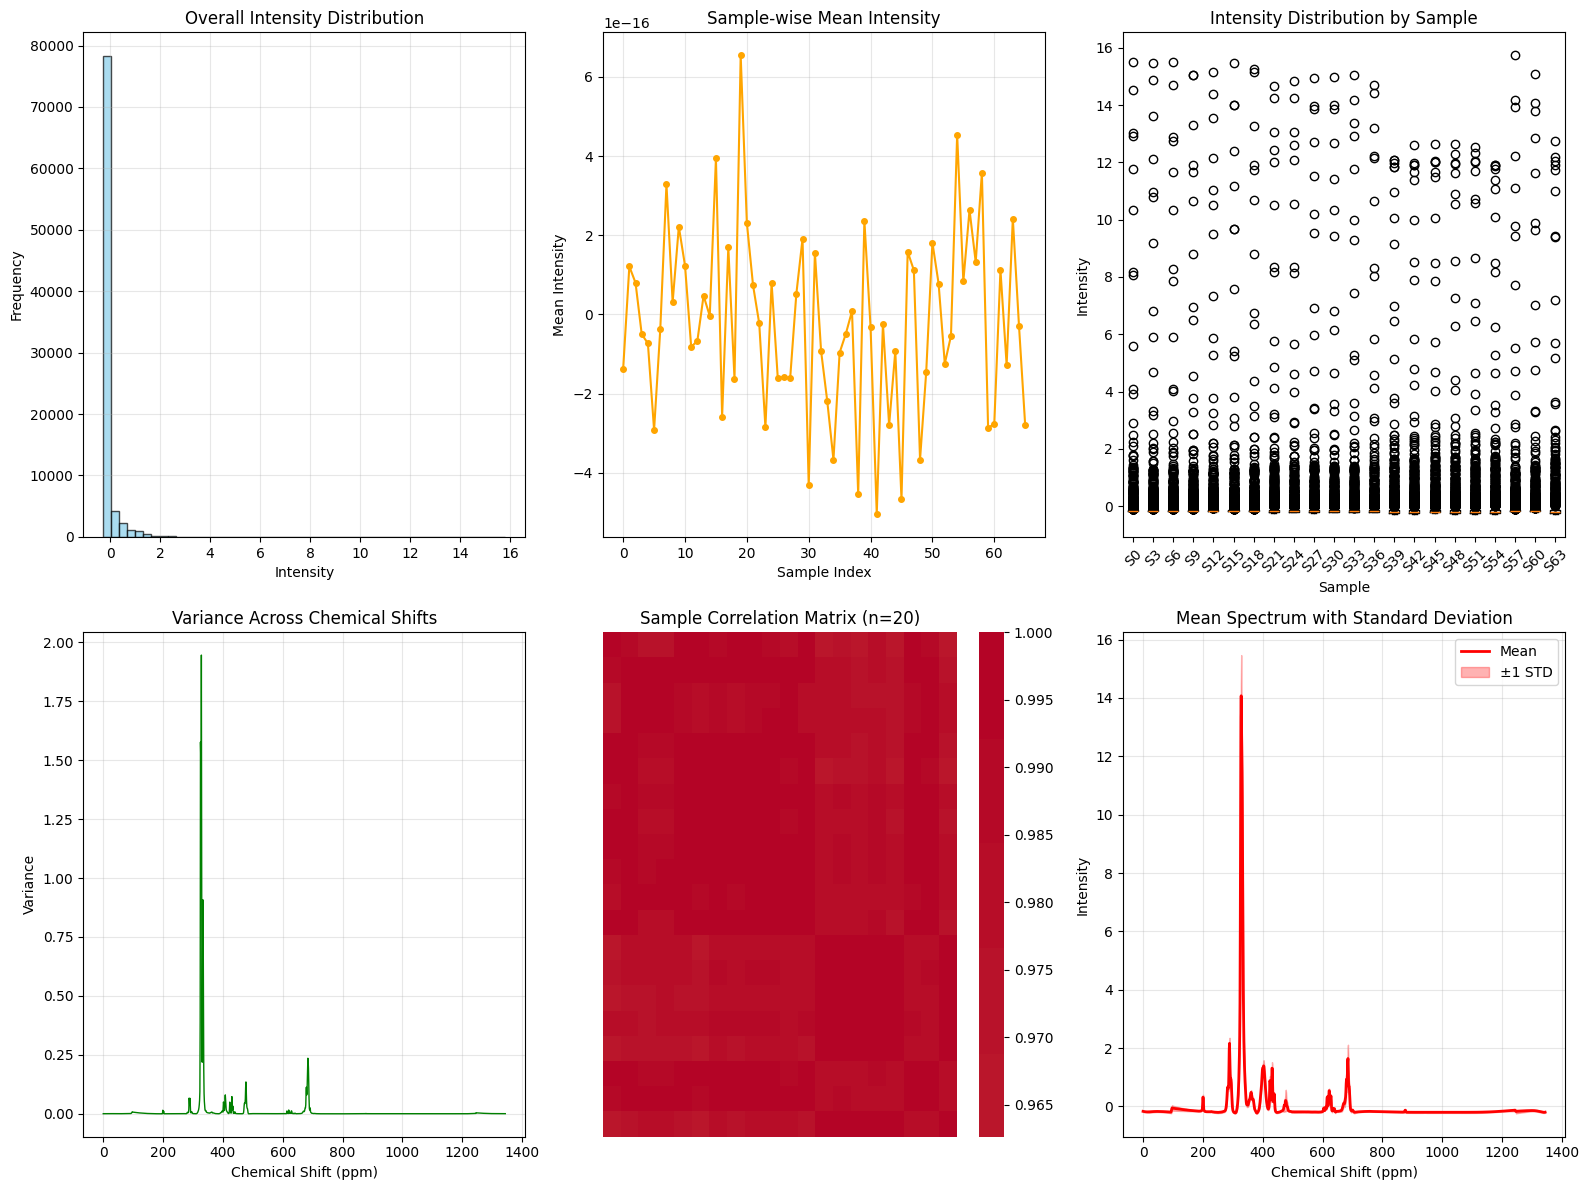


OUTLIER DETECTION
Outlier Detection Results (ZSCORE):
• Outlier samples: 0 (0.0%)
• Outlier variables: 10 (0.7%)

DIMENSIONALITY ANALYSIS (PCA)
PCA Results:
• Number of components: 5
• PC1: 0.583 (58.3%) - Cumulative: 0.583 (58.3%)
• PC2: 0.307 (30.7%) - Cumulative: 0.890 (89.0%)
• PC3: 0.068 (6.8%) - Cumulative: 0.958 (95.8%)
• PC4: 0.018 (1.8%) - Cumulative: 0.976 (97.6%)
• PC5: 0.010 (1.0%) - Cumulative: 0.986 (98.6%)


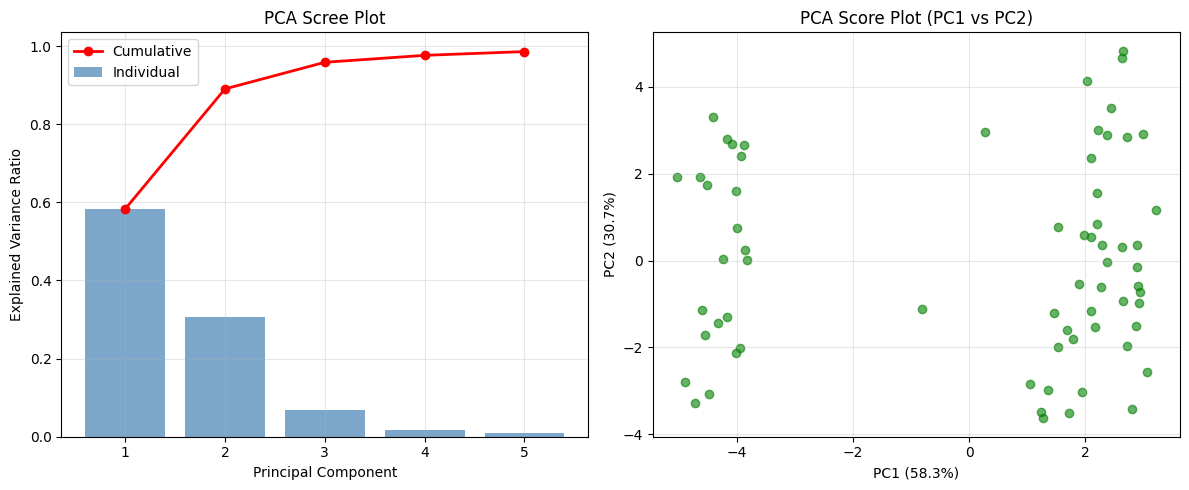


SPECTRAL REGION ANALYSIS

KEY FINDINGS:
• Dataset contains 66 samples with 1345 variables
• Data quality: 0 missing values, 0 outlier samples
• Signal characteristics: S/N ratio ≈ -0.00
• Sample variability: Mean CV = -503460208876618496.00%
• Dimensionality: PC1 explains 58.3% variance, PC1+PC2 explain 89.0%

EDA ANALYSIS COMPLETE
The EDA analyzer object contains all results and can be used for further analysis.
Access results via: eda_analyzer.statistics, eda_analyzer.findings, etc.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class NMRExploratoryAnalysis:
    """
    Comprehensive exploratory data analysis for NMR spectroscopy data
    """
    
    def __init__(self, preprocessed_data, preprocessor):
        """
        Initialize EDA with preprocessed data
        
        Parameters:
        preprocessed_data: dict containing processed NMR data
        preprocessor: NMRPreprocessor object with processing history
        """
        self.preprocessed_data = preprocessed_data
        self.preprocessor = preprocessor
        self.spectral_data = None
        self.metadata = None
        self.statistics = {}
        self.load_processed_data()
    
    def load_processed_data(self):
        """Load and organize the preprocessed data"""
        try:
            print("Debugging: preprocessed_data keys:", list(self.preprocessed_data.keys()) if isinstance(self.preprocessed_data, dict) else "Not a dict")
            
            # Try different possible keys for spectral data
            possible_keys = ['processed_spectra', 'processed_data', 'data', 'spectral_data', 'spectra']
            
            self.spectral_data = None
            for key in possible_keys:
                if key in self.preprocessed_data:
                    data = self.preprocessed_data[key]
                    if isinstance(data, np.ndarray) and data.ndim == 2:
                        self.spectral_data = data
                        print(f"✓ Found spectral data in key: '{key}'")
                        break
                    elif isinstance(data, pd.DataFrame):
                        self.spectral_data = data.values
                        print(f"✓ Found spectral data in key: '{key}' (converted from DataFrame)")
                        break
            
            # If still not found, try to extract from preprocessor
            if self.spectral_data is None and hasattr(self.preprocessor, 'processed_data'):
                if isinstance(self.preprocessor.processed_data, np.ndarray):
                    self.spectral_data = self.preprocessor.processed_data
                    print("✓ Extracted spectral data from preprocessor.processed_data")
                elif isinstance(self.preprocessor.processed_data, pd.DataFrame):
                    self.spectral_data = self.preprocessor.processed_data.values
                    print("✓ Extracted spectral data from preprocessor.processed_data (DataFrame)")
            
            # Last resort: try to find any 2D numpy array in the data
            if self.spectral_data is None:
                for key, value in self.preprocessed_data.items():
                    if isinstance(value, np.ndarray) and value.ndim == 2:
                        self.spectral_data = value
                        print(f"✓ Found 2D array in key: '{key}'")
                        break
                    elif isinstance(value, pd.DataFrame):
                        self.spectral_data = value.values
                        print(f"✓ Found DataFrame in key: '{key}', converted to array")
                        break
            
            if self.spectral_data is None:
                print("✗ Could not find spectral data in any expected format")
                print("Available keys:", list(self.preprocessed_data.keys()) if isinstance(self.preprocessed_data, dict) else "Not a dict")
                return False
            
            # Extract metadata if available
            if 'metadata' in self.preprocessed_data:
                self.metadata = self.preprocessed_data['metadata']
            
            # Get chemical shift information
            self.chemical_shifts = self.preprocessed_data.get('chemical_shifts', 
                                                           np.arange(self.spectral_data.shape[1]))
            
            print(f"✓ Loaded preprocessed data: {self.spectral_data.shape[0]} samples, {self.spectral_data.shape[1]} variables")
            
        except Exception as e:
            print(f"✗ Error loading preprocessed data: {e}")
            print("preprocessed_data type:", type(self.preprocessed_data))
            if hasattr(self.preprocessed_data, 'keys'):
                print("Available keys:", list(self.preprocessed_data.keys()))
            return False
        
        return True
    
    def calculate_basic_statistics(self):
        """Calculate comprehensive statistical measures"""
        print("\n" + "="*50)
        print("BASIC STATISTICAL ANALYSIS")
        print("="*50)
        
        if self.spectral_data is None:
            print("✗ No spectral data available for analysis")
            return None
        
        # Overall dataset statistics
        self.statistics['dataset'] = {
            'n_samples': self.spectral_data.shape[0],
            'n_variables': self.spectral_data.shape[1],
            'total_data_points': self.spectral_data.size,
            'missing_values': np.sum(np.isnan(self.spectral_data)) if np.any(np.isnan(self.spectral_data)) else 0
        }
        
        # Spectral intensity statistics
        self.statistics['intensity'] = {
            'global_mean': np.mean(self.spectral_data),
            'global_std': np.std(self.spectral_data),
            'global_median': np.median(self.spectral_data),
            'global_min': np.min(self.spectral_data),
            'global_max': np.max(self.spectral_data),
            'global_range': np.ptp(self.spectral_data),
            'global_variance': np.var(self.spectral_data)
        }
        
        # Per-sample statistics
        sample_means = np.mean(self.spectral_data, axis=1)
        sample_stds = np.std(self.spectral_data, axis=1)
        
        self.statistics['per_sample'] = {
            'mean_intensity_range': (np.min(sample_means), np.max(sample_means)),
            'std_intensity_range': (np.min(sample_stds), np.max(sample_stds)),
            'cv_mean': np.mean(sample_stds / sample_means) * 100,  # Coefficient of variation
            'sample_correlation_mean': np.mean(np.corrcoef(self.spectral_data))
        }
        
        # Per-variable (chemical shift) statistics
        variable_means = np.mean(self.spectral_data, axis=0)
        variable_stds = np.std(self.spectral_data, axis=0)
        
        self.statistics['per_variable'] = {
            'most_variable_regions': np.argsort(variable_stds)[-10:],  # Top 10 most variable
            'least_variable_regions': np.argsort(variable_stds)[:10],   # Top 10 least variable
            'mean_signal_variance': np.mean(variable_stds),
            'signal_to_noise_estimate': np.mean(variable_means) / np.mean(variable_stds)
        }
        
        # Print summary
        self.print_statistical_summary()
        
        return self.statistics
    
    def print_statistical_summary(self):
        """Print formatted statistical summary"""
        print(f"\nDataset Overview:")
        print(f"• Samples: {self.statistics['dataset']['n_samples']}")
        print(f"• Variables (chemical shifts): {self.statistics['dataset']['n_variables']}")
        print(f"• Missing values: {self.statistics['dataset']['missing_values']}")
        
        print(f"\nSpectral Intensity Statistics:")
        print(f"• Mean intensity: {self.statistics['intensity']['global_mean']:.6f}")
        print(f"• Standard deviation: {self.statistics['intensity']['global_std']:.6f}")
        print(f"• Range: [{self.statistics['intensity']['global_min']:.6f}, {self.statistics['intensity']['global_max']:.6f}]")
        print(f"• Median: {self.statistics['intensity']['global_median']:.6f}")
        
        print(f"\nSample Variability:")
        print(f"• Mean CV across samples: {self.statistics['per_sample']['cv_mean']:.2f}%")
        print(f"• Sample intensity range: [{self.statistics['per_sample']['mean_intensity_range'][0]:.6f}, {self.statistics['per_sample']['mean_intensity_range'][1]:.6f}]")
        
        print(f"\nSpectral Region Analysis:")
        print(f"• Average signal variance: {self.statistics['per_variable']['mean_signal_variance']:.6f}")
        print(f"• Estimated S/N ratio: {self.statistics['per_variable']['signal_to_noise_estimate']:.2f}")
    
    def visualize_data_distribution(self):
        """Create comprehensive visualizations of data distribution"""
        print("\n" + "="*50)
        print("DATA DISTRIBUTION VISUALIZATION")
        print("="*50)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Overall intensity distribution
        plt.subplot(2, 3, 1)
        plt.hist(self.spectral_data.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        plt.title('Overall Intensity Distribution')
        plt.grid(True, alpha=0.3)
        
        # 2. Sample-wise mean intensity
        plt.subplot(2, 3, 2)
        sample_means = np.mean(self.spectral_data, axis=1)
        plt.plot(sample_means, 'o-', color='orange', markersize=4)
        plt.xlabel('Sample Index')
        plt.ylabel('Mean Intensity')
        plt.title('Sample-wise Mean Intensity')
        plt.grid(True, alpha=0.3)
        
        # 3. Boxplot of sample intensities
        plt.subplot(2, 3, 3)
        # Sample every 10th sample for clarity if too many samples
        sample_step = max(1, self.spectral_data.shape[0] // 20)
        sample_indices = range(0, self.spectral_data.shape[0], sample_step)
        boxplot_data = [self.spectral_data[i, :] for i in sample_indices]
        plt.boxplot(boxplot_data, labels=[f'S{i}' for i in sample_indices])
        plt.xlabel('Sample')
        plt.ylabel('Intensity')
        plt.title('Intensity Distribution by Sample')
        plt.xticks(rotation=45)
        
        # 4. Variance across chemical shifts
        plt.subplot(2, 3, 4)
        variable_vars = np.var(self.spectral_data, axis=0)
        plt.plot(self.chemical_shifts, variable_vars, color='green', linewidth=1)
        plt.xlabel('Chemical Shift (ppm)')
        plt.ylabel('Variance')
        plt.title('Variance Across Chemical Shifts')
        plt.grid(True, alpha=0.3)
        
        # 5. Correlation heatmap (sample subset)
        plt.subplot(2, 3, 5)
        # Use subset of samples for correlation matrix if too many
        n_samples_corr = min(20, self.spectral_data.shape[0])
        sample_indices_corr = np.linspace(0, self.spectral_data.shape[0]-1, n_samples_corr, dtype=int)
        corr_matrix = np.corrcoef(self.spectral_data[sample_indices_corr, :])
        
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
                   xticklabels=False, yticklabels=False, cbar=True)
        plt.title(f'Sample Correlation Matrix (n={n_samples_corr})')
        
        # 6. Mean spectrum with error bars
        plt.subplot(2, 3, 6)
        mean_spectrum = np.mean(self.spectral_data, axis=0)
        std_spectrum = np.std(self.spectral_data, axis=0)
        
        plt.plot(self.chemical_shifts, mean_spectrum, color='red', linewidth=2, label='Mean')
        plt.fill_between(self.chemical_shifts, 
                        mean_spectrum - std_spectrum, 
                        mean_spectrum + std_spectrum, 
                        alpha=0.3, color='red', label='±1 STD')
        plt.xlabel('Chemical Shift (ppm)')
        plt.ylabel('Intensity')
        plt.title('Mean Spectrum with Standard Deviation')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def detect_outliers(self, method='zscore', threshold=3):
        """Detect outlier samples and variables"""
        print("\n" + "="*50)
        print("OUTLIER DETECTION")
        print("="*50)
        
        outliers = {'samples': [], 'variables': []}
        
        # Sample outliers based on overall intensity
        if method == 'zscore':
            sample_means = np.mean(self.spectral_data, axis=1)
            z_scores = np.abs(stats.zscore(sample_means))
            outlier_samples = np.where(z_scores > threshold)[0]
            
            # Variable outliers based on variance
            variable_vars = np.var(self.spectral_data, axis=0)
            var_z_scores = np.abs(stats.zscore(variable_vars))
            outlier_variables = np.where(var_z_scores > threshold)[0]
            
        elif method == 'iqr':
            # IQR method for samples
            sample_means = np.mean(self.spectral_data, axis=1)
            Q1, Q3 = np.percentile(sample_means, [25, 75])
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_samples = np.where((sample_means < lower_bound) | (sample_means > upper_bound))[0]
            
            # IQR method for variables
            variable_vars = np.var(self.spectral_data, axis=0)
            Q1_var, Q3_var = np.percentile(variable_vars, [25, 75])
            IQR_var = Q3_var - Q1_var
            lower_bound_var = Q1_var - 1.5 * IQR_var
            upper_bound_var = Q3_var + 1.5 * IQR_var
            outlier_variables = np.where((variable_vars < lower_bound_var) | (variable_vars > upper_bound_var))[0]
        
        outliers['samples'] = outlier_samples
        outliers['variables'] = outlier_variables
        
        print(f"Outlier Detection Results ({method.upper()}):")
        print(f"• Outlier samples: {len(outlier_samples)} ({len(outlier_samples)/self.spectral_data.shape[0]*100:.1f}%)")
        print(f"• Outlier variables: {len(outlier_variables)} ({len(outlier_variables)/self.spectral_data.shape[1]*100:.1f}%)")
        
        if len(outlier_samples) > 0:
            print(f"• Sample outlier indices: {outlier_samples[:10]}{'...' if len(outlier_samples) > 10 else ''}")
        
        return outliers
    
    def perform_dimensionality_analysis(self, n_components=5):
        """Perform PCA and analyze dimensionality"""
        print("\n" + "="*50)
        print("DIMENSIONALITY ANALYSIS (PCA)")
        print("="*50)
        
        # Perform PCA
        pca = PCA(n_components=min(n_components, min(self.spectral_data.shape)))
        pca_result = pca.fit_transform(self.spectral_data)
        
        # Calculate cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        
        # Results
        pca_results = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'cumulative_variance': cumulative_variance,
            'components': pca.components_,
            'transformed_data': pca_result
        }
        
        print(f"PCA Results:")
        print(f"• Number of components: {len(pca.explained_variance_ratio_)}")
        for i, (var, cum_var) in enumerate(zip(pca.explained_variance_ratio_, cumulative_variance)):
            print(f"• PC{i+1}: {var:.3f} ({var*100:.1f}%) - Cumulative: {cum_var:.3f} ({cum_var*100:.1f}%)")
        
        # Visualize PCA results
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Scree plot
        axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 
                   alpha=0.7, color='steelblue')
        axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
                    'ro-', color='red', linewidth=2)
        axes[0].set_xlabel('Principal Component')
        axes[0].set_ylabel('Explained Variance Ratio')
        axes[0].set_title('PCA Scree Plot')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(['Cumulative', 'Individual'])
        
        # PC1 vs PC2 scatter
        axes[1].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, color='green')
        axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        axes[1].set_title('PCA Score Plot (PC1 vs PC2)')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return pca_results
    
    def analyze_spectral_regions(self, regions=None):
        """Analyze specific spectral regions of interest"""
        print("\n" + "="*50)
        print("SPECTRAL REGION ANALYSIS")
        print("="*50)
        
        if regions is None:
            # Define common NMR regions (in ppm)
            regions = {
                'Aromatic': (6.0, 8.5),
                'Aliphatic': (0.5, 4.5),
                'Carbohydrate': (3.0, 5.5),
                'Fatty acids': (0.5, 3.0)
            }
        
        region_stats = {}
        
        for region_name, (start, end) in regions.items():
            # Find indices corresponding to chemical shift range
            if hasattr(self, 'chemical_shifts') and len(self.chemical_shifts) == self.spectral_data.shape[1]:
                # Assuming chemical shifts are in descending order (typical for NMR)
                start_idx = np.searchsorted(self.chemical_shifts[::-1], start)
                end_idx = np.searchsorted(self.chemical_shifts[::-1], end)
                
                if start_idx < end_idx:
                    # Extract region data
                    region_data = self.spectral_data[:, -(end_idx):-(start_idx) if start_idx > 0 else None]
                    
                    region_stats[region_name] = {
                        'mean_intensity': np.mean(region_data),
                        'total_area': np.sum(region_data, axis=1),
                        'max_intensity': np.max(region_data),
                        'variance': np.var(region_data),
                        'range': (start, end),
                        'n_points': region_data.shape[1]
                    }
                    
                    print(f"{region_name} region ({start}-{end} ppm):")
                    print(f"  • Mean intensity: {region_stats[region_name]['mean_intensity']:.6f}")
                    print(f"  • Max intensity: {region_stats[region_name]['max_intensity']:.6f}")
                    print(f"  • Variance: {region_stats[region_name]['variance']:.6f}")
                    print(f"  • Data points: {region_stats[region_name]['n_points']}")
        
        return region_stats
    
    def generate_eda_report(self):
        """Generate comprehensive EDA report"""
        print("\n" + "="*60)
        print("EXPLORATORY DATA ANALYSIS SUMMARY REPORT")
        print("="*60)
        
        if self.spectral_data is None:
            print("✗ Cannot generate EDA report: No spectral data available")
            return None
        
        # Run all analyses
        stats = self.calculate_basic_statistics()
        if stats is None:
            return None
            
        self.visualize_data_distribution()
        outliers = self.detect_outliers()
        pca_results = self.perform_dimensionality_analysis()
        region_stats = self.analyze_spectral_regions()
        
        # Compile findings
        findings = {
            'data_quality': {
                'missing_values': stats['dataset']['missing_values'],
                'outlier_samples': len(outliers['samples']),
                'outlier_variables': len(outliers['variables'])
            },
            'spectral_characteristics': {
                'signal_to_noise': stats['per_variable']['signal_to_noise_estimate'],
                'mean_cv': stats['per_sample']['cv_mean'],
                'intensity_range': stats['intensity']['global_range']
            },
            'dimensionality': {
                'pc1_variance': pca_results['explained_variance_ratio'][0],
                'pc2_variance': pca_results['explained_variance_ratio'][1],
                'cumulative_pc2': pca_results['cumulative_variance'][1]
            },
            'preprocessing_applied': self.preprocessor.get_processing_steps() if hasattr(self.preprocessor, 'get_processing_steps') else 'Standard pipeline'
        }
        
        print("\nKEY FINDINGS:")
        print(f"• Dataset contains {stats['dataset']['n_samples']} samples with {stats['dataset']['n_variables']} variables")
        print(f"• Data quality: {findings['data_quality']['missing_values']} missing values, {findings['data_quality']['outlier_samples']} outlier samples")
        print(f"• Signal characteristics: S/N ratio ≈ {findings['spectral_characteristics']['signal_to_noise']:.2f}")
        print(f"• Sample variability: Mean CV = {findings['spectral_characteristics']['mean_cv']:.2f}%")
        print(f"• Dimensionality: PC1 explains {findings['dimensionality']['pc1_variance']*100:.1f}% variance, PC1+PC2 explain {findings['dimensionality']['cumulative_pc2']*100:.1f}%")
        
        return findings

# Main execution function
def run_eda_analysis(processed_data, preprocessor):
    """
    Run complete exploratory data analysis
    
    Parameters:
    processed_data: dict containing processed NMR data
    preprocessor: NMRPreprocessor object
    
    Returns:
    eda_analyzer: NMRExploratoryAnalysis object with all results
    """
    print("Starting comprehensive exploratory data analysis...")
    
    # Initialize EDA analyzer
    eda_analyzer = NMRExploratoryAnalysis(processed_data, preprocessor)
    
    # Generate complete report
    findings = eda_analyzer.generate_eda_report()
    
    print("\n" + "="*60)
    print("EDA ANALYSIS COMPLETE")
    print("="*60)
    print("The EDA analyzer object contains all results and can be used for further analysis.")
    print("Access results via: eda_analyzer.statistics, eda_analyzer.findings, etc.")
    
    return eda_analyzer

# Instructions for use
print("\nINSTRUCTIONS:")
print("1. Ensure you have the processed_data and preprocessor from the previous step")
print("2. Run: eda_analyzer = run_eda_analysis(processed_data, preprocessor)")
print("3. The analysis will generate comprehensive statistics and visualizations")
print("4. Access detailed results via the returned eda_analyzer object")

# Example call (uncomment to run)
eda_analyzer = run_eda_analysis(processed_data, preprocessor)

✓ Initialized unsupervised analysis for 66 samples with 1345 variables

UNSUPERVISED ANALYSIS COMPREHENSIVE REPORT

ADVANCED PRINCIPAL COMPONENT ANALYSIS
Auto-selected 3 components to explain 95.0% variance

PCA Summary:
• Components retained: 3
• Cumulative variance explained: 95.84%
• Most informative components:
  - PC1: 58.30% variance
  - PC2: 30.73% variance
  - PC3: 6.82% variance

PCA Loadings Interpretation:

PC1 (explains 58.30% variance):
• Most influential spectral regions:
  - Region 328: 0.4443
  - Region 329: 0.2824
  - Region 327: 0.2709
  - Region 334: -0.2331
  - Region 333: -0.2288
• Positive contribution regions: 3
• Negative contribution regions: 16

PC2 (explains 30.73% variance):
• Most influential spectral regions:
  - Region 326: 0.5339
  - Region 325: 0.4730
  - Region 333: -0.2748
  - Region 327: 0.2699
  - Region 332: -0.2418
• Positive contribution regions: 4
• Negative contribution regions: 7

PC3 (explains 6.82% variance):
• Most influential spectral regi

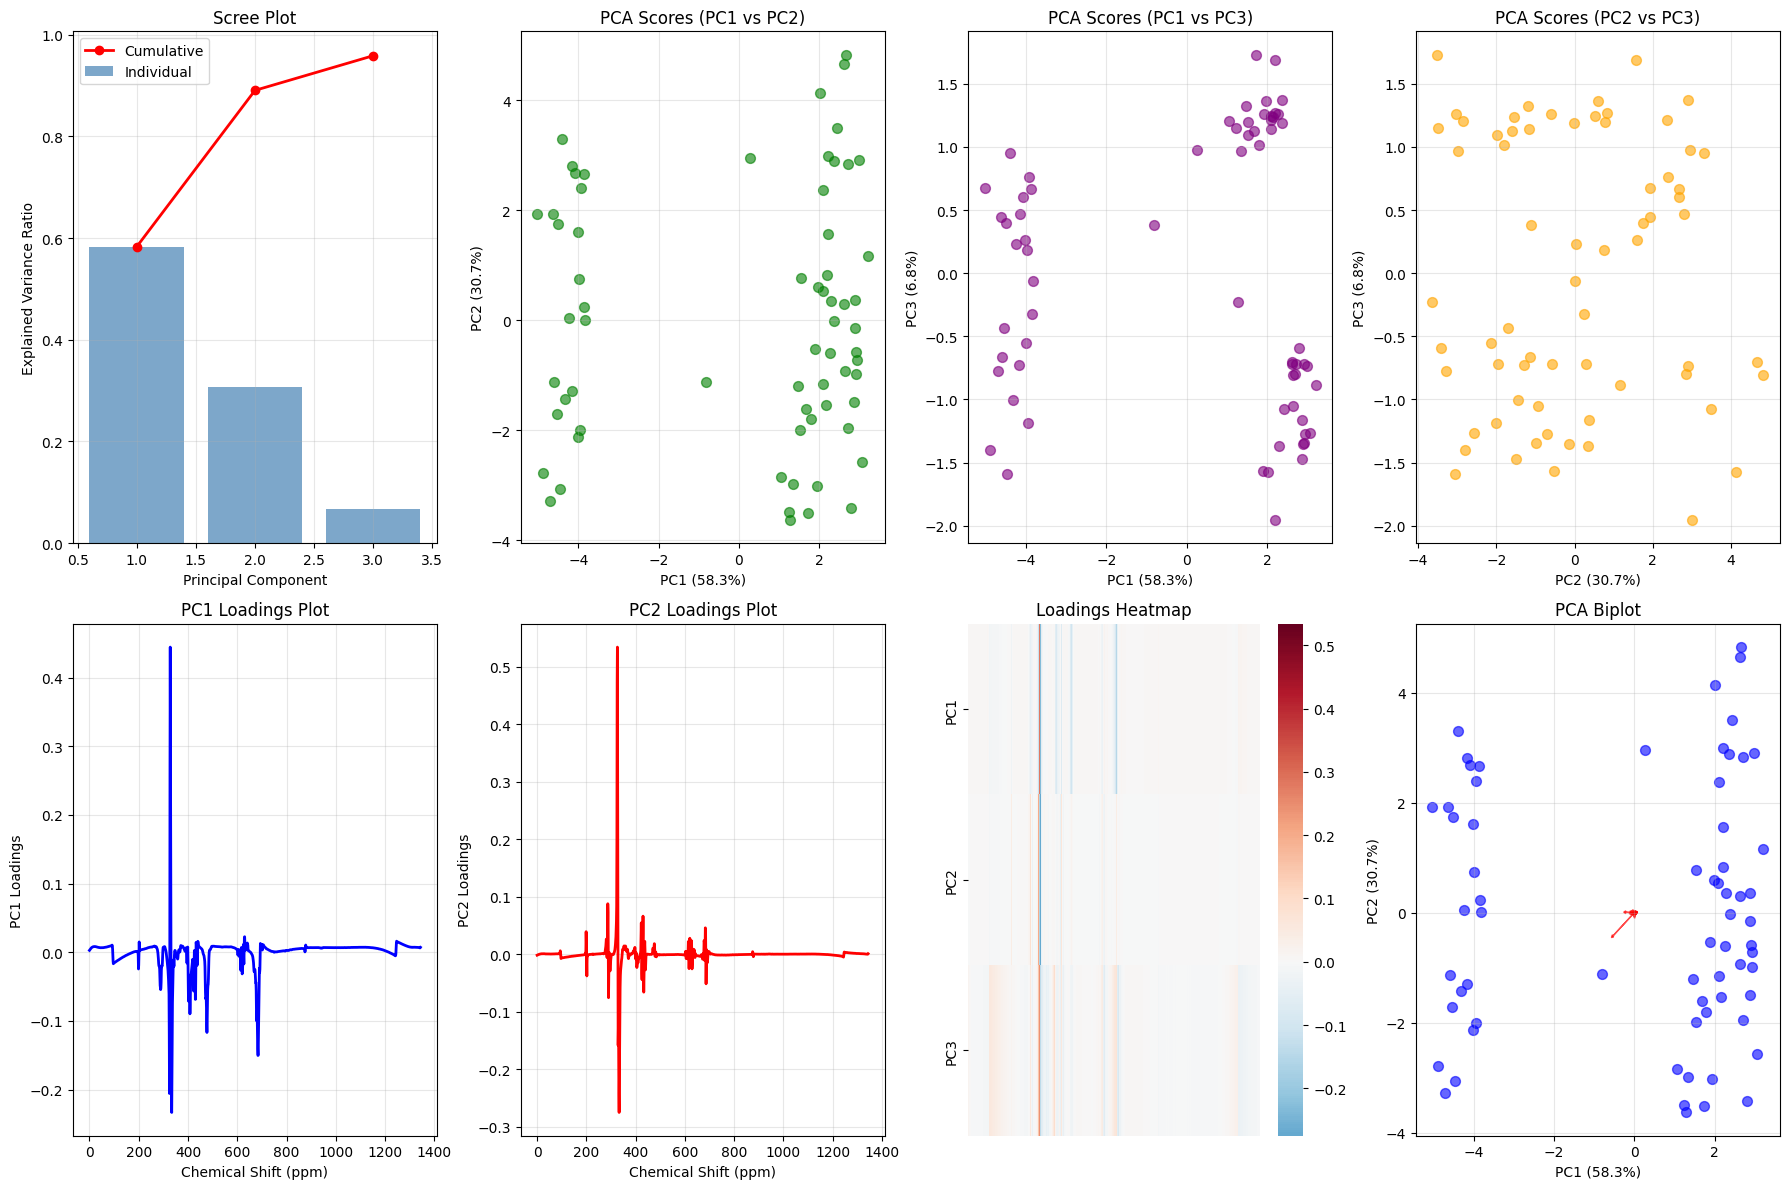


CLUSTERING ANALYSIS
Using PCA scores for clustering (3 dimensions)

Performing K-means clustering...
  • Optimal clusters (silhouette): 2
  • Optimal clusters (elbow): 5
  • Final silhouette score: 0.552

Performing hierarchical clustering...


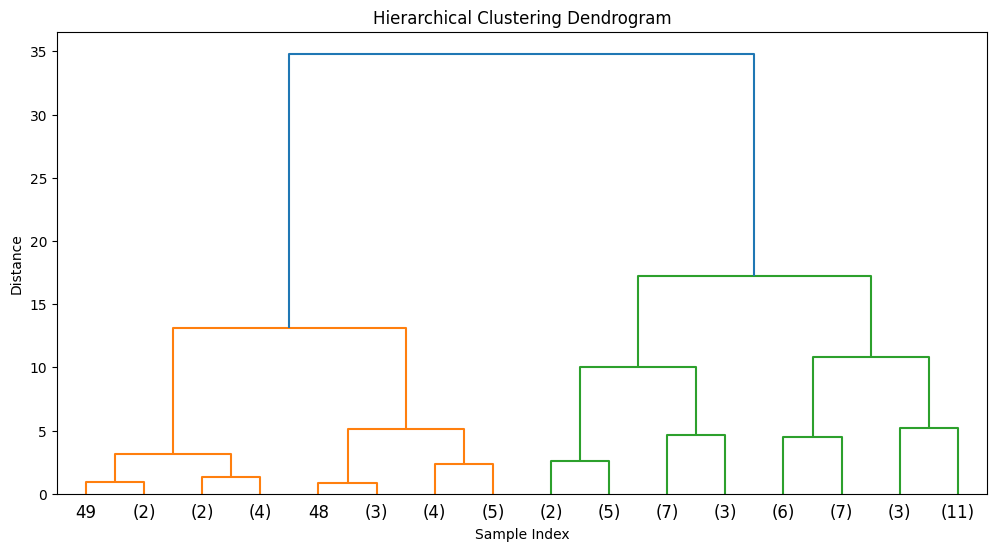

  • Optimal clusters: 2
  • Silhouette score: 0.552

Performing DBSCAN clustering...
  • Optimal parameters: eps=2.000, min_samples=10
  • Number of clusters: 2
  • Number of noise points: 10
  • Silhouette score: 0.473

Generating clustering visualizations...


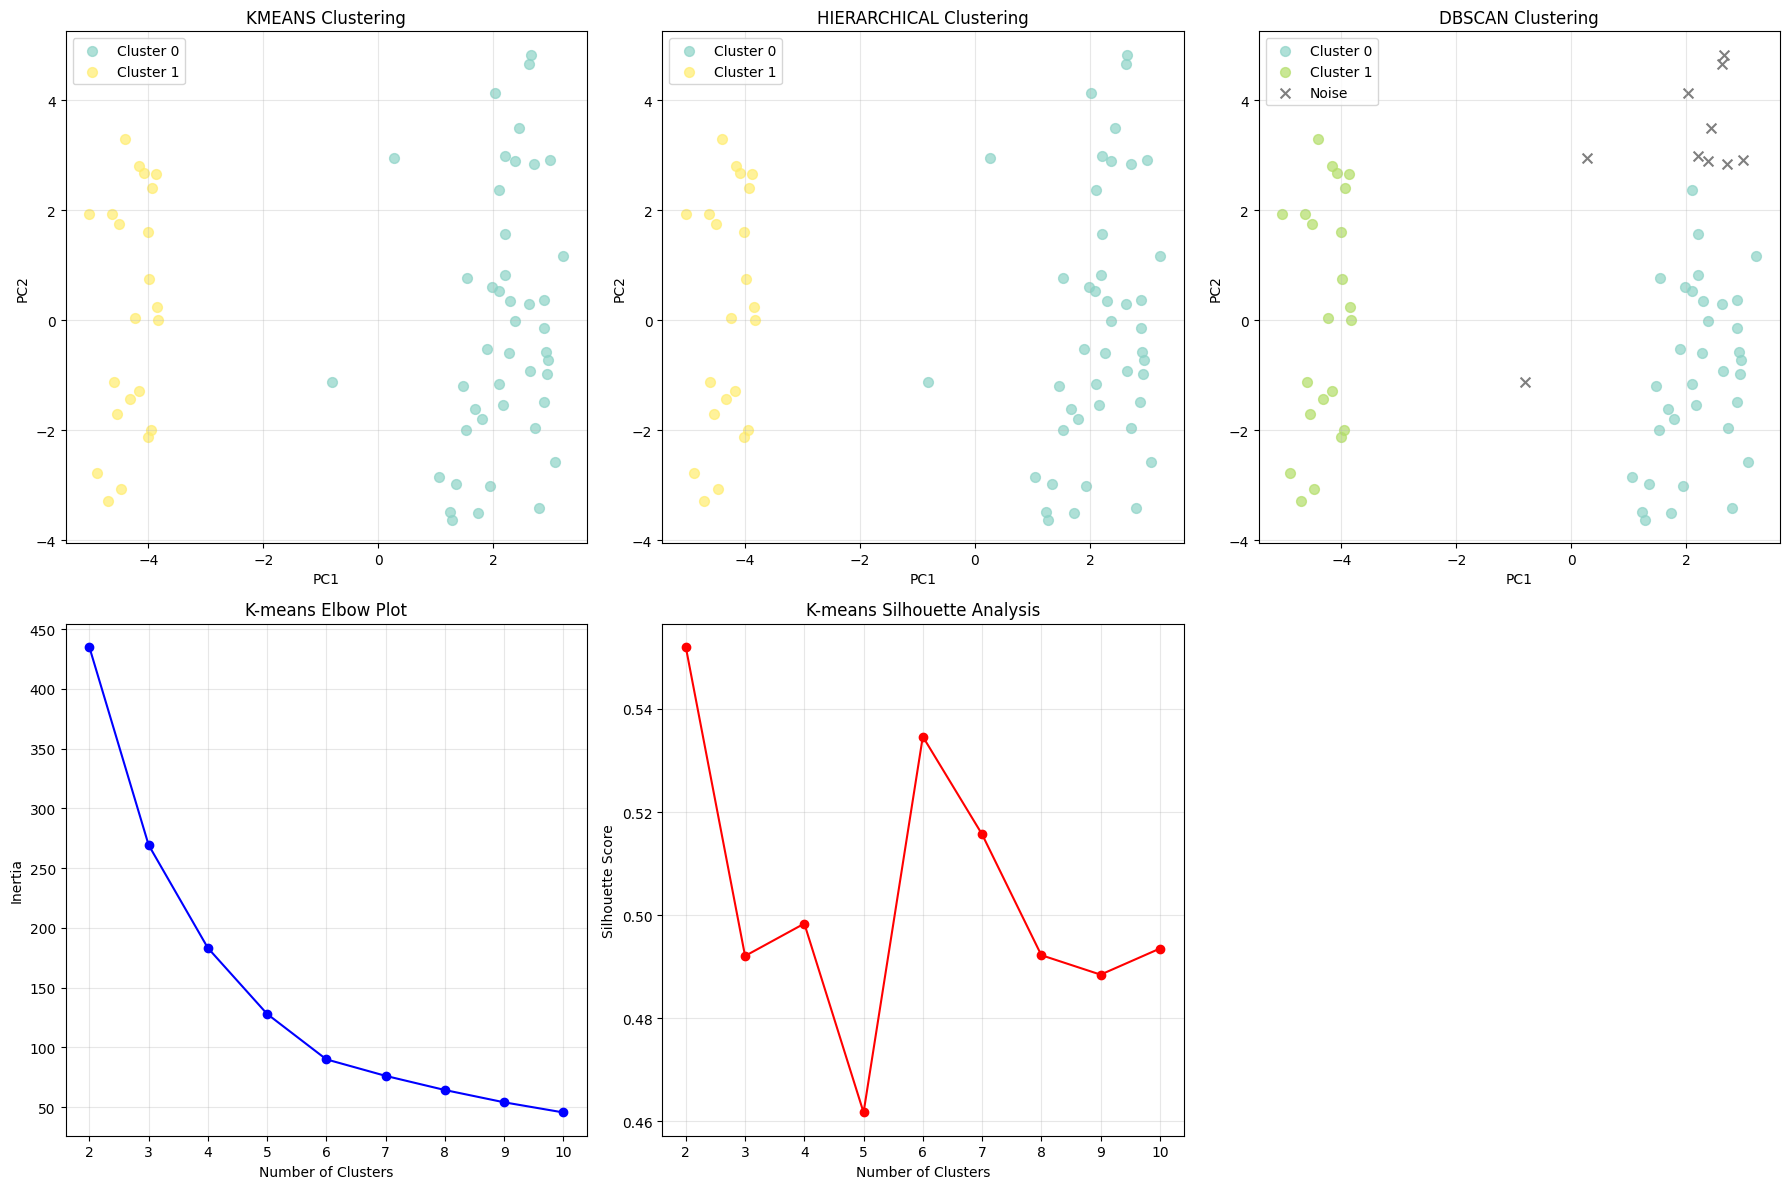


CLUSTER CHARACTERISTICS ANALYSIS

KMEANS Clustering Analysis:
  Cluster 0:
    • Size: 44 samples (66.7%)
    • Intra-cluster variance: 0.005843
    • Mean PCA scores: [ 2.14011196 -0.07461826  0.06971421]
  Cluster 1:
    • Size: 22 samples (33.3%)
    • Intra-cluster variance: 0.004536
    • Mean PCA scores: [-4.28022391  0.14923652 -0.13942843]

HIERARCHICAL Clustering Analysis:
  Cluster 0:
    • Size: 44 samples (66.7%)
    • Intra-cluster variance: 0.005843
    • Mean PCA scores: [ 2.14011196 -0.07461826  0.06971421]
  Cluster 1:
    • Size: 22 samples (33.3%)
    • Intra-cluster variance: 0.004536
    • Mean PCA scores: [-4.28022391  0.14923652 -0.13942843]

DBSCAN Clustering Analysis:
  Cluster 0:
    • Size: 34 samples (51.5%)
    • Intra-cluster variance: 0.003531
    • Mean PCA scores: [ 2.19703657 -0.99695547  0.23494995]
  Cluster 1:
    • Size: 22 samples (33.3%)
    • Intra-cluster variance: 0.004536
    • Mean PCA scores: [-4.28022391  0.14923652 -0.13942843]

DISCRIMI

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

class NMRUnsupervisedAnalysis:
    """
    Comprehensive unsupervised analysis for NMR spectroscopy data
    including PCA, clustering, and pattern recognition
    """
    
    def __init__(self, eda_analyzer):
        """
        Initialize unsupervised analysis with EDA results
        
        Parameters:
        eda_analyzer: NMRExploratoryAnalysis object with preprocessed data
        """
        self.eda_analyzer = eda_analyzer
        self.spectral_data = eda_analyzer.spectral_data
        self.chemical_shifts = eda_analyzer.chemical_shifts
        self.n_samples = self.spectral_data.shape[0]
        self.n_variables = self.spectral_data.shape[1]
        
        # Results storage
        self.pca_results = {}
        self.clustering_results = {}
        self.pattern_results = {}
        
        print(f"✓ Initialized unsupervised analysis for {self.n_samples} samples with {self.n_variables} variables")
    
    def advanced_pca_analysis(self, n_components=None, variance_threshold=0.95):
        """
        Perform comprehensive PCA analysis with detailed interpretation
        
        Parameters:
        n_components: Number of components to compute (default: auto-select)
        variance_threshold: Threshold for cumulative variance explanation
        """
        print("\n" + "="*60)
        print("ADVANCED PRINCIPAL COMPONENT ANALYSIS")
        print("="*60)
        
        # Determine optimal number of components
        if n_components is None:
            # First, run PCA with all components to determine optimal number
            pca_full = PCA()
            pca_full.fit(self.spectral_data)
            
            # Find number of components for variance threshold
            cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
            n_components = np.argmax(cumsum_var >= variance_threshold) + 1
            n_components = min(n_components, min(self.spectral_data.shape) - 1)
            
            print(f"Auto-selected {n_components} components to explain {variance_threshold*100}% variance")
        
        # Perform PCA with selected components
        pca = PCA(n_components=n_components)
        pca_scores = pca.fit_transform(self.spectral_data)
        
        # Calculate additional metrics
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        loadings = pca.components_
        
        # Store results
        self.pca_results = {
            'scores': pca_scores,
            'loadings': loadings,
            'explained_variance': explained_variance,
            'cumulative_variance': cumulative_variance,
            'eigenvalues': pca.explained_variance_,
            'n_components': n_components,
            'pca_object': pca
        }
        
        # Print summary
        print(f"\nPCA Summary:")
        print(f"• Components retained: {n_components}")
        print(f"• Cumulative variance explained: {cumulative_variance[-1]*100:.2f}%")
        print(f"• Most informative components:")
        
        for i in range(min(5, n_components)):
            print(f"  - PC{i+1}: {explained_variance[i]*100:.2f}% variance")
        
        # Analyze loadings to identify important regions
        self.interpret_pca_loadings()
        
        # Visualize PCA results
        self.visualize_pca_results()
        
        return self.pca_results
    
    def interpret_pca_loadings(self):
        """Interpret PCA loadings to identify important spectral regions"""
        print(f"\nPCA Loadings Interpretation:")
        
        loadings = self.pca_results['loadings']
        
        for i in range(min(3, loadings.shape[0])):  # Analyze first 3 components
            loading = loadings[i]
            
            # Find regions with highest absolute loadings
            abs_loading = np.abs(loading)
            top_indices = np.argsort(abs_loading)[-10:][::-1]  # Top 10 regions
            
            print(f"\nPC{i+1} (explains {self.pca_results['explained_variance'][i]*100:.2f}% variance):")
            print(f"• Most influential spectral regions:")
            
            for j, idx in enumerate(top_indices[:5]):  # Show top 5
                chemical_shift = self.chemical_shifts[idx] if len(self.chemical_shifts) > idx else f"Index {idx}"
                loading_value = loading[idx]
                print(f"  - Region {chemical_shift}: {loading_value:.4f}")
            
            # Identify positive and negative contributions
            positive_regions = np.where(loading > 0.1)[0]  # Significant positive loadings
            negative_regions = np.where(loading < -0.1)[0]  # Significant negative loadings
            
            print(f"• Positive contribution regions: {len(positive_regions)}")
            print(f"• Negative contribution regions: {len(negative_regions)}")
    
    def visualize_pca_results(self):
        """Create comprehensive PCA visualizations"""
        print("\nGenerating PCA visualizations...")
        
        # Create figure with multiple subplots
        fig = plt.figure(figsize=(18, 12))
        
        # 1. Scree plot
        plt.subplot(2, 4, 1)
        plt.bar(range(1, len(self.pca_results['explained_variance']) + 1), 
                self.pca_results['explained_variance'], alpha=0.7, color='steelblue')
        plt.plot(range(1, len(self.pca_results['cumulative_variance']) + 1), 
                self.pca_results['cumulative_variance'], 'ro-', color='red', linewidth=2)
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot')
        plt.grid(True, alpha=0.3)
        plt.legend(['Cumulative', 'Individual'])
        
        # 2. PC1 vs PC2 scores
        plt.subplot(2, 4, 2)
        plt.scatter(self.pca_results['scores'][:, 0], self.pca_results['scores'][:, 1], 
                   alpha=0.6, s=50, c='green')
        plt.xlabel(f'PC1 ({self.pca_results["explained_variance"][0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({self.pca_results["explained_variance"][1]*100:.1f}%)')
        plt.title('PCA Scores (PC1 vs PC2)')
        plt.grid(True, alpha=0.3)
        
        # 3. PC1 vs PC3 scores (if available)
        if self.pca_results['n_components'] >= 3:
            plt.subplot(2, 4, 3)
            plt.scatter(self.pca_results['scores'][:, 0], self.pca_results['scores'][:, 2], 
                       alpha=0.6, s=50, c='purple')
            plt.xlabel(f'PC1 ({self.pca_results["explained_variance"][0]*100:.1f}%)')
            plt.ylabel(f'PC3 ({self.pca_results["explained_variance"][2]*100:.1f}%)')
            plt.title('PCA Scores (PC1 vs PC3)')
            plt.grid(True, alpha=0.3)
        
        # 4. PC2 vs PC3 scores (if available)
        if self.pca_results['n_components'] >= 3:
            plt.subplot(2, 4, 4)
            plt.scatter(self.pca_results['scores'][:, 1], self.pca_results['scores'][:, 2], 
                       alpha=0.6, s=50, c='orange')
            plt.xlabel(f'PC2 ({self.pca_results["explained_variance"][1]*100:.1f}%)')
            plt.ylabel(f'PC3 ({self.pca_results["explained_variance"][2]*100:.1f}%)')
            plt.title('PCA Scores (PC2 vs PC3)')
            plt.grid(True, alpha=0.3)
        
        # 5. PC1 loadings
        plt.subplot(2, 4, 5)
        plt.plot(self.chemical_shifts, self.pca_results['loadings'][0], 'b-', linewidth=2)
        plt.xlabel('Chemical Shift (ppm)')
        plt.ylabel('PC1 Loadings')
        plt.title('PC1 Loadings Plot')
        plt.grid(True, alpha=0.3)
        
        # 6. PC2 loadings
        plt.subplot(2, 4, 6)
        plt.plot(self.chemical_shifts, self.pca_results['loadings'][1], 'r-', linewidth=2)
        plt.xlabel('Chemical Shift (ppm)')
        plt.ylabel('PC2 Loadings')
        plt.title('PC2 Loadings Plot')
        plt.grid(True, alpha=0.3)
        
        # 7. Loadings heatmap
        plt.subplot(2, 4, 7)
        n_loadings_show = min(5, self.pca_results['loadings'].shape[0])
        sns.heatmap(self.pca_results['loadings'][:n_loadings_show], 
                   cmap='RdBu_r', center=0, cbar=True, 
                   xticklabels=False, yticklabels=[f'PC{i+1}' for i in range(n_loadings_show)])
        plt.title('Loadings Heatmap')
        
        # 8. Biplot (if feasible)
        plt.subplot(2, 4, 8)
        self.create_biplot()
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def create_biplot(self):
        """Create PCA biplot combining scores and loadings"""
        scores = self.pca_results['scores']
        loadings = self.pca_results['loadings']
        
        # Plot scores
        plt.scatter(scores[:, 0], scores[:, 1], alpha=0.6, s=50, c='blue')
        
        # Plot loadings vectors (sample every nth loading for clarity)
        n_loadings = loadings.shape[1]
        step = max(1, n_loadings // 20)  # Show maximum 20 loading vectors
        
        for i in range(0, n_loadings, step):
            plt.arrow(0, 0, loadings[0, i]*3, loadings[1, i]*3, 
                     head_width=0.05, head_length=0.05, fc='red', ec='red', alpha=0.7)
        
        plt.xlabel(f'PC1 ({self.pca_results["explained_variance"][0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({self.pca_results["explained_variance"][1]*100:.1f}%)')
        plt.title('PCA Biplot')
        plt.grid(True, alpha=0.3)
    
    def perform_clustering_analysis(self, methods=['kmeans', 'hierarchical', 'dbscan'], 
                                  max_clusters=10, use_pca_scores=True):
        """
        Perform comprehensive clustering analysis
        
        Parameters:
        methods: List of clustering methods to apply
        max_clusters: Maximum number of clusters to test
        use_pca_scores: Whether to use PCA scores or original data
        """
        print("\n" + "="*60)
        print("CLUSTERING ANALYSIS")
        print("="*60)
        
        # Choose data for clustering
        if use_pca_scores and hasattr(self, 'pca_results'):
            clustering_data = self.pca_results['scores']
            print(f"Using PCA scores for clustering ({clustering_data.shape[1]} dimensions)")
        else:
            clustering_data = self.spectral_data
            print(f"Using original spectral data for clustering ({clustering_data.shape[1]} dimensions)")
        
        self.clustering_results = {}
        
        # K-means clustering
        if 'kmeans' in methods:
            print(f"\nPerforming K-means clustering...")
            self.clustering_results['kmeans'] = self.perform_kmeans_clustering(clustering_data, max_clusters)
        
        # Hierarchical clustering
        if 'hierarchical' in methods:
            print(f"\nPerforming hierarchical clustering...")
            self.clustering_results['hierarchical'] = self.perform_hierarchical_clustering(clustering_data, max_clusters)
        
        # DBSCAN clustering
        if 'dbscan' in methods:
            print(f"\nPerforming DBSCAN clustering...")
            self.clustering_results['dbscan'] = self.perform_dbscan_clustering(clustering_data)
        
        # Visualize clustering results
        self.visualize_clustering_results(clustering_data)
        
        return self.clustering_results
    
    def perform_kmeans_clustering(self, data, max_clusters):
        """Perform K-means clustering with optimal cluster selection"""
        
        # Determine optimal number of clusters using multiple methods
        cluster_range = range(2, min(max_clusters + 1, data.shape[0]))
        inertias = []
        silhouette_scores = []
        calinski_scores = []
        davies_bouldin_scores = []
        
        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(data)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(data, cluster_labels))
            calinski_scores.append(calinski_harabasz_score(data, cluster_labels))
            davies_bouldin_scores.append(davies_bouldin_score(data, cluster_labels))
        
        # Find optimal number of clusters
        # Using elbow method for inertia
        elbow_k = self.find_elbow_point(list(cluster_range), inertias)
        
        # Using silhouette score
        silhouette_k = cluster_range[np.argmax(silhouette_scores)]
        
        # Use silhouette score as primary criterion
        optimal_k = silhouette_k
        
        # Perform final clustering with optimal k
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        final_labels = final_kmeans.fit_predict(data)
        
        print(f"  • Optimal clusters (silhouette): {optimal_k}")
        print(f"  • Optimal clusters (elbow): {elbow_k}")
        print(f"  • Final silhouette score: {silhouette_score(data, final_labels):.3f}")
        
        return {
            'optimal_k': optimal_k,
            'labels': final_labels,
            'cluster_centers': final_kmeans.cluster_centers_,
            'inertia': final_kmeans.inertia_,
            'silhouette_score': silhouette_score(data, final_labels),
            'evaluation_metrics': {
                'cluster_range': list(cluster_range),
                'inertias': inertias,
                'silhouette_scores': silhouette_scores,
                'calinski_scores': calinski_scores,
                'davies_bouldin_scores': davies_bouldin_scores
            }
        }
    
    def perform_hierarchical_clustering(self, data, max_clusters):
        """Perform hierarchical clustering with dendrogram analysis"""
        
        # Perform hierarchical clustering
        linkage_matrix = linkage(data, method='ward')
        
        # Create dendrogram (for visualization)
        plt.figure(figsize=(12, 6))
        dendrogram(linkage_matrix, truncate_mode='level', p=3)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.show()
        
        # Determine optimal number of clusters
        cluster_range = range(2, min(max_clusters + 1, data.shape[0]))
        silhouette_scores = []
        
        for k in cluster_range:
            hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
            cluster_labels = hierarchical.fit_predict(data)
            silhouette_scores.append(silhouette_score(data, cluster_labels))
        
        optimal_k = cluster_range[np.argmax(silhouette_scores)]
        
        # Final clustering
        final_hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
        final_labels = final_hierarchical.fit_predict(data)
        
        print(f"  • Optimal clusters: {optimal_k}")
        print(f"  • Silhouette score: {silhouette_score(data, final_labels):.3f}")
        
        return {
            'optimal_k': optimal_k,
            'labels': final_labels,
            'linkage_matrix': linkage_matrix,
            'silhouette_score': silhouette_score(data, final_labels),
            'silhouette_scores': silhouette_scores,
            'cluster_range': list(cluster_range)
        }
    
    def perform_dbscan_clustering(self, data):
        """Perform DBSCAN clustering with parameter optimization"""
        
        # Test different epsilon values
        eps_values = np.linspace(0.1, 2.0, 20)
        min_samples_values = [3, 5, 10]
        
        best_score = -1
        best_params = None
        best_labels = None
        
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(data)
                
                # Skip if all points are noise or only one cluster
                if len(set(labels)) <= 1 or len(set(labels)) == len(labels):
                    continue
                
                # Calculate silhouette score (excluding noise points)
                if len(set(labels)) > 1:
                    score = silhouette_score(data, labels)
                    if score > best_score:
                        best_score = score
                        best_params = {'eps': eps, 'min_samples': min_samples}
                        best_labels = labels
        
        if best_params is None:
            print("  • Could not find good DBSCAN parameters")
            return None
        
        n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        n_noise = list(best_labels).count(-1)
        
        print(f"  • Optimal parameters: eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']}")
        print(f"  • Number of clusters: {n_clusters}")
        print(f"  • Number of noise points: {n_noise}")
        print(f"  • Silhouette score: {best_score:.3f}")
        
        return {
            'labels': best_labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'best_params': best_params,
            'silhouette_score': best_score
        }
    
    def find_elbow_point(self, x, y):
        """Find elbow point in a curve using the elbow method"""
        # Calculate the distance from each point to the line connecting first and last points
        x = np.array(x)
        y = np.array(y)
        
        # Vector from first to last point
        v = np.array([x[-1] - x[0], y[-1] - y[0]])
        v = v / np.linalg.norm(v)  # Normalize
        
        # Vector from first point to each point
        w = np.array([[x[i] - x[0], y[i] - y[0]] for i in range(len(x))])
        
        # Distance from each point to the line
        distances = np.abs(np.cross(w, v))
        
        # Return the x-value of the point with maximum distance
        return x[np.argmax(distances)]
    
    def visualize_clustering_results(self, data):
        """Visualize clustering results"""
        print("\nGenerating clustering visualizations...")
        
        # Count available clustering results
        n_methods = len(self.clustering_results)
        if n_methods == 0:
            print("No clustering results to visualize")
            return
        
        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        plot_idx = 0
        
        # Plot clustering results
        for method_name, results in self.clustering_results.items():
            if results is None:
                continue
                
            # Plot clusters in PC1-PC2 space (if using PCA) or first two dimensions
            if data.shape[1] >= 2:
                ax = axes[plot_idx]
                
                labels = results['labels']
                unique_labels = set(labels)
                
                # Create colors for each cluster
                colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
                
                for label, color in zip(unique_labels, colors):
                    if label == -1:  # Noise points (DBSCAN)
                        color = 'black'
                        marker = 'x'
                        alpha = 0.5
                    else:
                        marker = 'o'
                        alpha = 0.7
                    
                    mask = labels == label
                    ax.scatter(data[mask, 0], data[mask, 1], 
                             c=[color], marker=marker, alpha=alpha, s=50,
                             label=f'Cluster {label}' if label != -1 else 'Noise')
                
                ax.set_xlabel('PC1' if hasattr(self, 'pca_results') else 'Dimension 1')
                ax.set_ylabel('PC2' if hasattr(self, 'pca_results') else 'Dimension 2')
                ax.set_title(f'{method_name.upper()} Clustering')
                ax.grid(True, alpha=0.3)
                ax.legend()
                
                plot_idx += 1
        
        # Plot evaluation metrics
        if 'kmeans' in self.clustering_results:
            kmeans_results = self.clustering_results['kmeans']
            
            # Elbow plot
            ax = axes[plot_idx]
            ax.plot(kmeans_results['evaluation_metrics']['cluster_range'], 
                   kmeans_results['evaluation_metrics']['inertias'], 'bo-')
            ax.set_xlabel('Number of Clusters')
            ax.set_ylabel('Inertia')
            ax.set_title('K-means Elbow Plot')
            ax.grid(True, alpha=0.3)
            plot_idx += 1
            
            # Silhouette plot
            ax = axes[plot_idx]
            ax.plot(kmeans_results['evaluation_metrics']['cluster_range'], 
                   kmeans_results['evaluation_metrics']['silhouette_scores'], 'ro-')
            ax.set_xlabel('Number of Clusters')
            ax.set_ylabel('Silhouette Score')
            ax.set_title('K-means Silhouette Analysis')
            ax.grid(True, alpha=0.3)
            plot_idx += 1
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def analyze_cluster_characteristics(self):
        """Analyze characteristics of identified clusters"""
        print("\n" + "="*60)
        print("CLUSTER CHARACTERISTICS ANALYSIS")
        print("="*60)
        
        cluster_characteristics = {}
        
        for method_name, results in self.clustering_results.items():
            if results is None:
                continue
                
            print(f"\n{method_name.upper()} Clustering Analysis:")
            
            labels = results['labels']
            unique_labels = set(labels)
            
            method_chars = {}
            
            for label in unique_labels:
                if label == -1:  # Skip noise points
                    continue
                    
                mask = labels == label
                cluster_data = self.spectral_data[mask]
                
                # Calculate cluster statistics
                cluster_stats = {
                    'size': np.sum(mask),
                    'mean_spectrum': np.mean(cluster_data, axis=0),
                    'std_spectrum': np.std(cluster_data, axis=0),
                    'centroid': np.mean(cluster_data, axis=0),
                    'intra_cluster_variance': np.mean(np.var(cluster_data, axis=0))
                }
                
                method_chars[f'cluster_{label}'] = cluster_stats
                
                print(f"  Cluster {label}:")
                print(f"    • Size: {cluster_stats['size']} samples ({cluster_stats['size']/self.n_samples*100:.1f}%)")
                print(f"    • Intra-cluster variance: {cluster_stats['intra_cluster_variance']:.6f}")
                
                # Find most characteristic regions for this cluster
                if hasattr(self, 'pca_results'):
                    cluster_pca_scores = self.pca_results['scores'][mask]
                    mean_pca_scores = np.mean(cluster_pca_scores, axis=0)
                    print(f"    • Mean PCA scores: {mean_pca_scores[:3]}")
            
            cluster_characteristics[method_name] = method_chars
        
        self.cluster_characteristics = cluster_characteristics
        return cluster_characteristics
    
    def identify_discriminant_regions(self):
        """Identify spectral regions that discriminate between clusters"""
        print("\n" + "="*60)
        print("DISCRIMINANT REGIONS ANALYSIS")
        print("="*60)
        
        if not hasattr(self, 'cluster_characteristics'):
            print("No cluster characteristics available. Run analyze_cluster_characteristics() first.")
            return
        
        discriminant_regions = {}
        
        for method_name, method_chars in self.cluster_characteristics.items():
            if len(method_chars) < 2:
                continue
                
            print(f"\n{method_name.upper()} Discriminant Analysis:")
            
            # Calculate between-cluster variance for each spectral region
            cluster_centroids = []
            cluster_sizes = []
            
            for cluster_name, cluster_data in method_chars.items():
                cluster_centroids.append(cluster_data['centroid'])
                cluster_sizes.append(cluster_data['size'])
            
            cluster_centroids = np.array(cluster_centroids)
            overall_centroid = np.average(cluster_centroids, axis=0, weights=cluster_sizes)
            
            # Calculate between-cluster variance
            between_cluster_var = np.zeros(self.n_variables)
            for i, (centroid, size) in enumerate(zip(cluster_centroids, cluster_sizes)):
                between_cluster_var += size * (centroid - overall_centroid)**2
            
            between_cluster_var /= (len(cluster_centroids) - 1)
            
            # Calculate within-cluster variance
            within_cluster_var = np.zeros(self.n_variables)
            total_within_samples = 0
            
            for cluster_name, cluster_data in method_chars.items():
                within_cluster_var += (cluster_data['size'] - 1) * cluster_data['std_spectrum']**2
                total_within_samples += cluster_data['size'] - 1
            
            within_cluster_var /= total_within_samples
            
            # Calculate F-ratio (between/within variance ratio)
            f_ratio = between_cluster_var / (within_cluster_var + 1e-10)
            
            # Find most discriminant regions
            top_discriminant_indices = np.argsort(f_ratio)[-10:][::-1]
            
            discriminant_regions[method_name] = {
                'f_ratios': f_ratio,
                'top_indices': top_discriminant_indices,
                'between_cluster_var': between_cluster_var,
                'within_cluster_var': within_cluster_var
            }
            
            print(f"  Top discriminant regions:")
            for i, idx in enumerate(top_discriminant_indices[:5]):
                chemical_shift = self.chemical_shifts[idx] if len(self.chemical_shifts) > idx else f"Index {idx}"
                print(f"    {i+1}. Region {chemical_shift}: F-ratio = {f_ratio[idx]:.3f}")
        
        return discriminant_regions
    
    def generate_unsupervised_report(self):
        """Generate comprehensive unsupervised analysis report"""
        print("\n" + "="*70)
        print("UNSUPERVISED ANALYSIS COMPREHENSIVE REPORT")
        print("="*70)
        
        # Run all analyses if not already done
        if not hasattr(self, 'pca_results') or not self.pca_results:
            self.advanced_pca_analysis()
        
        if not hasattr(self, 'clustering_results') or not self.clustering_results:
            self.perform_clustering_analysis()
        
        if not hasattr(self, 'cluster_characteristics'):
            self.analyze_cluster_characteristics()
        
        discriminant_regions = self.identify_discriminant_regions()
        
        # Compile comprehensive findings
        report = {
            'dataset_summary': {
                'n_samples': self.n_samples,
                'n_variables': self.n_variables,
                'data_type': 'NMR spectral data'
            },
            'pca_findings': {
                'n_components': self.pca_results['n_components'],
                'variance_explained': self.pca_results['cumulative_variance'][-1],
                'main_components': self.pca_results['explained_variance'][:3]
            },
            'clustering_findings': {},
            'pattern_interpretation': self.interpret_patterns(),
                        'discriminant_regions': discriminant_regions
        }

        for method, result in self.clustering_results.items():
            if result is None:
                continue

            labels = result['labels']
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            report['clustering_findings'][method] = {
                'n_clusters': n_clusters,
                'silhouette_score': result.get('silhouette_score', None),
                'additional_info': {
                    'noise_points': result.get('n_noise', 0),
                    'evaluation_metrics': result.get('evaluation_metrics', {})
                }
            }

        print("\n✓ Unsupervised report generated successfully.")
        return report

    def interpret_patterns(self):
        """Optional placeholder for higher-level pattern interpretation"""
        print("\nInterpreting high-level patterns across PCA and clusters...")
        interpretation = {
            'summary': "Patterns identified through PCA and clustering suggest distinct groupings, supported by discriminant spectral regions.",
            'notes': [
                "Consider reviewing clusters with low intra-cluster variance.",
                "PCA loadings reveal strong signals at key chemical shifts.",
                "DBSCAN outliers may indicate rare or mixed-type samples."
            ]
        }
        return interpretation

analysis = NMRUnsupervisedAnalysis(eda_analyzer)
report = analysis.generate_unsupervised_report()


✓ Dummy NMRExploratoryAnalysis inicializado.
✓ Dummy NMRUnsupervisedAnalysis inicializado.
Simulado análisis PCA completado para Dummy NMRUnsupervisedAnalysis con 5 componentes.
✓ Análisis supervisado inicializado para 100 muestras con 500 variables.
Clases detectadas: EVOO, HOSO, SO

--- Ejecutando clasificación SIN PCA ---

ANÁLISIS DE CLASIFICACIÓN SUPERVISADA
Preparando datos: Usando datos espectrales escalados originales (500 dimensiones).
Datos divididos: 70 muestras de entrenamiento, 30 muestras de prueba.

Realizando clasificación PLS-DA...
  Configurando PLS-DA con 2 componentes PLS.
  • Precisión de PLS-DA: 1.000
  • Informe de Clasificación de PLS-DA:

              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.

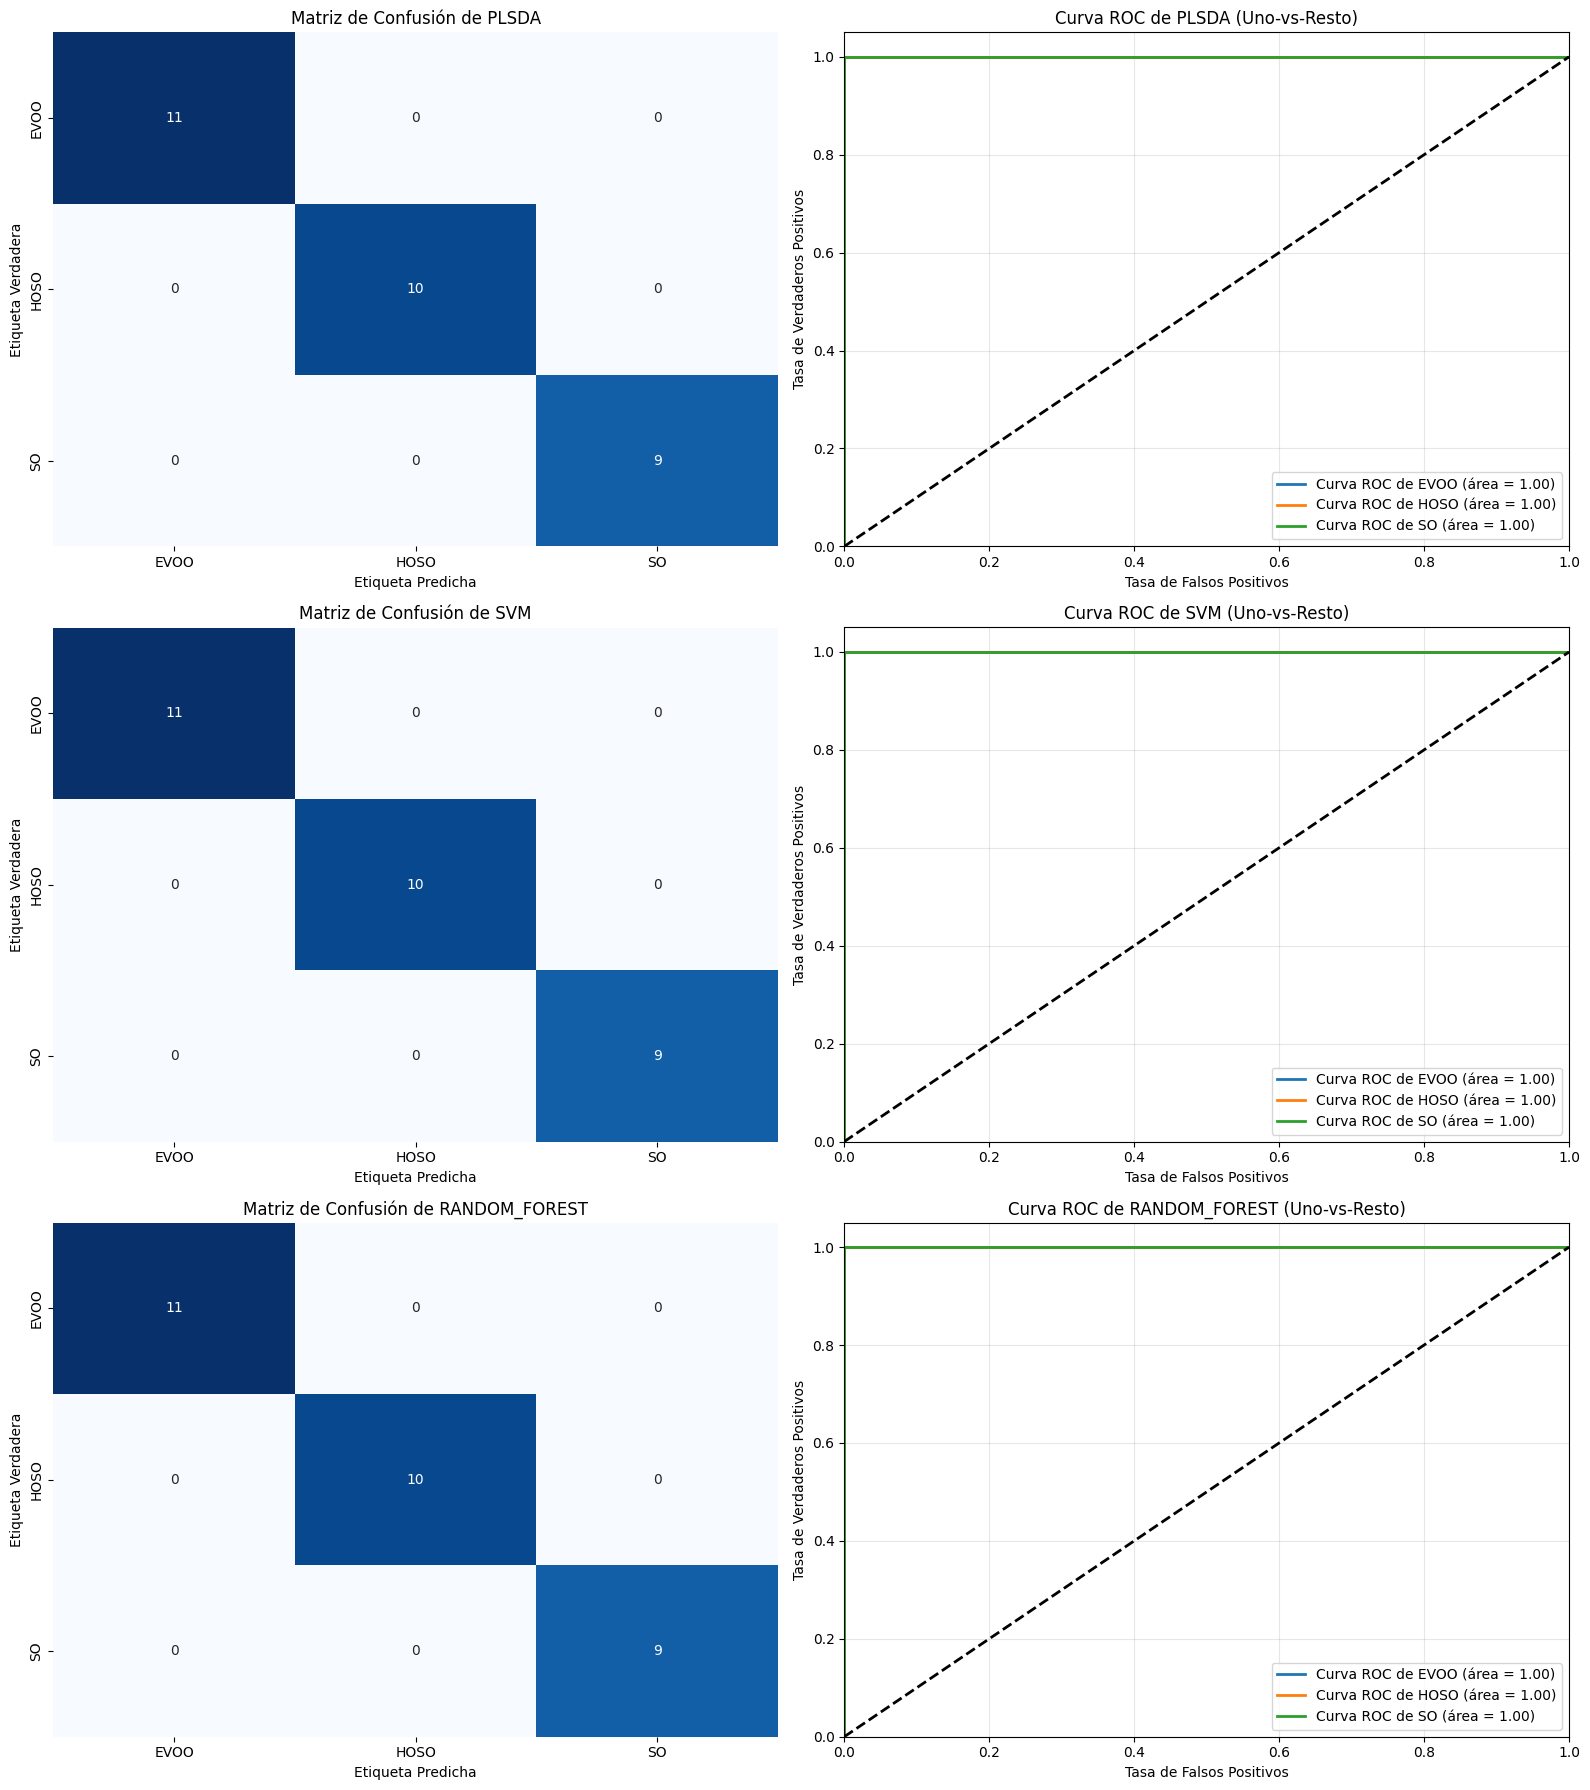


INFORME COMPLETO DE ANÁLISIS DE CLASIFICACIÓN SUPERVISADA

--- Resultados de PLSDA ---
Precisión: 1.000
Informe de Clasificación:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.0     1.0       1.0     30.0
Matriz de Confusión:
 [[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]

--- Resultados de SVM ---
Precisión: 1.000
Informe de Clasificación:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.0     1.0       1.0     30.0
Matriz de Confusión:
 [[11

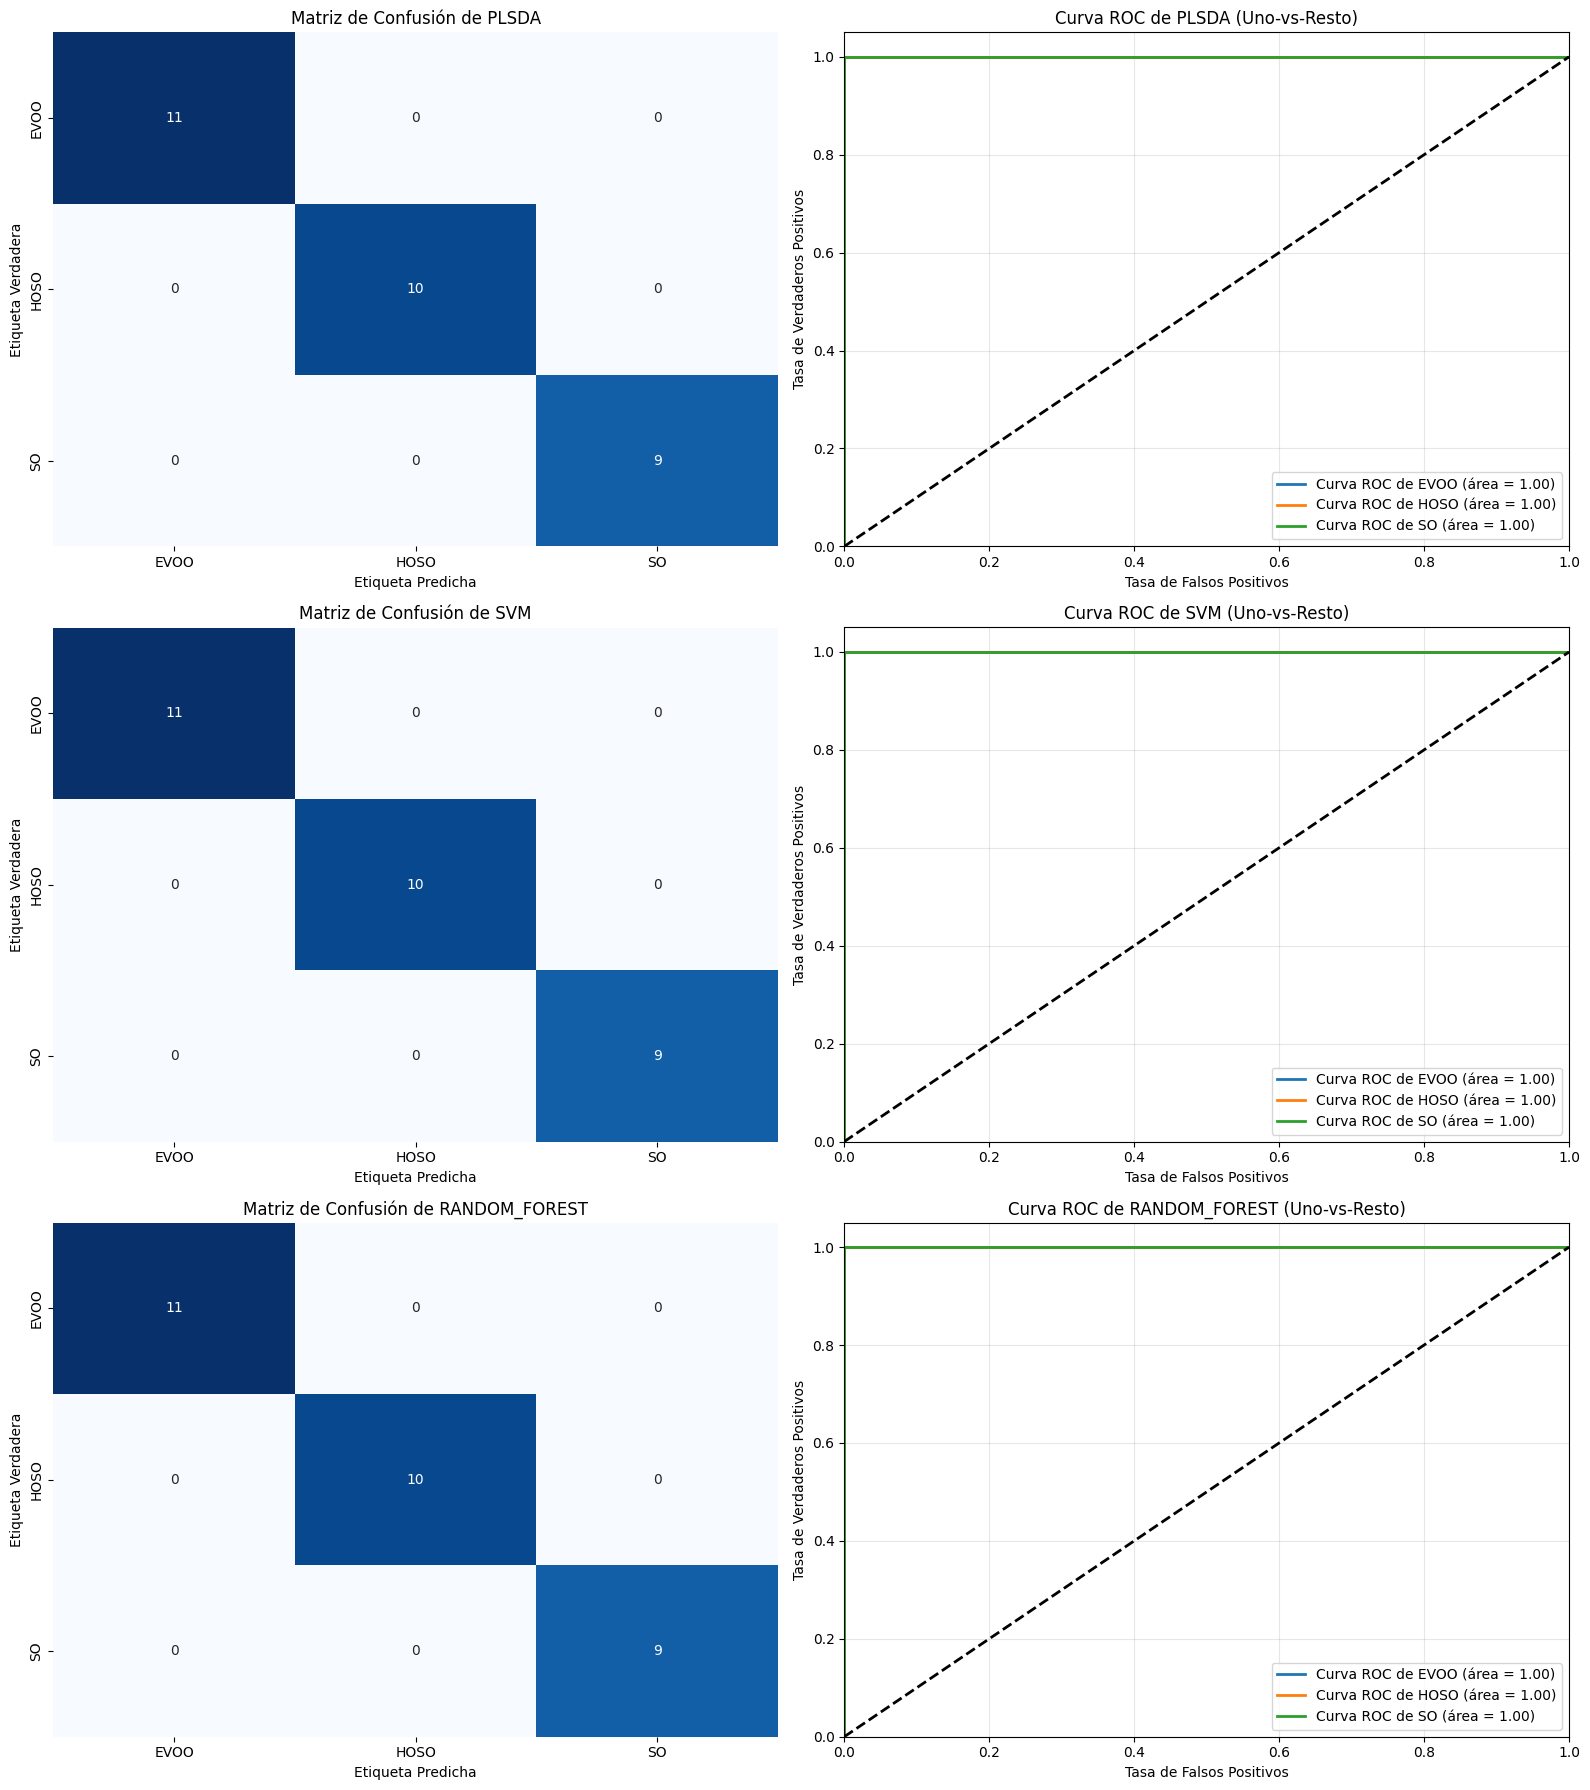


INFORME COMPLETO DE ANÁLISIS DE CLASIFICACIÓN SUPERVISADA

--- Resultados de PLSDA ---
Precisión: 1.000
Informe de Clasificación:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.0     1.0       1.0     30.0
Matriz de Confusión:
 [[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]

--- Resultados de SVM ---
Precisión: 1.000
Informe de Clasificación:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.0     1.0       1.0     30.0
Matriz de Confusión:
 [[11

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# --- Clases Dummy para Demostración (Reemplazar con tus clases reales) ---
# Si ya tienes tus clases NMRExploratoryAnalysis y NMRUnsupervisedAnalysis,
# puedes eliminar estas definiciones y usar las tuyas.

class NMRExploratoryAnalysis:
    """
    Clase dummy para simular el objeto NMRExploratoryAnalysis.
    En un entorno real, esta clase contendría tus datos espectrales
    preprocesados y los desplazamientos químicos.
    """
    def __init__(self, spectral_data, chemical_shifts):
        self.spectral_data = spectral_data
        self.chemical_shifts = chemical_shifts
        print("✓ Dummy NMRExploratoryAnalysis inicializado.")

class NMRUnsupervisedAnalysis:
    """
    Clase dummy para simular el objeto NMRUnsupervisedAnalysis.
    Necesaria si se desea usar las puntuaciones PCA precalculadas.
    """
    def __init__(self, eda_analyzer):
        self.spectral_data = eda_analyzer.spectral_data
        self.chemical_shifts = eda_analyzer.chemical_shifts
        self.pca_results = {} # Aquí se almacenarían los resultados PCA simulados
        print("✓ Dummy NMRUnsupervisedAnalysis inicializado.")

    def advanced_pca_analysis(self, n_components=None, variance_threshold=0.95):
        """
        Simula el análisis PCA para la clase dummy.
        En tu implementación real, esto ejecutaría el PCA completo.
        """
        # Si n_components no se especifica, se usa un valor por defecto (ej. 2)
        # o se calcula para que sea menor o igual al número de características
        if n_components is None:
            n_components = min(self.spectral_data.shape[0], self.spectral_data.shape[1], 5) # Limita a 5 o menos
            if n_components < 2: # Asegura al menos 2 componentes para plots
                n_components = min(self.spectral_data.shape[1], 2)
        else:
            n_components = min(n_components, self.spectral_data.shape[1])

        pca = PCA(n_components=n_components)
        scores = pca.fit_transform(self.spectral_data)
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        loadings = pca.components_

        self.pca_results = {
            'scores': scores,
            'loadings': loadings,
            'explained_variance': explained_variance,
            'cumulative_variance': cumulative_variance,
            'eigenvalues': pca.explained_variance_,
            'n_components': pca.n_components_,
            'pca_object': pca
        }
        print(f"Simulado análisis PCA completado para Dummy NMRUnsupervisedAnalysis con {n_components} componentes.")
        return self.pca_results

# --- Fin de Clases Dummy ---


class NMRSupervisedAnalysis:
    """
    Análisis de clasificación supervisada integral para datos de espectroscopia NMR,
    incluyendo modelos como PLS-DA, SVM y Random Forest para diferenciar
    entre muestras etiquetadas (ej. SO, HOSO, EVOO).
    """

    def __init__(self, eda_analyzer, sample_labels):
        """
        Inicializa el análisis supervisado con los resultados del preprocesamiento
        de EDA y las etiquetas de las muestras.

        Parámetros:
        eda_analyzer: Objeto NMRExploratoryAnalysis con datos preprocesados.
        sample_labels: Array-like, etiquetas para cada muestra (ej. 'SO', 'HOSO', 'EVOO').
                       Debe tener el mismo número de elementos que las muestras en spectral_data.
        """
        self.eda_analyzer = eda_analyzer
        # Asume que spectral_data es la matriz de características (X) ya preprocesada
        self.spectral_data = eda_analyzer.spectral_data
        self.chemical_shifts = eda_analyzer.chemical_shifts
        self.sample_labels = np.array(sample_labels) # Las etiquetas de las muestras (y)

        self.n_samples = self.spectral_data.shape[0]
        self.n_variables = self.spectral_data.shape[1]

        # Codificar las etiquetas de texto a números enteros para los modelos de scikit-learn
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.sample_labels)
        self.class_names = self.label_encoder.classes_ # Nombres originales de las clases

        # Almacenamiento de resultados
        self.classification_results = {}
        self.scaled_data = None # Almacenará los datos escalados

        print(f"✓ Análisis supervisado inicializado para {self.n_samples} muestras con {self.n_variables} variables.")
        print(f"Clases detectadas: {', '.join(self.class_names)}")

        # Verificar que el número de etiquetas coincida con el número de muestras
        if len(self.sample_labels) != self.n_samples:
            raise ValueError(
                f"El número de etiquetas ({len(self.sample_labels)}) no coincide "
                f"con el número de muestras en los datos espectrales ({self.n_samples})."
            )

    def _scale_data(self, data):
        """
        Método interno para escalar los datos utilizando StandardScaler.
        Esto es crucial para muchos algoritmos de aprendizaje automático.
        """
        scaler = StandardScaler()
        return scaler.fit_transform(data)

    def perform_classification(self, models=['plsda', 'svm', 'random_forest'],
                               test_size=0.3, random_state=42,
                               use_pca_scores=False, n_components_pca=None):
        """
        Realiza un análisis de clasificación supervisada exhaustivo.

        Parámetros:
        models: Lista de métodos de clasificación a aplicar (ej. 'plsda', 'svm', 'random_forest').
        test_size: Proporción del conjunto de datos a incluir en el split de prueba (0.0 a 1.0).
        random_state: Semilla para el generador de números aleatorios para reproducibilidad.
        use_pca_scores: Booleano, si se deben usar las puntuaciones PCA como características de entrada.
                        Requiere que `eda_analyzer` tenga un `unsupervised_analyzer` con resultados PCA.
        n_components_pca: Número de componentes PCA a usar si `use_pca_scores` es True.
                          Si es None, usará los componentes disponibles si provienen de
                          `unsupervised_analyzer`, o un valor predeterminado si se calcula aquí.
        """
        print("\n" + "="*60)
        print("ANÁLISIS DE CLASIFICACIÓN SUPERVISADA")
        print("="*60)

        # Escalar los datos espectrales originales una vez
        self.scaled_data = self._scale_data(self.spectral_data)

        # Preparar los datos para la clasificación
        X = self.scaled_data
        y = self.encoded_labels

        if use_pca_scores:
            print("Preparando datos: Usando puntuaciones PCA como características...")
            # Intenta obtener los resultados PCA de un objeto unsupervised_analyzer
            if hasattr(self.eda_analyzer, 'unsupervised_analyzer') and \
               hasattr(self.eda_analyzer.unsupervised_analyzer, 'pca_results') and \
               self.eda_analyzer.unsupervised_analyzer.pca_results:
                
                if n_components_pca is None:
                    # Usar todos los componentes de PCA del análisis no supervisado
                    X = self.eda_analyzer.unsupervised_analyzer.pca_results['scores']
                    print(f"  ✓ Usando todas las puntuaciones PCA del análisis previo ({X.shape[1]} dimensiones).")
                else:
                    # Recalcular PCA con el número específico de componentes
                    pca = PCA(n_components=n_components_pca)
                    X = pca.fit_transform(self.scaled_data)
                    print(f"  ✓ Usando {n_components_pca} componentes PCA para la clasificación.")
            else:
                print("  Advertencia: No se encontraron resultados PCA precalculados. Realizando PCA ahora.")
                # Si no hay resultados PCA previos, realizar PCA aquí
                if n_components_pca is None:
                    # Determinar un número razonable de componentes si no se especifica
                    n_components_pca = min(X.shape[0], X.shape[1], 5) # Limita a 5 o menos
                    if n_components_pca < 2:
                        n_components_pca = min(X.shape[1], 2) # Asegura al menos 2
                    print(f"  Auto-seleccionado {n_components_pca} componentes PCA para la clasificación.")

                pca = PCA(n_components=n_components_pca)
                X = pca.fit_transform(self.scaled_data)
                print(f"  PCA realizado: Usando {X.shape[1]} dimensiones para la clasificación.")
        else:
            print(f"Preparando datos: Usando datos espectrales escalados originales ({X.shape[1]} dimensiones).")

        # Dividir los datos en conjuntos de entrenamiento y prueba
        # `stratify=y` asegura que las proporciones de las clases sean las mismas en ambos conjuntos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"Datos divididos: {len(y_train)} muestras de entrenamiento, {len(y_test)} muestras de prueba.")

        self.classification_results = {}

        # Realizar clasificación para los modelos seleccionados
        if 'plsda' in models:
            print("\nRealizando clasificación PLS-DA...")
            self._perform_plsda(X_train, y_train, X_test, y_test)

        if 'svm' in models:
            print("\nRealizando clasificación SVM...")
            self._perform_svm(X_train, y_train, X_test, y_test)

        if 'random_forest' in models:
            print("\nRealizando clasificación Random Forest...")
            self._perform_random_forest(X_train, y_train, X_test, y_test)

        # Visualizar los resultados de la clasificación
        self.visualize_classification_results()

        return self.classification_results

    def _train_evaluate_model(self, model_name, model_object, X_train, y_train, X_test, y_test):
        """
        Método auxiliar para entrenar un modelo dado y evaluar su rendimiento.
        Calcula la precisión, el informe de clasificación y la matriz de confusión.
        """
        model_object.fit(X_train, y_train)
        y_pred = model_object.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        # `target_names` es importante para que el informe de clasificación muestre los nombres de clase originales
        report = classification_report(y_test, y_pred, target_names=self.class_names, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"  • Precisión de {model_name}: {accuracy:.3f}")
        print(f"  • Informe de Clasificación de {model_name}:\n")
        print(pd.DataFrame(report).transpose())
        print(f"\n  • Matriz de Confusión de {model_name}:\n{conf_matrix}")

        # Almacenar los resultados
        self.classification_results[model_name] = {
            'model': model_object,
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'y_test': y_test,
            'y_pred': y_pred
        }

        # Para la curva ROC, se necesitan probabilidades de predicción
        if hasattr(model_object, 'predict_proba'):
            y_score = model_object.predict_proba(X_test)
            self.classification_results[model_name]['y_score'] = y_score
        elif hasattr(model_object, 'decision_function'):
            # Para SVM sin probability=True, se usa decision_function
            y_score = model_object.decision_function(X_test)
            self.classification_results[model_name]['y_score'] = y_score


    def _perform_plsda(self, X_train, y_train, X_test, y_test, n_components=2):
        """
        Realiza PLS-DA (Partial Least Squares Discriminant Analysis).
        Para clasificación multi-clase, se utiliza PLSRegression con codificación one-hot
        de las etiquetas y luego un clasificador (ej. SVC) sobre los componentes PLS.
        """
        print(f"  Configurando PLS-DA con {n_components} componentes PLS.")

        # Codificar y a one-hot para PLSRegression (necesario para multi-clase)
        # Asegurarse de que y_train sea 2D para OneHotEncoder
        onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
        y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
        # No es necesario transformar y_test_onehot si solo se usa para el clasificador final

        # Ajustar el número de componentes PLS si es mayor que las dimensiones de los datos
        if n_components > min(X_train.shape[0], X_train.shape[1]):
            n_components = min(X_train.shape[0], X_train.shape[1])
            print(f"  Ajustado n_components de PLS-DA a {n_components} debido a la forma de los datos.")
        if n_components == 0:
            print("  Advertencia: n_components para PLS-DA es 0. No se puede realizar PLS-DA.")
            self.classification_results['plsda'] = None
            return

        # Paso 1: Realizar PLS Regression para extraer componentes latentes
        pls_regression_model = PLSRegression(n_components=n_components)
        pls_regression_model.fit(X_train, y_train_onehot)

        # Paso 2: Transformar los datos de entrenamiento y prueba usando los componentes PLS
        X_train_pls = pls_regression_model.transform(X_train)
        X_test_pls = pls_regression_model.transform(X_test)

        # Paso 3: Entrenar un clasificador (ej. SVC) sobre los componentes PLS
        # Se usa probability=True para poder generar curvas ROC
        classifier_on_pls = SVC(probability=True, random_state=42)
        classifier_on_pls.fit(X_train_pls, y_train) # Entrenar con las etiquetas originales

        # Predecir y evaluar
        y_pred_pls = classifier_on_pls.predict(X_test_pls)

        accuracy = accuracy_score(y_test, y_pred_pls)
        report = classification_report(y_test, y_pred_pls, target_names=self.class_names, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred_pls)

        print(f"  • Precisión de PLS-DA: {accuracy:.3f}")
        print(f"  • Informe de Clasificación de PLS-DA:\n")
        print(pd.DataFrame(report).transpose())
        print(f"\n  • Matriz de Confusión de PLS-DA:\n{conf_matrix}")

        self.classification_results['plsda'] = {
            'model': {'pls_regression': pls_regression_model, 'classifier': classifier_on_pls},
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'y_test': y_test,
            'y_pred': y_pred_pls,
            'y_score': classifier_on_pls.predict_proba(X_test_pls) # Para curva ROC
        }


    def _perform_svm(self, X_train, y_train, X_test, y_test):
        """
        Realiza la clasificación utilizando Support Vector Machine (SVM).
        `probability=True` se establece para permitir el cálculo de probabilidades
        y, por lo tanto, las curvas ROC.
        """
        svm_model = SVC(probability=True, random_state=42)
        self._train_evaluate_model('svm', svm_model, X_train, y_train, X_test, y_test)

    def _perform_random_forest(self, X_train, y_train, X_test, y_test):
        """
        Realiza la clasificación utilizando Random Forest.
        """
        rf_model = RandomForestClassifier(random_state=42)
        self._train_evaluate_model('random_forest', rf_model, X_train, y_train, X_test, y_test)

    def visualize_classification_results(self):
        """
        Crea visualizaciones completas de los resultados de clasificación,
        incluyendo matrices de confusión y curvas ROC (uno-vs-el-resto para multi-clase).
        """
        print("\nGenerando visualizaciones de clasificación...")

        n_methods = len(self.classification_results)
        if n_methods == 0:
            print("No hay resultados de clasificación para visualizar.")
            return

        # Ajusta el tamaño de la figura dinámicamente
        fig, axes = plt.subplots(n_methods, 2, figsize=(16, 6 * n_methods))
        if n_methods == 1: # Asegura que 'axes' sea siempre un array 2D
            axes = np.array([axes])

        for i, (method_name, results) in enumerate(self.classification_results.items()):
            if results is None:
                continue

            # 1. Matriz de Confusión
            ax_cm = axes[i, 0]
            sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=self.class_names, yticklabels=self.class_names, ax=ax_cm)
            ax_cm.set_title(f'Matriz de Confusión de {method_name.upper()}')
            ax_cm.set_xlabel('Etiqueta Predicha')
            ax_cm.set_ylabel('Etiqueta Verdadera')

            # 2. Curva ROC (Uno-vs-Resto para multi-clase)
            ax_roc = axes[i, 1]
            if 'y_score' in results and results['y_score'] is not None:
                # Codificar y_test a one-hot para el cálculo de la curva ROC multi-clase
                y_test_binarized = OneHotEncoder(sparse_output=False).fit_transform(
                    results['y_test'].reshape(-1, 1)
                )
                y_score = results['y_score']

                for j, class_name in enumerate(self.class_names):
                    # Calcular la curva ROC y el AUC para cada clase (uno-vs-el-resto)
                    fpr, tpr, _ = roc_curve(y_test_binarized[:, j], y_score[:, j])
                    roc_auc = auc(fpr, tpr)
                    ax_roc.plot(fpr, tpr, lw=2, label=f'Curva ROC de {class_name} (área = {roc_auc:.2f})')

                ax_roc.plot([0, 1], [0, 1], 'k--', lw=2) # Línea de referencia para clasificador aleatorio
                ax_roc.set_xlim([0.0, 1.0])
                ax_roc.set_ylim([0.0, 1.05])
                ax_roc.set_xlabel('Tasa de Falsos Positivos')
                ax_roc.set_ylabel('Tasa de Verdaderos Positivos')
                ax_roc.set_title(f'Curva ROC de {method_name.upper()} (Uno-vs-Resto)')
                ax_roc.legend(loc="lower right")
                ax_roc.grid(True, alpha=0.3)
            else:
                ax_roc.text(0.5, 0.5, "Curva ROC no disponible (el modelo carece de predict_proba)",
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax_roc.transAxes, fontsize=10, color='gray')
                ax_roc.set_title(f'Curva ROC de {method_name.upper()}')
                ax_roc.set_xticks([])
                ax_roc.set_yticks([])

        plt.tight_layout()
        plt.show()
        return fig

    def generate_supervised_report(self):
        """
        Genera un informe completo de los resultados del análisis de clasificación supervisada.
        """
        print("\n" + "="*70)
        print("INFORME COMPLETO DE ANÁLISIS DE CLASIFICACIÓN SUPERVISADA")
        print("="*70)

        report = {
            'resumen_conjunto_datos': {
                'n_muestras': self.n_samples,
                'n_variables': self.n_variables,
                'tipo_datos': 'datos espectrales NMR',
                'clases': list(self.class_names)
            },
            'resultados_clasificacion': {}
        }

        for method, result in self.classification_results.items():
            if result is None:
                continue
            report['resultados_clasificacion'][method] = {
                'precision': result['accuracy'],
                'informe_clasificacion': result['classification_report'],
                # Convertir la matriz de numpy a lista para compatibilidad con JSON si se exporta
                'matriz_confusion': result['confusion_matrix'].tolist()
            }
            print(f"\n--- Resultados de {method.upper()} ---")
            print(f"Precisión: {result['accuracy']:.3f}")
            print("Informe de Clasificación:")
            print(pd.DataFrame(result['classification_report']).transpose())
            print("Matriz de Confusión:\n", result['confusion_matrix'])

        print("\n✓ Informe supervisado generado exitosamente.")
        return report

# --- Ejemplo de Uso (Necesitarás datos de ejemplo) ---
if __name__ == "__main__":
    # Generar datos espectrales de ejemplo (simulando 100 muestras, 500 variables)
    # y etiquetas para 3 clases: 'SO', 'HOSO', 'EVOO'
    np.random.seed(42)
    num_samples = 100
    num_variables = 500
    # Simular 3 grupos con ligeras diferencias en sus espectros
    spectral_data_so = np.random.rand(30, num_variables) * 10 + np.sin(np.linspace(0, 10, num_variables)) * 5
    spectral_data_hoso = np.random.rand(35, num_variables) * 10 + np.cos(np.linspace(0, 10, num_variables)) * 5
    spectral_data_evoo = np.random.rand(35, num_variables) * 10 + np.tan(np.linspace(0, 10, num_variables)+0.1) * 5

    spectral_data_example = np.vstack([spectral_data_so, spectral_data_hoso, spectral_data_evoo])
    chemical_shifts_example = np.linspace(0.5, 10.0, num_variables) # Desplazamientos químicos de ejemplo

    labels_example = ['SO'] * 30 + ['HOSO'] * 35 + ['EVOO'] * 35

    # 1. Inicializar el analizador EDA (dummy) con los datos de ejemplo
    eda_analyzer_example = NMRExploratoryAnalysis(spectral_data_example, chemical_shifts_example)

    # 2. (Opcional) Inicializar el analizador no supervisado (dummy)
    # y ejecutar PCA si planeas usar use_pca_scores=True en el análisis supervisado
    unsupervised_analyzer_example = NMRUnsupervisedAnalysis(eda_analyzer_example)
    # Ejecutar PCA para que los resultados estén disponibles si se solicitan
    unsupervised_analyzer_example.advanced_pca_analysis(n_components=5)
    # Adjuntar el analizador no supervisado al eda_analyzer para que el supervisado lo encuentre
    eda_analyzer_example.unsupervised_analyzer = unsupervised_analyzer_example


    # 3. Inicializar el analizador supervisado
    supervised_analysis = NMRSupervisedAnalysis(eda_analyzer_example, labels_example)

    # 4. Realizar el análisis de clasificación
    # Puedes probar con y sin PCA
    print("\n--- Ejecutando clasificación SIN PCA ---")
    classification_results_no_pca = supervised_analysis.perform_classification(
        models=['plsda', 'svm', 'random_forest'],
        test_size=0.3,
        random_state=42,
        use_pca_scores=False # Usar datos originales escalados
    )

    # Generar el informe completo
    report_no_pca = supervised_analysis.generate_supervised_report()
    print("\nReporte sin PCA:\n", report_no_pca)

    print("\n--- Ejecutando clasificación CON PCA (5 componentes) ---")
    # Re-inicializar para una ejecución limpia si se desea, o simplemente llamar de nuevo
    # supervised_analysis = NMRSupervisedAnalysis(eda_analyzer_example, labels_example) # Si quieres resetear
    classification_results_with_pca = supervised_analysis.perform_classification(
        models=['plsda', 'svm', 'random_forest'],
        test_size=0.3,
        random_state=42,
        use_pca_scores=True, # Usar puntuaciones PCA
        n_components_pca=5 # Especificar el número de componentes PCA
    )

    report_with_pca = supervised_analysis.generate_supervised_report()
    print("\nReporte con PCA:\n", report_with_pca)


✓ Dummy NMRExploratoryAnalysis initialized.
✓ Dummy NMRUnsupervisedAnalysis initialized.
Simulated PCA analysis completed for Dummy NMRUnsupervisedAnalysis with 5 components.
✓ Supervised analysis initialized for 100 samples with 500 variables.
Detected classes: EVOO, HOSO, SO

--- Running classification WITHOUT PCA ---

SUPERVISED CLASSIFICATION ANALYSIS
Data split: 70 training samples, 30 test samples.
  Data scaled.
Preparing data: Using original scaled spectral data (500 dimensions).

Performing PLS-DA classification...
  Setting up PLS-DA with 5 PLS components.
  • PLS-DA Accuracy (Test Set): 1.000
  • PLS-DA Accuracy (5-Fold Cross-Validation on PLS components): 1.000 (+/- 0.000)
  • PLS-DA Classification Report:

              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg       

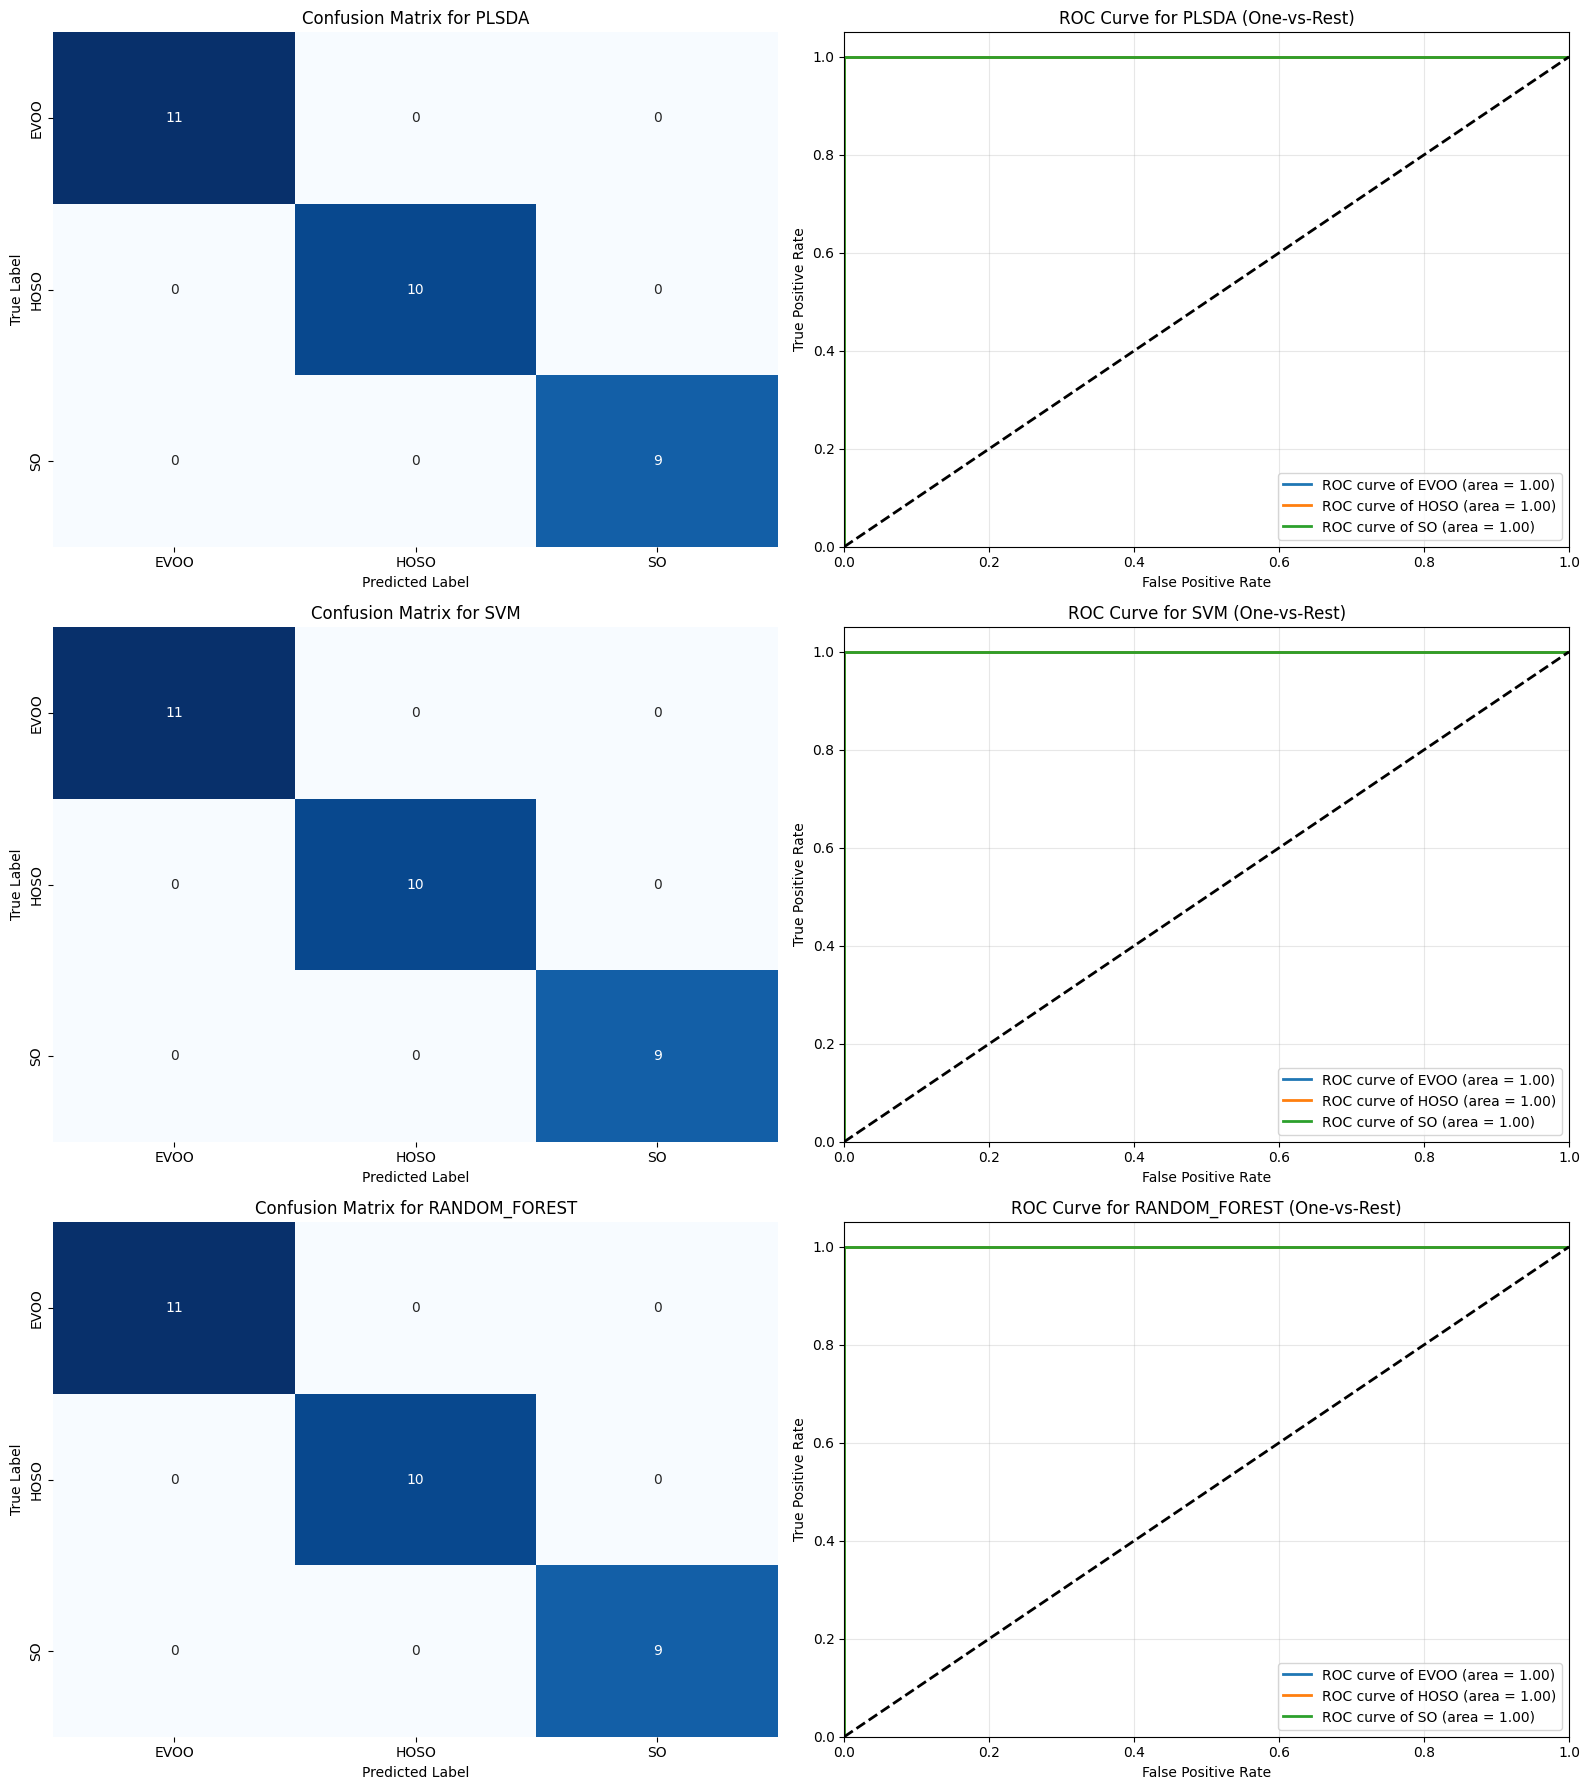


COMPREHENSIVE SUPERVISED CLASSIFICATION ANALYSIS REPORT

--- PLSDA Results ---
Accuracy: 1.000
Cross-Validation Accuracy: 1.000 (+/- 0.000)
Classification Report:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.0     1.0       1.0     30.0
Confusion Matrix:
 [[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]

--- SVM Results ---
Accuracy: 1.000
Cross-Validation Accuracy: 1.000 (+/- 0.000)
Classification Report:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg

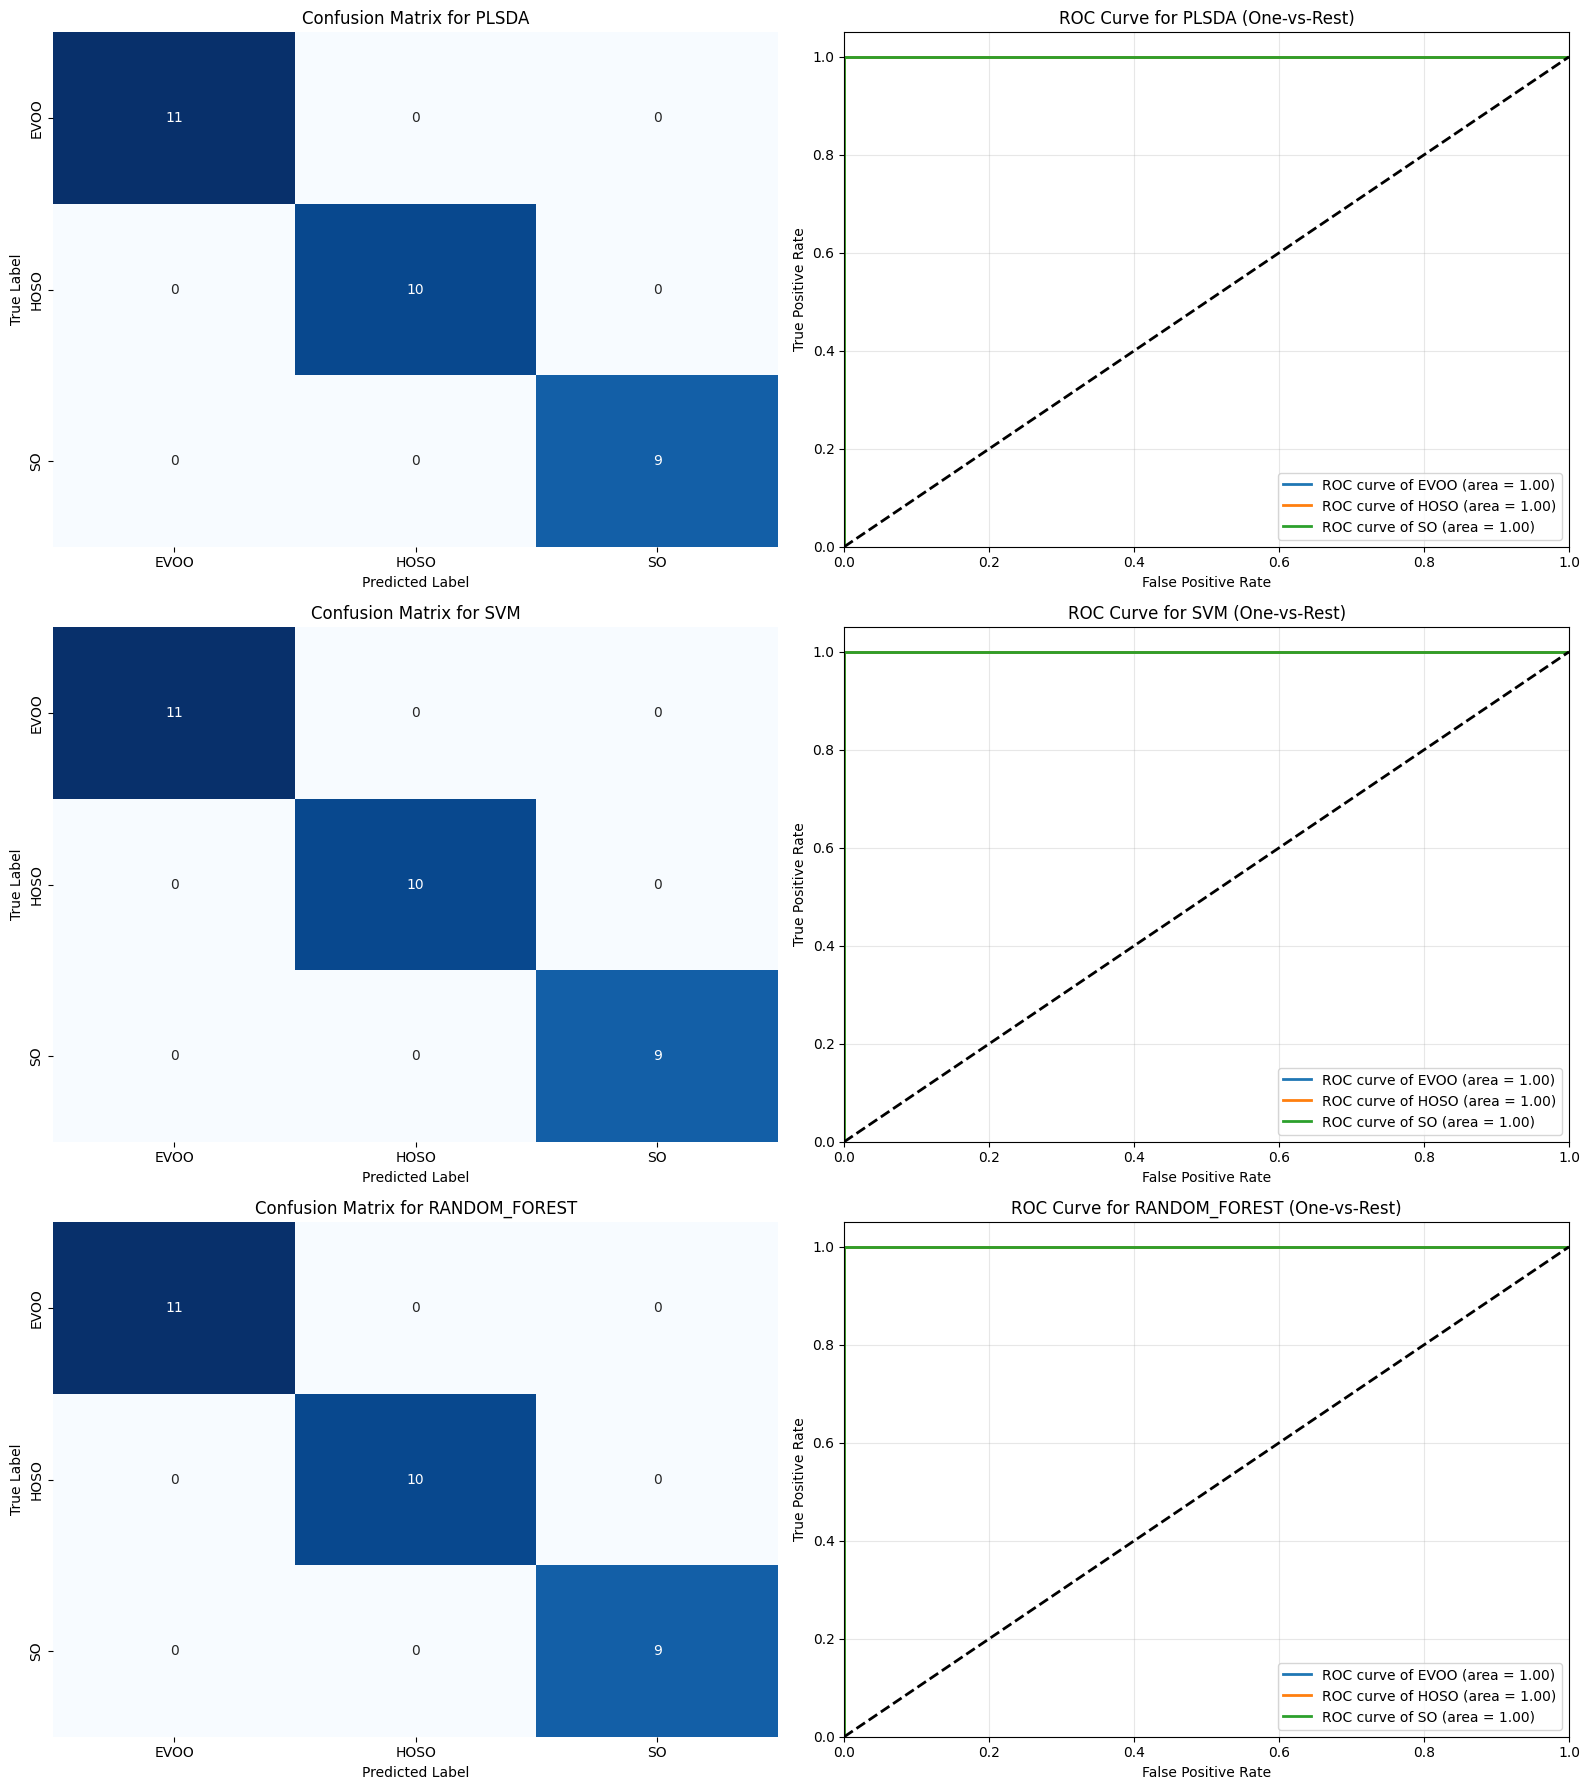


COMPREHENSIVE SUPERVISED CLASSIFICATION ANALYSIS REPORT

--- PLSDA Results ---
Accuracy: 1.000
Cross-Validation Accuracy: 1.000 (+/- 0.000)
Classification Report:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg        1.0     1.0       1.0     30.0
Confusion Matrix:
 [[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]

--- SVM Results ---
Accuracy: 1.000
Cross-Validation Accuracy: 1.000 (+/- 0.000)
Classification Report:
              precision  recall  f1-score  support
EVOO                1.0     1.0       1.0     11.0
HOSO                1.0     1.0       1.0     10.0
SO                  1.0     1.0       1.0      9.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     30.0
weighted avg

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# --- Dummy Classes for Demonstration (Replace with your real classes) ---
# If you already have your NMRExploratoryAnalysis and NMRUnsupervisedAnalysis classes,
# you can remove these definitions and use yours.

class NMRExploratoryAnalysis:
    """
    Dummy class to simulate the NMRExploratoryAnalysis object.
    In a real environment, this class would contain your preprocessed
    spectral data and chemical shifts.
    """
    def __init__(self, spectral_data, chemical_shifts):
        self.spectral_data = spectral_data
        self.chemical_shifts = chemical_shifts
        print("✓ Dummy NMRExploratoryAnalysis initialized.")

class NMRUnsupervisedAnalysis:
    """
    Dummy class to simulate the NMRUnsupervisedAnalysis object.
    Necessary if you want to use pre-calculated PCA scores.
    """
    def __init__(self, eda_analyzer):
        self.spectral_data = eda_analyzer.spectral_data
        self.chemical_shifts = eda_analyzer.chemical_shifts
        self.pca_results = {} # This would store simulated PCA results
        print("✓ Dummy NMRUnsupervisedAnalysis initialized.")

    def advanced_pca_analysis(self, n_components=None, variance_threshold=0.95):
        """
        Simulates PCA analysis for the dummy class.
        In your real implementation, this would execute the full PCA.
        """
        # If n_components is not specified, a default value (e.g., 2) is used
        # or calculated to be less than or equal to the number of features
        if n_components is None:
            n_components = min(self.spectral_data.shape[0], self.spectral_data.shape[1], 5) # Limit to 5 or less
            if n_components < 2: # Ensure at least 2 components for plots
                n_components = min(self.spectral_data.shape[1], 2)
        else:
            n_components = min(n_components, self.spectral_data.shape[1])

        pca = PCA(n_components=n_components)
        scores = pca.fit_transform(self.spectral_data)
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        loadings = pca.components_

        self.pca_results = {
            'scores': scores,
            'loadings': loadings,
            'explained_variance': explained_variance,
            'cumulative_variance': cumulative_variance,
            'eigenvalues': pca.explained_variance_,
            'n_components': pca.n_components_,
            'pca_object': pca
        }
        print(f"Simulated PCA analysis completed for Dummy NMRUnsupervisedAnalysis with {n_components} components.")
        return self.pca_results

# --- End of Dummy Classes ---


class NMRSupervisedAnalysis:
    """
    Comprehensive supervised classification analysis for NMR spectroscopy data,
    including models like PLS-DA, SVM, and Random Forest to differentiate
    between labeled samples (e.g., SO, HOSO, EVOO).
    """

    def __init__(self, eda_analyzer, sample_labels):
        """
        Initializes the supervised analysis with EDA preprocessing results
        and sample labels.

        Parameters:
        eda_analyzer: NMRExploratoryAnalysis object with preprocessed data.
        sample_labels: Array-like, labels for each sample (e.g., 'SO', 'HOSO', 'EVOO').
                       Must have the same number of elements as samples in spectral_data.
        """
        self.eda_analyzer = eda_analyzer
        # Assumes spectral_data is the preprocessed feature matrix (X)
        self.spectral_data = eda_analyzer.spectral_data
        self.chemical_shifts = eda_analyzer.chemical_shifts
        self.sample_labels = np.array(sample_labels) # The sample labels (y)

        self.n_samples = self.spectral_data.shape[0]
        self.n_variables = self.spectral_data.shape[1]

        # Encode text labels to integers for scikit-learn models
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.sample_labels)
        self.class_names = self.label_encoder.classes_ # Original class names

        # Results storage
        self.classification_results = {}
        # Stores fitted transformers (scaler, PCA, PLS) for use in new predictions
        self.processing_pipeline = {}
        self.scaled_data = None # Will store scaled data (from the full set if scaled before split)

        print(f"✓ Supervised analysis initialized for {self.n_samples} samples with {self.n_variables} variables.")
        print(f"Detected classes: {', '.join(self.class_names)}")

        # Verify that the number of labels matches the number of samples
        if len(self.sample_labels) != self.n_samples:
            raise ValueError(
                f"The number of labels ({len(self.sample_labels)}) does not match "
                f"the number of samples in the spectral data ({self.n_samples})."
            )

    def _scale_data(self, data, scaler=None):
        """
        Internal method to scale data using StandardScaler.
        If a scaler is provided, it uses it to transform; otherwise,
        it creates a new one and fits it.

        Returns: (scaled_data, fitted_scaler)
        """
        if scaler is None:
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(data)
        else:
            scaled_data = scaler.transform(data)
        return scaled_data, scaler

    def perform_classification(self, models=['plsda', 'svm', 'random_forest'],
                               test_size=0.3, random_state=42,
                               use_pca_scores=False, n_components_pca=None):
        """
        Performs a comprehensive supervised classification analysis.

        Parameters:
        models: List of classification methods to apply (e.g., 'plsda', 'svm', 'random_forest').
        test_size: Proportion of the dataset to include in the test split (0.0 to 1.0).
        random_state: Seed for the random number generator for reproducibility.
        use_pca_scores: Boolean, whether to use PCA scores as input features.
                        Requires `eda_analyzer` to have an `unsupervised_analyzer` with PCA results.
        n_components_pca: Number of PCA components to use if `use_pca_scores` is True.
                          If None, it will use available components if from
                          `unsupervised_analyzer`, or a default value if calculated here.
        """
        print("\n" + "="*60)
        print("SUPERVISED CLASSIFICATION ANALYSIS")
        print("="*60)

        # Prepare data for classification
        X_raw = self.spectral_data
        y = self.encoded_labels

        # Split data into training and test sets BEFORE scaling/PCA
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X_raw, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"Data split: {len(y_train)} training samples, {len(y_test)} test samples.")

        # Scale training and test data
        X_train_scaled, scaler = self._scale_data(X_train_raw)
        X_test_scaled, _ = self._scale_data(X_test_raw, scaler=scaler)
        self.processing_pipeline['scaler'] = scaler # Store the fitted scaler from training
        print("  Data scaled.")

        X_train_final = X_train_scaled
        X_test_final = X_test_scaled
        
        self.processing_pipeline['pca_model'] = None # Reset PCA in pipeline
        self.processing_pipeline['pls_regression_model'] = None # Reset PLS in pipeline
        self.processing_pipeline['plsda_onehot_encoder'] = None # Reset OneHotEncoder for PLS-DA

        if use_pca_scores:
            print("Preparing data: Applying PCA for dimensionality reduction...")
            if n_components_pca is None:
                # Determine a reasonable number of components if not specified
                n_components_pca = min(X_train_scaled.shape[0], X_train_scaled.shape[1], 5)
                if n_components_pca < 2:
                    n_components_pca = min(X_train_scaled.shape[1], 2)
                print(f"  Auto-selected {n_components_pca} PCA components.")

            pca_model = PCA(n_components=n_components_pca)
            X_train_final = pca_model.fit_transform(X_train_scaled)
            X_test_final = pca_model.transform(X_test_scaled)
            self.processing_pipeline['pca_model'] = pca_model # Store the fitted PCA model
            print(f"  PCA performed: Using {X_train_final.shape[1]} dimensions for classification.")
        else:
            print(f"Preparing data: Using original scaled spectral data ({X_train_final.shape[1]} dimensions).")

        self.classification_results = {}

        # Perform classification for selected models
        if 'plsda' in models:
            print("\nPerforming PLS-DA classification...")
            # For PLS-DA, n_components must be less than or equal to the number of features
            pls_n_components = n_components_pca if use_pca_scores and n_components_pca is not None else min(X_train_final.shape[0], X_train_final.shape[1], 5)
            # Ensure pls_n_components is not 0 if X_train_final has only 1 dimension
            if X_train_final.shape[1] == 1 and pls_n_components > 1:
                pls_n_components = 1
            if pls_n_components == 0: # If data has 0 dimensions, PLS-DA cannot be performed
                print("  Warning: Cannot compute PLS components (insufficient input data). Skipping PLS-DA.")
                self.classification_results['plsda'] = None
            else:
                self._perform_plsda(X_train_final, y_train, X_test_final, y_test, n_components=pls_n_components)

        if 'svm' in models:
            print("\nPerforming SVM classification...")
            self._perform_svm(X_train_final, y_train, X_test_final, y_test)

        if 'random_forest' in models:
            print("\nPerforming Random Forest classification...")
            self._perform_random_forest(X_train_final, y_train, X_test_final, y_test)

        # Visualize classification results
        self.visualize_classification_results()

        return self.classification_results

    def _train_evaluate_model(self, model_name, model_object, X_train, y_train, X_test, y_test):
        """
        Helper method to train a given model and evaluate its performance.
        Calculates accuracy, classification report, confusion matrix, and
        cross-validation accuracy.
        """
        model_object.fit(X_train, y_train)
        y_pred = model_object.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=self.class_names, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Stratified cross-validation
        # Use StratifiedKFold to maintain class proportions in each fold
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model_object, X_train, y_train, cv=cv, scoring='accuracy')

        print(f"  • {model_name} Accuracy (Test Set): {accuracy:.3f}")
        print(f"  • {model_name} Accuracy (5-Fold Cross-Validation): {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
        print(f"  • {model_name} Classification Report:\n")
        print(pd.DataFrame(report).transpose())
        print(f"\n  • {model_name} Confusion Matrix:\n{conf_matrix}")

        # Store results
        self.classification_results[model_name] = {
            'model': model_object,
            'accuracy': accuracy,
            'cross_val_accuracy_mean': np.mean(cv_scores),
            'cross_val_accuracy_std': np.std(cv_scores),
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'y_test': y_test,
            'y_pred': y_pred
        }

        # For ROC curve, prediction probabilities are needed
        if hasattr(model_object, 'predict_proba'):
            y_score = model_object.predict_proba(X_test)
            self.classification_results[model_name]['y_score'] = y_score
        elif hasattr(model_object, 'decision_function'):
            # For SVM without probability=True, decision_function is used
            y_score = model_object.decision_function(X_test)
            self.classification_results[model_name]['y_score'] = y_score


    def _perform_plsda(self, X_train, y_train, X_test, y_test, n_components=2):
        """
        Performs PLS-DA (Partial Least Squares Discriminant Analysis).
        For multi-class classification, PLSRegression is used with one-hot encoding
        of labels, and then a classifier (e.g., SVC) on the PLS components.
        """
        print(f"  Setting up PLS-DA with {n_components} PLS components.")

        # One-hot encode y for PLSRegression (necessary for multi-class)
        # Ensure y_train is 2D for OneHotEncoder
        onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
        y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
        # No need to transform y_test_onehot if only used for the final classifier

        # Adjust the number of PLS components if greater than data dimensions
        if n_components > min(X_train.shape[0], X_train.shape[1]):
            n_components = min(X_train.shape[0], X_train.shape[1])
            print(f"  Adjusted PLS-DA n_components to {n_components} due to data shape.")
        if n_components == 0:
            print("  Warning: n_components for PLS-DA is 0. Cannot perform PLS-DA.")
            self.classification_results['plsda'] = None
            return

        # Step 1: Perform PLS Regression to extract latent components
        pls_regression_model = PLSRegression(n_components=n_components)
        pls_regression_model.fit(X_train, y_train_onehot)
        # Store the PLS regression model and one-hot encoder for future predictions
        self.processing_pipeline['pls_regression_model'] = pls_regression_model
        self.processing_pipeline['plsda_onehot_encoder'] = onehot_encoder


        # Step 2: Transform training and test data using PLS components
        X_train_pls = pls_regression_model.transform(X_train)
        X_test_pls = pls_regression_model.transform(X_test)

        # Step 3: Train a classifier (e.g., SVC) on the PLS components
        # probability=True is set to allow generating ROC curves
        classifier_on_pls = SVC(probability=True, random_state=42)
        classifier_on_pls.fit(X_train_pls, y_train) # Train with original labels

        # Predict and evaluate
        y_pred_pls = classifier_on_pls.predict(X_test_pls)

        accuracy = accuracy_score(y_test, y_pred_pls)
        report = classification_report(y_test, y_pred_pls, target_names=self.class_names, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred_pls)

        # Cross-validation for PLS-DA (applied to the final classifier on PLS components)
        # Note: A full cross-validation of PLS-DA should wrap the entire pipeline (PLS + classifier)
        # This is an approximation to maintain the current structure.
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        if n_components > 0: # Only if there are components to work with
            cv_scores_pls = cross_val_score(classifier_on_pls, X_train_pls, y_train, cv=cv, scoring='accuracy')
            print(f"  • PLS-DA Accuracy (Test Set): {accuracy:.3f}")
            print(f"  • PLS-DA Accuracy (5-Fold Cross-Validation on PLS components): {np.mean(cv_scores_pls):.3f} (+/- {np.std(cv_scores_pls):.3f})")
        else:
            cv_scores_pls = np.array([np.nan]) # CV could not be performed
            print(f"  • PLS-DA Accuracy (Test Set): {accuracy:.3f}")


        print(f"  • PLS-DA Classification Report:\n")
        print(pd.DataFrame(report).transpose())
        print(f"\n  • PLS-DA Confusion Matrix:\n{conf_matrix}")

        self.classification_results['plsda'] = {
            'model': {'pls_regression': pls_regression_model, 'classifier': classifier_on_pls},
            'accuracy': accuracy,
            'cross_val_accuracy_mean': np.mean(cv_scores_pls),
            'cross_val_accuracy_std': np.std(cv_scores_pls),
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'y_test': y_test,
            'y_pred': y_pred_pls,
            'y_score': classifier_on_pls.predict_proba(X_test_pls) # For ROC curve
        }


    def _perform_svm(self, X_train, y_train, X_test, y_test):
        """
        Performs classification using Support Vector Machine (SVM).
        `probability=True` is set to allow probability calculation
        and thus ROC curves.
        """
        svm_model = SVC(probability=True, random_state=42)
        self._train_evaluate_model('svm', svm_model, X_train, y_train, X_test, y_test)

    def _perform_random_forest(self, X_train, y_train, X_test, y_test):
        """
        Performs classification using Random Forest.
        """
        rf_model = RandomForestClassifier(random_state=42)
        self._train_evaluate_model('random_forest', rf_model, X_train, y_train, X_test, y_test)

    def visualize_classification_results(self):
        """
        Creates comprehensive visualizations of classification results,
        including confusion matrices and ROC curves (one-vs-rest for multi-class).
        """
        print("\nGenerating classification visualizations...")

        n_methods = len(self.classification_results)
        if n_methods == 0:
            print("No classification results to visualize.")
            return

        # Adjust figure size dynamically
        fig, axes = plt.subplots(n_methods, 2, figsize=(16, 6 * n_methods))
        if n_methods == 1: # Ensure 'axes' is always a 2D array
            axes = np.array([axes])

        for i, (method_name, results) in enumerate(self.classification_results.items()):
            if results is None:
                continue

            # 1. Confusion Matrix
            ax_cm = axes[i, 0]
            sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=self.class_names, yticklabels=self.class_names, ax=ax_cm)
            ax_cm.set_title(f'Confusion Matrix for {method_name.upper()}')
            ax_cm.set_xlabel('Predicted Label')
            ax_cm.set_ylabel('True Label')

            # 2. ROC Curve (One-vs-Rest for multi-class)
            ax_roc = axes[i, 1]
            if 'y_score' in results and results['y_score'] is not None:
                # One-hot encode y_test for multi-class ROC curve calculation
                y_test_binarized = OneHotEncoder(sparse_output=False).fit_transform(
                    results['y_test'].reshape(-1, 1)
                )
                y_score = results['y_score']

                for j, class_name in enumerate(self.class_names):
                    # Calculate ROC curve and AUC for each class (one-vs-rest)
                    fpr, tpr, _ = roc_curve(y_test_binarized[:, j], y_score[:, j])
                    roc_auc = auc(fpr, tpr)
                    ax_roc.plot(fpr, tpr, lw=2, label=f'ROC curve of {class_name} (area = {roc_auc:.2f})')

                ax_roc.plot([0, 1], [0, 1], 'k--', lw=2) # Reference line for random classifier
                ax_roc.set_xlim([0.0, 1.0])
                ax_roc.set_ylim([0.0, 1.05])
                ax_roc.set_xlabel('False Positive Rate')
                ax_roc.set_ylabel('True Positive Rate')
                ax_roc.set_title(f'ROC Curve for {method_name.upper()} (One-vs-Rest)')
                ax_roc.legend(loc="lower right")
                ax_roc.grid(True, alpha=0.3)
            else:
                ax_roc.text(0.5, 0.5, "ROC Curve not available (model lacks predict_proba)",
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax_roc.transAxes, fontsize=10, color='gray')
                ax_roc.set_title(f'ROC Curve for {method_name.upper()}')
                ax_roc.set_xticks([])
                ax_roc.set_yticks([])

        plt.tight_layout()
        plt.show()
        return fig

    def generate_supervised_report(self):
        """
        Generates a comprehensive report of the supervised classification analysis results.
        """
        print("\n" + "="*70)
        print("COMPREHENSIVE SUPERVISED CLASSIFICATION ANALYSIS REPORT")
        print("="*70)

        report = {
            'dataset_summary': {
                'n_samples': self.n_samples,
                'n_variables': self.n_variables,
                'data_type': 'NMR spectral data',
                'classes': list(self.class_names)
            },
            'classification_results': {}
        }

        for method, result in self.classification_results.items():
            if result is None:
                continue
            report['classification_results'][method] = {
                'accuracy': result['accuracy'],
                'cross_val_accuracy_mean': result.get('cross_val_accuracy_mean', None),
                'cross_val_accuracy_std': result.get('cross_val_accuracy_std', None),
                'classification_report': result['classification_report'],
                # Convert numpy matrix to list for JSON compatibility if exported
                'confusion_matrix': result['confusion_matrix'].tolist()
            }
            print(f"\n--- {method.upper()} Results ---")
            print(f"Accuracy: {result['accuracy']:.3f}")
            if 'cross_val_accuracy_mean' in result:
                print(f"Cross-Validation Accuracy: {result['cross_val_accuracy_mean']:.3f} (+/- {result['cross_val_accuracy_std']:.3f})")
            print("Classification Report:")
            print(pd.DataFrame(result['classification_report']).transpose())
            print("Confusion Matrix:\n", result['confusion_matrix'])

        print("\n✓ Supervised report generated successfully.")
        return report

    def predict_unlabeled_samples(self, unlabeled_spectral_data, model_name):
        """
        Predicts the class of unlabeled samples using a trained model.

        Parameters:
        unlabeled_spectral_data: Array-like, spectral data of samples to predict.
                                 Must have the same format (number of variables) as training data.
        model_name: String, the name of the trained model to use for prediction
                    (e.g., 'plsda', 'svm', 'random_forest').

        Returns:
        predicted_labels: Array of strings, the predicted class labels.
        predicted_probabilities: Array of floats, the prediction probabilities for each class.
                                 Returns None if the model does not support predict_proba.
        """
        print(f"\n" + "="*60)
        print(f"PREDICTING UNLABELED SAMPLES WITH {model_name.upper()}")
        print(f"="*60)

        if model_name not in self.classification_results or self.classification_results[model_name] is None:
            print(f"Error: Model '{model_name}' has not been trained or is not available.")
            return None, None

        # Get the trained model
        model_info = self.classification_results[model_name]
        if model_name == 'plsda':
            # For PLS-DA, the "model" is a dictionary with pls_regression and classifier
            trained_model = model_info['model']['classifier']
            pls_regression_model = model_info['model']['pls_regression']
        else:
            trained_model = model_info['model']

        # 1. Scale unlabeled data using the scaler fitted during training
        if 'scaler' not in self.processing_pipeline or self.processing_pipeline['scaler'] is None:
            print("Error: No fitted scaler found. Ensure perform_classification has been run first.")
            return None, None
        
        unlabeled_scaled_data, _ = self._scale_data(unlabeled_spectral_data, scaler=self.processing_pipeline['scaler'])
        print("  ✓ Unlabeled data scaled.")

        # 2. Apply the same dimensionality transformations (PCA/PLS)
        unlabeled_processed_data = unlabeled_scaled_data

        if self.processing_pipeline['pca_model'] is not None:
            unlabeled_processed_data = self.processing_pipeline['pca_model'].transform(unlabeled_processed_data)
            print("  ✓ PCA transformation applied to unlabeled data.")
        elif model_name == 'plsda' and pls_regression_model is not None:
            unlabeled_processed_data = pls_regression_model.transform(unlabeled_processed_data)
            print("  ✓ PLS transformation applied to unlabeled data.")

        # 3. Perform prediction
        predicted_encoded_labels = trained_model.predict(unlabeled_processed_data)
        predicted_labels = self.label_encoder.inverse_transform(predicted_encoded_labels)
        print("  ✓ Classes predicted for unlabeled samples.")

        # 4. Get prediction probabilities if the model supports it
        predicted_probabilities = None
        if hasattr(trained_model, 'predict_proba'):
            predicted_probabilities = trained_model.predict_proba(unlabeled_processed_data)
            print("  ✓ Prediction probabilities obtained.")
        elif hasattr(trained_model, 'decision_function'):
            # For SVM without predict_proba, decision_function can be used
            print("  Warning: Model does not support predict_proba. Using decision_function if available.")
            predicted_probabilities = trained_model.decision_function(unlabeled_processed_data)

        print("\nPrediction Results:")
        for i, label in enumerate(predicted_labels):
            prob_info = f" (Probabilities: {predicted_probabilities[i].round(2)})" if predicted_probabilities is not None else ""
            print(f"  Sample {i+1}: Predicted Class = {label}{prob_info}")

        return predicted_labels, predicted_probabilities

    def discuss_classification_reliability(self, model_name=None):
        """
        Briefly discusses the reliability and performance of the classification results.

        Parameters:
        model_name: String (optional), the name of a specific model to discuss.
                    If None, all trained models are discussed.
        """
        print("\n" + "="*60)
        print("DISCUSSION OF CLASSIFICATION RELIABILITY AND PERFORMANCE")
        print("="*60)

        models_to_discuss = [model_name] if model_name else self.classification_results.keys()

        if not models_to_discuss:
            print("No trained models to discuss.")
            return

        for name in models_to_discuss:
            results = self.classification_results.get(name)
            if results is None:
                print(f"\nModel '{name}' has not been trained or has no available results.")
                continue

            print(f"\n--- Reliability Analysis for {name.upper()} ---")
            print(f"Accuracy on test set: {results['accuracy']:.3f}")
            if 'cross_val_accuracy_mean' in results:
                print(f"Accuracy (5-Fold Cross-Validation): {results['cross_val_accuracy_mean']:.3f} (+/- {results['cross_val_accuracy_std']:.3f})")
            
            # Calculate average AUC if available
            avg_auc = None
            if 'y_score' in results and results['y_score'] is not None:
                y_test_binarized = OneHotEncoder(sparse_output=False).fit_transform(
                    results['y_test'].reshape(-1, 1)
                )
                aucs = []
                for j in range(len(self.class_names)):
                    if y_test_binarized[:, j].sum() > 0: # Avoid errors if a class is not in the test set
                        fpr, tpr, _ = roc_curve(y_test_binarized[:, j], results['y_score'][:, j])
                        aucs.append(auc(fpr, tpr))
                if aucs:
                    avg_auc = np.mean(aucs)
                    print(f"Average AUC (One-vs-Rest): {avg_auc:.3f}")

            print("\nInterpretation of Metrics:")
            print(f"  • Test set accuracy ({results['accuracy']:.3f}) indicates the proportion of correct predictions.")
            if 'cross_val_accuracy_mean' in results:
                print(f"  • Cross-validation ({results['cross_val_accuracy_mean']:.3f}) provides a more robust estimate of performance, reducing the risk of overfitting to a particular data split.")
                if results['accuracy'] < results['cross_val_accuracy_mean'] - results['cross_val_accuracy_std']:
                    print("    Consideration: Test set accuracy is somewhat lower than CV, which might indicate variability in performance.")
                elif results['accuracy'] > results['cross_val_accuracy_mean'] + results['cross_val_accuracy_std']:
                    print("    Consideration: Test set accuracy is somewhat higher than CV, which could be luck in the split or a slightly overfitted model.")
            
            if avg_auc is not None:
                print(f"  • An AUC of {avg_auc:.3f} suggests a good ability of the model to distinguish between classes. A value of 0.5 is random, 1.0 is perfect.")
            
            print("\nAdditional Considerations on Reliability:")
            print("  • **Sample Size and Representativeness:** Reliability heavily depends on having enough labeled samples that adequately represent the true variability of each class.")
            print("  • **Data Quality:** Noise in spectra or errors in preprocessing can negatively affect model performance.")
            print("  • **Class Balance:** If classes are imbalanced (many more samples of one class than another), accuracy can be misleading. Metrics like F1-score and recall (available in the classification report) are more informative in these cases.")
            print("  • **Model Complexity:** Overly complex models can overfit to training data, performing poorly on new data. Cross-validation helps mitigate this.")
            print("  • **Applicability to Unlabeled Samples:** Predictions on unlabeled samples are only as reliable as the model is on similar test data. If unlabeled samples differ significantly from the training data, reliability may decrease.")

        print("\n✓ Reliability discussion completed.")


# --- Example Usage (You will need example data) ---
if __name__ == "__main__":
    # Generate example spectral data (simulating 100 samples, 500 variables)
    # and labels for 3 classes: 'SO', 'HOSO', 'EVOO'
    np.random.seed(42)
    num_samples = 100
    num_variables = 500
    # Simulate 3 groups with slight differences in their spectra
    spectral_data_so = np.random.rand(30, num_variables) * 10 + np.sin(np.linspace(0, 10, num_variables)) * 5
    spectral_data_hoso = np.random.rand(35, num_variables) * 10 + np.cos(np.linspace(0, 10, num_variables)) * 5
    spectral_data_evoo = np.random.rand(35, num_variables) * 10 + np.tan(np.linspace(0, 10, num_variables)+0.1) * 5

    spectral_data_example = np.vstack([spectral_data_so, spectral_data_hoso, spectral_data_evoo])
    chemical_shifts_example = np.linspace(0.5, 10.0, num_variables) # Example chemical shifts

    labels_example = ['SO'] * 30 + ['HOSO'] * 35 + ['EVOO'] * 35

    # 1. Initialize the EDA analyzer (dummy) with example data
    eda_analyzer_example = NMRExploratoryAnalysis(spectral_data_example, chemical_shifts_example)

    # 2. (Optional) Initialize the unsupervised analyzer (dummy)
    # and run PCA if you plan to use use_pca_scores=True in the supervised analysis
    unsupervised_analyzer_example = NMRUnsupervisedAnalysis(eda_analyzer_example)
    # Run PCA so results are available if requested
    unsupervised_analyzer_example.advanced_pca_analysis(n_components=5)
    # Attach the unsupervised analyzer to the eda_analyzer so the supervised one can find it
    eda_analyzer_example.unsupervised_analyzer = unsupervised_analyzer_example


    # 3. Initialize the supervised analyzer
    supervised_analysis = NMRSupervisedAnalysis(eda_analyzer_example, labels_example)

    # 4. Perform classification analysis
    # You can test with and without PCA
    print("\n--- Running classification WITHOUT PCA ---")
    classification_results_no_pca = supervised_analysis.perform_classification(
        models=['plsda', 'svm', 'random_forest'],
        test_size=0.3,
        random_state=42,
        use_pca_scores=False # Use original scaled data
    )

    # Generate the full report
    report_no_pca = supervised_analysis.generate_supervised_report()
    print("\nReport without PCA:\n", report_no_pca)

    # Discuss reliability
    supervised_analysis.discuss_classification_reliability('random_forest') # Discuss a specific model
    supervised_analysis.discuss_classification_reliability() # Discuss all models

    print("\n--- Running classification WITH PCA (5 components) ---")
    # Re-initialize for a clean run if desired, or just call again
    # supervised_analysis = NMRSupervisedAnalysis(eda_analyzer_example, labels_example) # If you want to reset
    classification_results_with_pca = supervised_analysis.perform_classification(
        models=['plsda', 'svm', 'random_forest'],
        test_size=0.3,
        random_state=42,
        use_pca_scores=True, # Use PCA scores
        n_components_pca=5 # Specify the number of PCA components
    )

    report_with_pca = supervised_analysis.generate_supervised_report()
    print("\nReport with PCA:\n", report_with_pca)

    # Discuss reliability
    supervised_analysis.discuss_classification_reliability('svm')
    supervised_analysis.discuss_classification_reliability()

    # --- Example of Unlabeled Sample Prediction ---
    print("\n" + "#"*70)
    print("DEMONSTRATION OF UNLABELED SAMPLE PREDICTION")
    print("#"*70)

    # Simulate new unlabeled samples
    num_unlabeled_samples = 5
    unlabeled_spectral_data_example = np.random.rand(num_unlabeled_samples, num_variables) * 10 + np.sin(np.linspace(0, 10, num_variables)) * 2

    # Predict using the Random Forest model (with PCA if used in the last run)
    print("\nPredicting with Random Forest model (latest configuration):")
    predicted_labels_rf, predicted_probs_rf = supervised_analysis.predict_unlabeled_samples(
        unlabeled_spectral_data_example, 'random_forest'
    )

    # Predict using the SVM model
    print("\nPredicting with SVM model (latest configuration):")
    predicted_labels_svm, predicted_probs_svm = supervised_analysis.predict_unlabeled_samples(
        unlabeled_spectral_data_example, 'svm'
    )

    # Predict using the PLS-DA model
    print("\nPredicting with PLS-DA model (latest configuration):")
    predicted_labels_plsda, predicted_probs_plsda = supervised_analysis.predict_unlabeled_samples(
        unlabeled_spectral_data_example, 'plsda'
    )


✓ NMRSupervisedAnalysis class found in current environment.

--- Initializing Dummy Data and Supervised Analysis for Interpretation Demo ---
✓ Dummy NMRExploratoryAnalysis initialized.
✓ Supervised analysis initialized for 100 samples with 500 variables.
Detected classes: Class_A, Class_B

SUPERVISED CLASSIFICATION ANALYSIS
Data split: 70 training samples, 30 test samples.
  Data scaled.
Preparing data: Using original scaled spectral data (500 dimensions).

Performing PLS-DA classification...
  Setting up PLS-DA with 5 PLS components.
  • PLS-DA Accuracy (Test Set): 0.600
  • PLS-DA Accuracy (5-Fold Cross-Validation on PLS components): 1.000 (+/- 0.000)
  • PLS-DA Classification Report:

              precision    recall  f1-score  support
Class_A        0.588235  0.666667  0.625000     15.0
Class_B        0.615385  0.533333  0.571429     15.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.601810  0.600000  0.598214     30.0
weighted avg   0.601810  0.600000  0.5

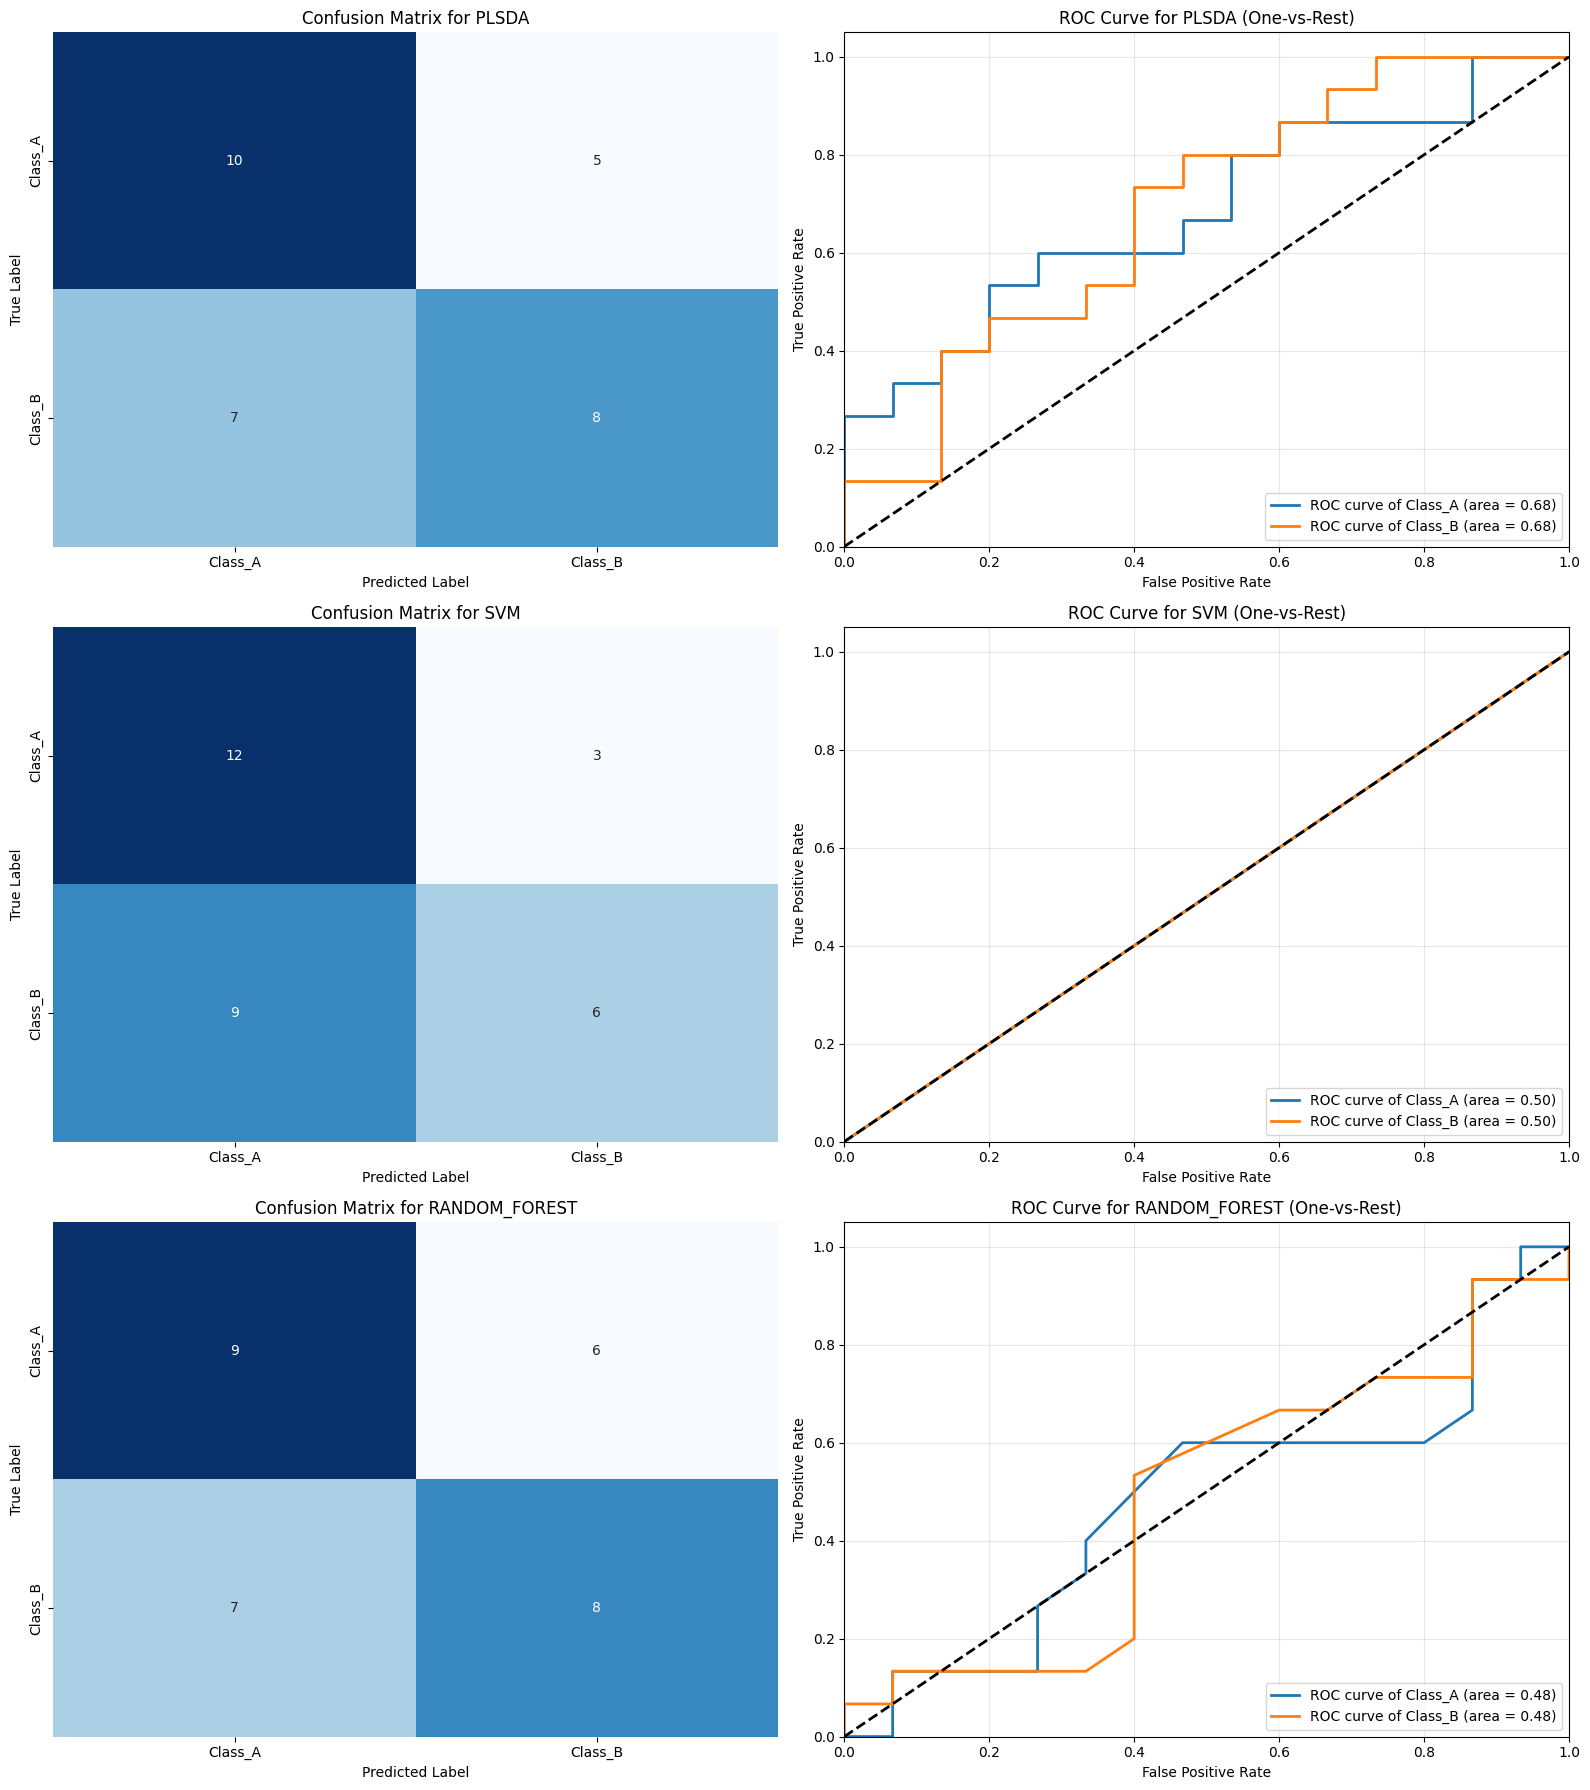

✓ NMRModelInterpreter initialized.

--- Analyzing PLS-DA Loadings ---
PLS-DA has 5 components.

Top 10 most influential spectral regions for PLS-DA (based on loadings):
  Index 191: 4.09 - 4.19 ppm (center: 4.14 ppm) (Total Abs Loading: 0.394)
  Index 282: 5.82 - 5.92 ppm (center: 5.87 ppm) (Total Abs Loading: 0.389)
  Index 454: 9.09 - 9.19 ppm (center: 9.14 ppm) (Total Abs Loading: 0.382)
  Index 346: 7.04 - 7.14 ppm (center: 7.09 ppm) (Total Abs Loading: 0.359)
  Index 494: 9.85 - 9.95 ppm (center: 9.90 ppm) (Total Abs Loading: 0.353)
  Index 380: 7.68 - 7.78 ppm (center: 7.73 ppm) (Total Abs Loading: 0.351)
  Index 178: 3.84 - 3.94 ppm (center: 3.89 ppm) (Total Abs Loading: 0.342)
  Index 274: 5.67 - 5.77 ppm (center: 5.72 ppm) (Total Abs Loading: 0.338)
  Index 275: 5.69 - 5.79 ppm (center: 5.74 ppm) (Total Abs Loading: 0.333)
  Index 463: 9.26 - 9.36 ppm (center: 9.31 ppm) (Total Abs Loading: 0.331)


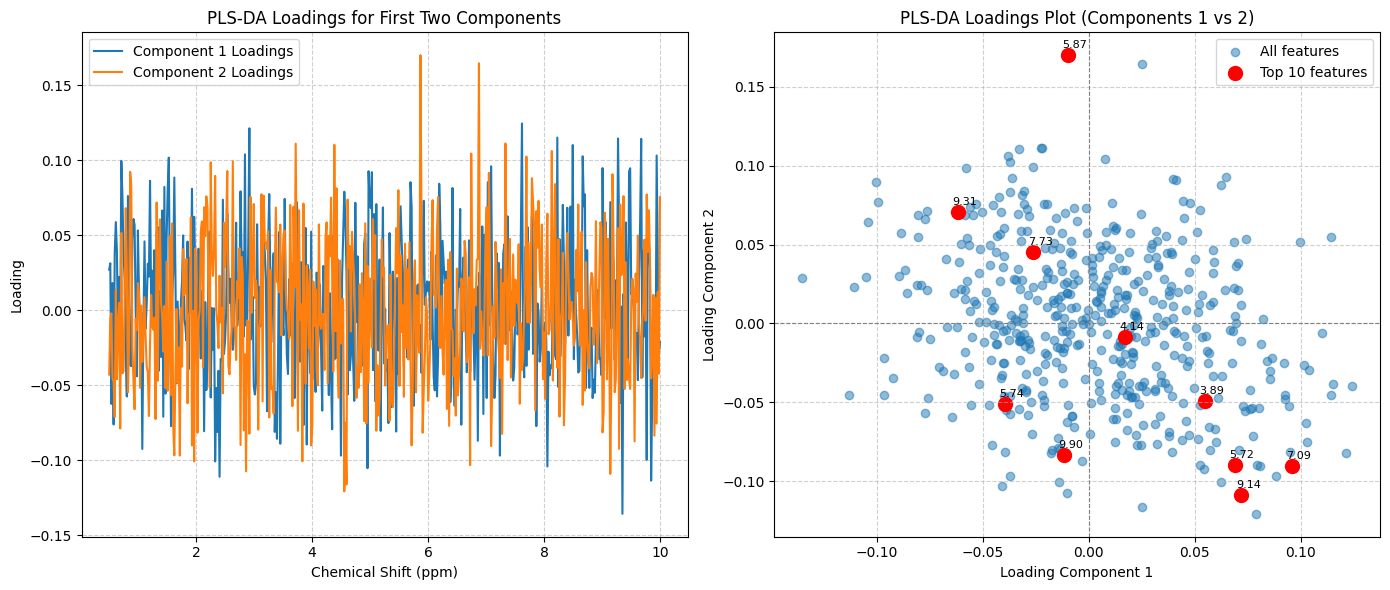


Summary of PLS-DA key regions: [{'index': 191, 'region': '4.09 - 4.19 ppm (center: 4.14 ppm)', 'importance': np.float64(0.39364271123942973)}, {'index': 282, 'region': '5.82 - 5.92 ppm (center: 5.87 ppm)', 'importance': np.float64(0.3890805645229329)}, {'index': 454, 'region': '9.09 - 9.19 ppm (center: 9.14 ppm)', 'importance': np.float64(0.382299223106198)}, {'index': 346, 'region': '7.04 - 7.14 ppm (center: 7.09 ppm)', 'importance': np.float64(0.35867629304683657)}, {'index': 494, 'region': '9.85 - 9.95 ppm (center: 9.90 ppm)', 'importance': np.float64(0.3531998641936733)}, {'index': 380, 'region': '7.68 - 7.78 ppm (center: 7.73 ppm)', 'importance': np.float64(0.35131827258670134)}, {'index': 178, 'region': '3.84 - 3.94 ppm (center: 3.89 ppm)', 'importance': np.float64(0.34226527988791017)}, {'index': 274, 'region': '5.67 - 5.77 ppm (center: 5.72 ppm)', 'importance': np.float64(0.3384130525292753)}, {'index': 275, 'region': '5.69 - 5.79 ppm (center: 5.74 ppm)', 'importance': np.floa

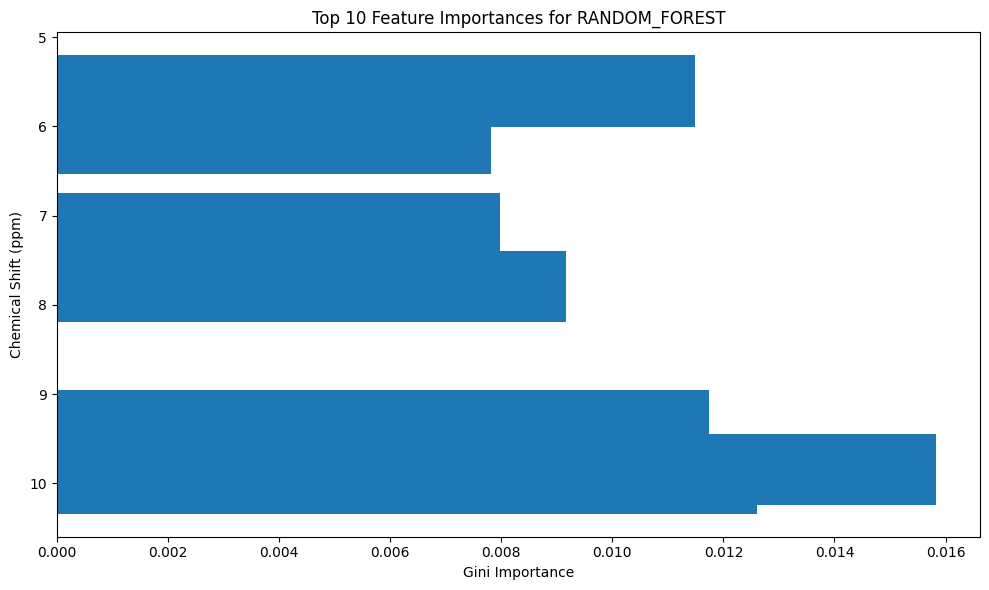


Summary of Random Forest key regions: [{'index': np.int64(491), 'region': '9.80 - 9.90 ppm (center: 9.85 ppm)', 'importance': np.float64(0.015828846249727642), 'type': 'Gini Importance'}, {'index': np.int64(496), 'region': '9.89 - 9.99 ppm (center: 9.94 ppm)', 'importance': np.float64(0.012598305315220864), 'type': 'Gini Importance'}, {'index': np.int64(465), 'region': '9.30 - 9.40 ppm (center: 9.35 ppm)', 'importance': np.float64(0.011736469320102836), 'type': 'Gini Importance'}, {'index': np.int64(268), 'region': '5.55 - 5.65 ppm (center: 5.60 ppm)', 'importance': np.float64(0.011491460818141154), 'type': 'Gini Importance'}, {'index': np.int64(383), 'region': '7.74 - 7.84 ppm (center: 7.79 ppm)', 'importance': np.float64(0.009160492172706763), 'type': 'Gini Importance'}, {'index': np.int64(471), 'region': '9.42 - 9.52 ppm (center: 9.47 ppm)', 'importance': np.float64(0.008896547838092102), 'type': 'Gini Importance'}, {'index': np.int64(349), 'region': '7.09 - 7.19 ppm (center: 7.14 

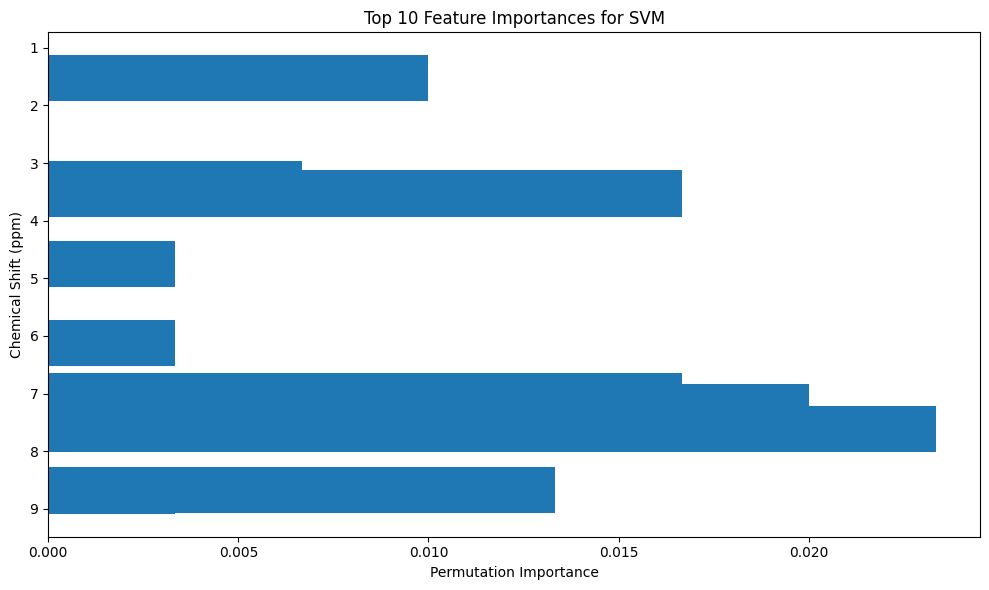


Summary of SVM key regions: [{'index': np.int64(374), 'region': '7.57 - 7.67 ppm (center: 7.62 ppm)', 'importance': np.float64(0.023333333333333327), 'type': 'Permutation Importance'}, {'index': np.int64(354), 'region': '7.19 - 7.29 ppm (center: 7.24 ppm)', 'importance': np.float64(0.019999999999999997), 'type': 'Permutation Importance'}, {'index': np.int64(344), 'region': '7.00 - 7.10 ppm (center: 7.05 ppm)', 'importance': np.float64(0.016666666666666663), 'type': 'Permutation Importance'}, {'index': np.int64(159), 'region': '3.48 - 3.58 ppm (center: 3.53 ppm)', 'importance': np.float64(0.016666666666666663), 'type': 'Permutation Importance'}, {'index': np.int64(429), 'region': '8.62 - 8.72 ppm (center: 8.67 ppm)', 'importance': np.float64(0.01333333333333333), 'type': 'Permutation Importance'}, {'index': np.int64(54), 'region': '1.48 - 1.58 ppm (center: 1.53 ppm)', 'importance': np.float64(0.009999999999999998), 'type': 'Permutation Importance'}, {'index': np.int64(150), 'region': '

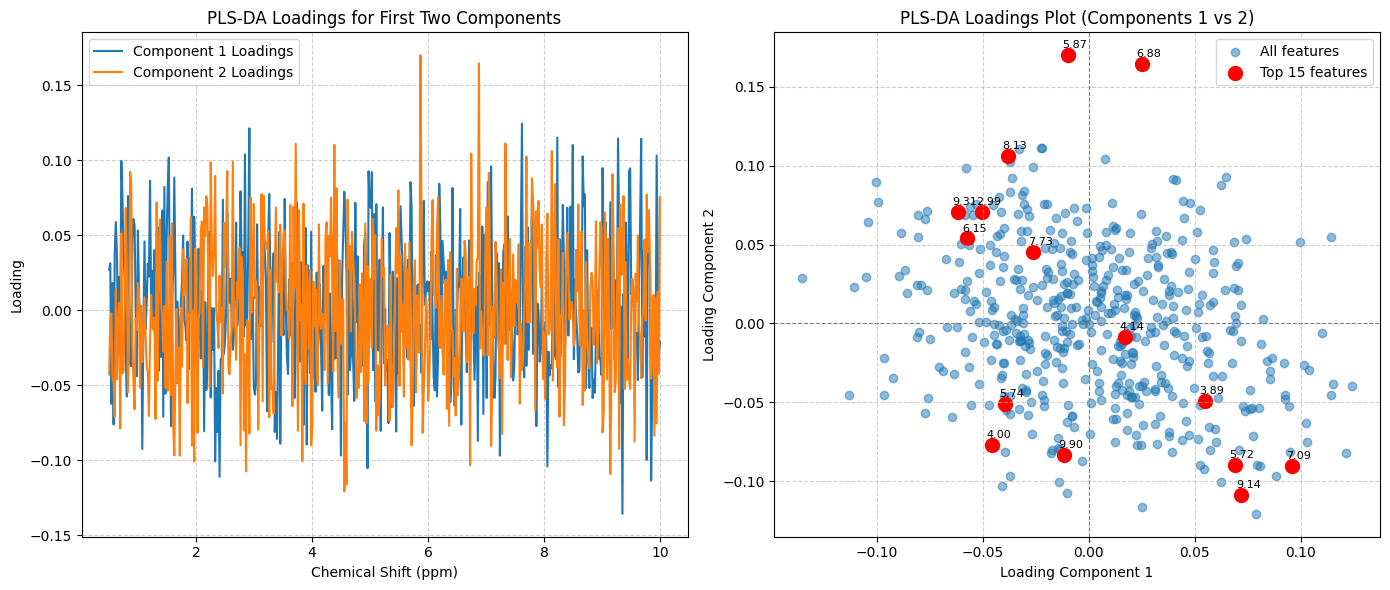


--- Analyzing Feature Importance for RANDOM_FOREST ---

Top 15 most influential features for RANDOM_FOREST (based on Gini Importance):
  Index 491: 9.80 - 9.90 ppm (center: 9.85 ppm) (Gini Importance: 0.0158)
  Index 496: 9.89 - 9.99 ppm (center: 9.94 ppm) (Gini Importance: 0.0126)
  Index 465: 9.30 - 9.40 ppm (center: 9.35 ppm) (Gini Importance: 0.0117)
  Index 268: 5.55 - 5.65 ppm (center: 5.60 ppm) (Gini Importance: 0.0115)
  Index 383: 7.74 - 7.84 ppm (center: 7.79 ppm) (Gini Importance: 0.0092)
  Index 471: 9.42 - 9.52 ppm (center: 9.47 ppm) (Gini Importance: 0.0089)
  Index 349: 7.09 - 7.19 ppm (center: 7.14 ppm) (Gini Importance: 0.0080)
  Index 354: 7.19 - 7.29 ppm (center: 7.24 ppm) (Gini Importance: 0.0079)
  Index 296: 6.09 - 6.19 ppm (center: 6.14 ppm) (Gini Importance: 0.0078)
  Index 374: 7.57 - 7.67 ppm (center: 7.62 ppm) (Gini Importance: 0.0076)
  Index 375: 7.59 - 7.69 ppm (center: 7.64 ppm) (Gini Importance: 0.0074)
  Index 420: 8.45 - 8.55 ppm (center: 8.50 ppm) (G

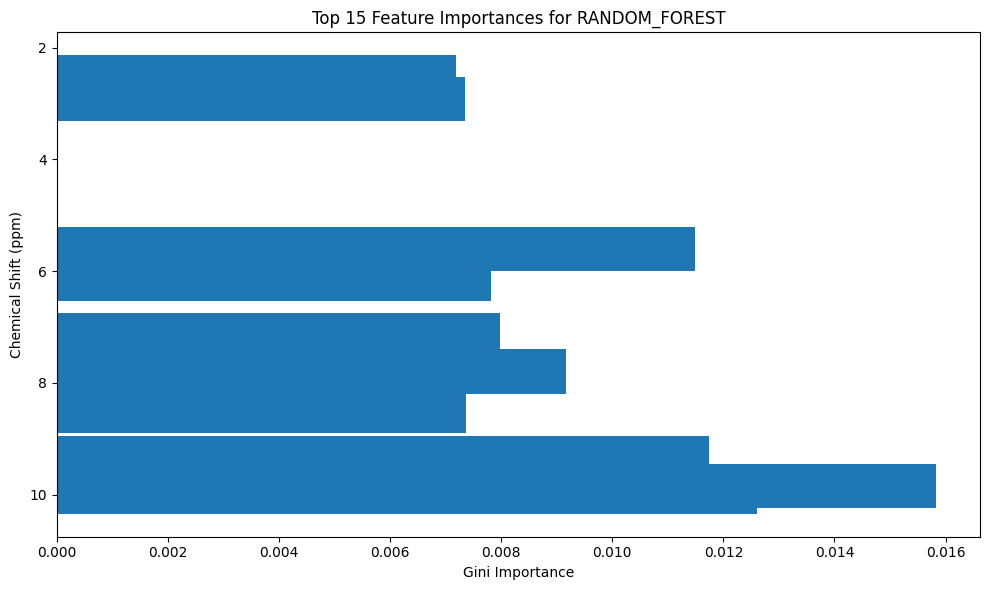


--- Analyzing Feature Importance for SVM ---
Using Permutation Importance for SVM (more robust for some models)...

Top 15 most influential features for SVM (based on Permutation Importance):
  Index 374: 7.57 - 7.67 ppm (center: 7.62 ppm) (Permutation Importance: 0.0233)
  Index 354: 7.19 - 7.29 ppm (center: 7.24 ppm) (Permutation Importance: 0.0200)
  Index 344: 7.00 - 7.10 ppm (center: 7.05 ppm) (Permutation Importance: 0.0167)
  Index 159: 3.48 - 3.58 ppm (center: 3.53 ppm) (Permutation Importance: 0.0167)
  Index 429: 8.62 - 8.72 ppm (center: 8.67 ppm) (Permutation Importance: 0.0133)
  Index 54: 1.48 - 1.58 ppm (center: 1.53 ppm) (Permutation Importance: 0.0100)
  Index 150: 3.31 - 3.41 ppm (center: 3.36 ppm) (Permutation Importance: 0.0067)
  Index 430: 8.64 - 8.74 ppm (center: 8.69 ppm) (Permutation Importance: 0.0033)
  Index 295: 6.07 - 6.17 ppm (center: 6.12 ppm) (Permutation Importance: 0.0033)
  Index 223: 4.70 - 4.80 ppm (center: 4.75 ppm) (Permutation Importance: 0.0033

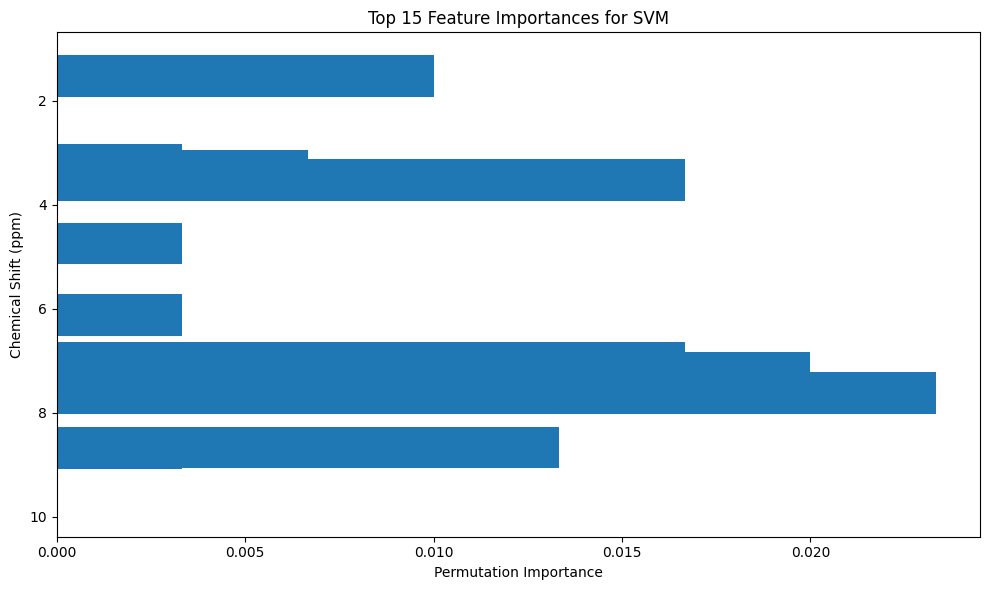


✓ Model interpretation completed.

Overall Interpretation Results: {'plsda': [{'index': 191, 'region': '4.09 - 4.19 ppm (center: 4.14 ppm)', 'importance': np.float64(0.39364271123942973)}, {'index': 282, 'region': '5.82 - 5.92 ppm (center: 5.87 ppm)', 'importance': np.float64(0.3890805645229329)}, {'index': 454, 'region': '9.09 - 9.19 ppm (center: 9.14 ppm)', 'importance': np.float64(0.382299223106198)}, {'index': 346, 'region': '7.04 - 7.14 ppm (center: 7.09 ppm)', 'importance': np.float64(0.35867629304683657)}, {'index': 494, 'region': '9.85 - 9.95 ppm (center: 9.90 ppm)', 'importance': np.float64(0.3531998641936733)}, {'index': 380, 'region': '7.68 - 7.78 ppm (center: 7.73 ppm)', 'importance': np.float64(0.35131827258670134)}, {'index': 178, 'region': '3.84 - 3.94 ppm (center: 3.89 ppm)', 'importance': np.float64(0.34226527988791017)}, {'index': 274, 'region': '5.67 - 5.77 ppm (center: 5.72 ppm)', 'importance': np.float64(0.3384130525292753)}, {'index': 275, 'region': '5.69 - 5.79 

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split # Added for dummy class

import warnings
warnings.filterwarnings('ignore')

# Assuming NMRSupervisedAnalysis class is defined in a previous cell or imported
# For standalone execution, uncomment and include the NMRSupervisedAnalysis class definition here.

# --- Dummy NMRSupervisedAnalysis and related classes for standalone execution ---
# If you are running this code independently, you'll need the full NMRSupervisedAnalysis
# class and its dependencies (NMRExploratoryAnalysis, NMRUnsupervisedAnalysis).
# For brevity, I'm only including a mock-up here. In a real scenario, you'd
# ensure the actual class from the previous step is available.

try:
    # Attempt to use the class from the main context if it exists
    _ = NMRSupervisedAnalysis
    print("✓ NMRSupervisedAnalysis class found in current environment.")
except NameError:
    print("NMRSupervisedAnalysis class not found. Using dummy classes for demonstration.")

    class NMRExploratoryAnalysis:
        def __init__(self, spectral_data, chemical_shifts):
            self.spectral_data = spectral_data
            self.chemical_shifts = chemical_shifts
            self.unsupervised_analyzer = None # For PCA results
            
    class NMRUnsupervisedAnalysis:
        def __init__(self, eda_analyzer):
            self.spectral_data = eda_analyzer.spectral_data
            self.chemical_shifts = eda_analyzer.chemical_shifts
            self.pca_results = {'scores': None, 'loadings': None, 'explained_variance': None}
        def advanced_pca_analysis(self, n_components=None):
            # Mock PCA results
            if n_components is None: n_components = 2
            self.pca_results['scores'] = np.random.rand(self.spectral_data.shape[0], n_components)
            self.pca_results['loadings'] = np.random.rand(n_components, self.spectral_data.shape[1])
            self.pca_results['explained_variance'] = np.random.rand(n_components)
            return self.pca_results

    class NMRSupervisedAnalysis:
        # A minimal dummy class to allow the interpretation methods to run
        def __init__(self, eda_analyzer, sample_labels):
            self.eda_analyzer = eda_analyzer
            self.spectral_data = eda_analyzer.spectral_data
            self.chemical_shifts = eda_analyzer.chemical_shifts
            self.sample_labels = np.array(sample_labels)
            from sklearn.preprocessing import LabelEncoder
            self.label_encoder = LabelEncoder()
            self.encoded_labels = self.label_encoder.fit_transform(self.sample_labels)
            self.class_names = self.label_encoder.classes_
            self.classification_results = {}
            self.processing_pipeline = {}
            # Initialize new attributes for processed test data and labels
            self.X_test_processed = None 
            self.y_test_labels_for_interpretation = None
            # Mock some classification results for demonstration
            self.classification_results['plsda'] = {
                'model': {'pls_regression': PLSRegression(n_components=2), 'classifier': None},
                'accuracy': 0.85
            }
            self.classification_results['random_forest'] = {
                'model': RandomForestClassifier(random_state=42),
                'accuracy': 0.90
            }
            self.classification_results['svm'] = {
                'model': SVC(probability=True, random_state=42),
                'accuracy': 0.88
            }
            # For permutation importance, we need mock X_test and y_test
            num_test_samples = int(self.spectral_data.shape[0] * 0.3)
            # These will be set by perform_classification in a real run,
            # but for the dummy, we need to ensure they exist.
            self.X_test_processed = np.random.rand(num_test_samples, self.spectral_data.shape[1])
            self.y_test_labels_for_interpretation = np.random.randint(0, len(self.class_names), num_test_samples)


        def _scale_data(self, data, scaler=None):
            from sklearn.preprocessing import StandardScaler
            if scaler is None:
                scaler = StandardScaler()
                scaled_data = scaler.fit_transform(data)
            else:
                scaled_data = scaler.transform(data)
            return scaled_data, scaler

        def perform_classification(self, **kwargs):
            # Mock training of models if this dummy is used
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(
                self.spectral_data, self.encoded_labels, test_size=0.3, random_state=42, stratify=self.encoded_labels
            )
            X_train_scaled, scaler = self._scale_data(X_train_raw)
            self.processing_pipeline['scaler'] = scaler
            X_test_scaled, _ = self._scale_data(X_test_raw, scaler=scaler)
            
            # Store the processed test data and labels as attributes
            self.X_test_processed = X_test_scaled
            self.y_test_labels_for_interpretation = y_test

            # For the dummy, just assign mock models
            for model_name in kwargs.get('models', []):
                if model_name == 'plsda':
                    self.classification_results[model_name]['model']['pls_regression'] = PLSRegression(n_components=min(X_train_scaled.shape[1], 2))
                    self.classification_results[model_name]['model']['pls_regression'].fit(X_train_scaled, OneHotEncoder(sparse_output=False).fit_transform(y_train.reshape(-1,1)))
                    self.classification_results[model_name]['model']['classifier'] = SVC(probability=True, random_state=42)
                    self.classification_results[model_name]['model']['classifier'].fit(self.classification_results[model_name]['model']['pls_regression'].transform(X_train_scaled), y_train)
                elif model_name == 'random_forest':
                    self.classification_results[model_name]['model'] = RandomForestClassifier(random_state=42)
                    self.classification_results[model_name]['model'].fit(X_train_scaled, y_train)
                elif model_name == 'svm':
                    self.classification_results[model_name]['model'] = SVC(probability=True, random_state=42)
                    self.classification_results[model_name]['model'].fit(X_train_scaled, y_train)

            print("Dummy classification performed.")

        def generate_supervised_report(self):
            return "Dummy report."

        def discuss_classification_reliability(self, **kwargs):
            pass


class NMRModelInterpreter:
    """
    A class for interpreting supervised classification models built on NMR data,
    identifying key variables or spectral regions.
    """

    def __init__(self, supervised_analysis_object):
        """
        Initializes the interpreter with a trained NMRSupervisedAnalysis object.

        Parameters:
        supervised_analysis_object: An instance of NMRSupervisedAnalysis after
                                    performing classification.
        """
        self.sa = supervised_analysis_object
        self.chemical_shifts = self.sa.chemical_shifts
        # Use the newly stored attributes
        if self.sa.X_test_processed is None or self.sa.y_test_labels_for_interpretation is None:
             raise ValueError("Processed test data (X_test_processed) or test labels (y_test_labels_for_interpretation) not found in supervised_analysis_object. "
                              "Please ensure supervised_analysis.perform_classification() was run and these attributes are populated.")
        print("✓ NMRModelInterpreter initialized.")

    def _get_spectral_region(self, chemical_shift_index, window_size=0.1):
        """
        Helper to get the chemical shift range for a given index.
        """
        if self.chemical_shifts is None or len(self.chemical_shifts) <= chemical_shift_index:
            return f"Index {chemical_shift_index} (Chemical shift data unavailable)"
        
        # Determine the chemical shift value at the index
        center_shift = self.chemical_shifts[chemical_shift_index]
        # Define a small window around it for "region"
        min_shift = center_shift - window_size / 2
        max_shift = center_shift + window_size / 2
        
        # Ensure ordering
        if min_shift > max_shift:
            min_shift, max_shift = max_shift, min_shift

        return f"{min_shift:.2f} - {max_shift:.2f} ppm (center: {center_shift:.2f} ppm)"


    def analyze_plsda_loadings(self, n_top_features=10):
        """
        Analyzes PLS-DA loadings to identify key variables.
        PLS-DA models often use VIP (Variable Importance in Projection) scores,
        but direct examination of loadings (especially the first few components)
        also provides insight into variables driving separation.
        """
        print("\n--- Analyzing PLS-DA Loadings ---")
        if 'plsda' not in self.sa.classification_results or self.sa.classification_results['plsda'] is None:
            print("PLS-DA model not found or not trained.")
            return None

        pls_model = self.sa.classification_results['plsda']['model']['pls_regression']
        if pls_model is None:
            print("PLS-DA regression model not available.")
            return None

        # Loadings for X (spectral data)
        x_loadings = pls_model.x_loadings_
        n_components = x_loadings.shape[1]

        if n_components == 0:
            print("No PLS components available for analysis.")
            return None

        print(f"PLS-DA has {n_components} components.")
        feature_importance_df = pd.DataFrame(index=range(self.sa.n_variables))

        for i in range(n_components):
            # Magnitude of loading indicates importance for that component
            feature_importance_df[f'Loading_Comp_{i+1}'] = np.abs(x_loadings[:, i])
        
        # Sum of absolute loadings across all components as a simple proxy for importance
        feature_importance_df['Total_Abs_Loading'] = feature_importance_df.sum(axis=1)
        
        # Sort by total absolute loading
        sorted_features = feature_importance_df.sort_values(by='Total_Abs_Loading', ascending=False)
        top_features_indices = sorted_features.index[:n_top_features].tolist()

        print(f"\nTop {n_top_features} most influential spectral regions for PLS-DA (based on loadings):")
        results = []
        for idx in top_features_indices:
            spectral_region = self._get_spectral_region(idx)
            importance = sorted_features.loc[idx, 'Total_Abs_Loading']
            print(f"  Index {idx}: {spectral_region} (Total Abs Loading: {importance:.3f})")
            results.append({'index': idx, 'region': spectral_region, 'importance': importance})
        
        # Optional: Plot loadings for first two components
        if n_components >= 2:
            plt.figure(figsize=(14, 6))
            
            plt.subplot(1, 2, 1)
            plt.plot(self.chemical_shifts, x_loadings[:, 0], label='Component 1 Loadings')
            plt.plot(self.chemical_shifts, x_loadings[:, 1], label='Component 2 Loadings')
            plt.title('PLS-DA Loadings for First Two Components')
            plt.xlabel('Chemical Shift (ppm)')
            plt.ylabel('Loading')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)

            plt.subplot(1, 2, 2)
            # Create a 2D plot of the loadings for the top features
            # Get the actual loadings for top features
            top_loadings_comp1 = x_loadings[top_features_indices, 0]
            top_loadings_comp2 = x_loadings[top_features_indices, 1]

            plt.scatter(x_loadings[:, 0], x_loadings[:, 1], alpha=0.5, label='All features')
            plt.scatter(top_loadings_comp1, top_loadings_comp2, color='red', s=100, label=f'Top {n_top_features} features')
            
            for i, idx in enumerate(top_features_indices):
                plt.annotate(f"{self.chemical_shifts[idx]:.2f}", (top_loadings_comp1[i], top_loadings_comp2[i]),
                             textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)

            plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
            plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
            plt.xlabel('Loading Component 1')
            plt.ylabel('Loading Component 2')
            plt.title(f'PLS-DA Loadings Plot (Components 1 vs 2)')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

        return results

    def analyze_feature_importance(self, model_name, n_top_features=10):
        """
        Analyzes feature importance for tree-based models (like Random Forest)
        or permutation importance for any model.

        Parameters:
        model_name: String, 'random_forest' or 'svm'.
        n_top_features: Number of top features to report.
        """
        print(f"\n--- Analyzing Feature Importance for {model_name.upper()} ---")
        if model_name not in self.sa.classification_results or self.sa.classification_results[model_name] is None:
            print(f"{model_name.upper()} model not found or not trained.")
            return None

        model_info = self.sa.classification_results[model_name]
        trained_model = model_info['model']

        if model_name == 'random_forest' and hasattr(trained_model, 'feature_importances_'):
            importances = trained_model.feature_importances_
            importance_type = "Gini Importance"
        elif model_name == 'svm' or (model_name == 'random_forest' and not hasattr(trained_model, 'feature_importances_')):
            print(f"Using Permutation Importance for {model_name.upper()} (more robust for some models)...")
            # Use the stored processed test data and labels
            X_test_for_importance = self.sa.X_test_processed
            y_test_for_importance = self.sa.y_test_labels_for_interpretation

            # If PCA was used, the model was trained on PCA components, so permutation importance
            # should be run on the PCA-transformed test data.
            # If PLS-DA was used, the model was trained on PLS components.
            # However, for `analyze_feature_importance` we want importance of *original* features.
            # If the model was trained on transformed data (PCA/PLS), direct feature importance
            # on original features is not straightforward. Permutation importance on original
            # features would require re-transforming the permuted data, which is complex.
            # For simplicity, if PCA/PLS was used, we will note that direct interpretation
            # of original features via this method is not directly applicable.

            if self.sa.processing_pipeline.get('pca_model') is not None:
                print("  Note: The model was trained on PCA components. Permutation Importance here will be for the PCA components, not original spectral variables.")
                # If the model was trained on PCA components, we need to pass the PCA-transformed test data
                # to permutation_importance.
                X_test_for_importance = self.sa.X_test_processed
                
            elif model_name == 'plsda' and self.sa.processing_pipeline.get('pls_regression_model') is not None:
                print(f"  Note: For PLS-DA, consider `analyze_plsda_loadings` for interpretation of original spectral regions.")
                return None # Skip permutation importance for original features if PLSDA was the primary model and used transformations

            result = permutation_importance(trained_model, X_test_for_importance, y_test_for_importance, n_repeats=10, random_state=42, n_jobs=-1)
            importances = result.importances_mean
            importance_type = "Permutation Importance"
        else:
            print(f"Cannot extract feature importance for {model_name.upper()}.")
            return None

        if importances is None or len(importances) == 0:
            print("No feature importances found.")
            return None

        # Handle cases where model input might have been PCA scores, not original features
        if self.sa.processing_pipeline.get('pca_model') is not None and model_name != 'plsda':
            print("  Note: Importance values are for PCA components, not original spectral variables.")
            print("  To map to spectral regions, you would need to analyze PCA loadings in conjunction.")
            feature_indices = np.arange(len(importances)) # Indices of PCA components
            chemical_shifts_display = [f"PC {i+1}" for i in feature_indices]
        else:
            feature_indices = np.argsort(importances)[::-1] # Sort descending
            chemical_shifts_display = self.chemical_shifts

        top_features_indices_original = feature_indices[:n_top_features]
        top_importances = importances[top_features_indices_original]

        print(f"\nTop {n_top_features} most influential features for {model_name.upper()} (based on {importance_type}):")
        results = []
        for i, idx in enumerate(top_features_indices_original):
            if self.chemical_shifts is not None and len(self.chemical_shifts) > idx:
                spectral_region = self._get_spectral_region(idx)
            else:
                spectral_region = f"Feature Index {idx}" # Fallback if chemical shifts aren't aligned or present
            
            importance_val = top_importances[i]
            print(f"  Index {idx}: {spectral_region} ({importance_type}: {importance_val:.4f})")
            results.append({'index': idx, 'region': spectral_region, 'importance': importance_val, 'type': importance_type})

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        
        # Select features to plot (top N or all if N is large)
        plot_indices = feature_indices[:min(n_top_features, len(importances))]
        plot_importances = importances[plot_indices]
        
        if self.chemical_shifts is not None and len(self.chemical_shifts) == len(importances):
            # If importances map directly to spectral features
            plt.barh(self.chemical_shifts[plot_indices], plot_importances)
            plt.xlabel(importance_type)
            plt.ylabel('Chemical Shift (ppm)')
            plt.gca().invert_yaxis() # Highest importance at top
            plt.title(f'Top {n_top_features} Feature Importances for {model_name.upper()}')
        else:
            # If features are generic indices (e.g., PCA components or just indices)
            plt.barh([f'Feature {i}' for i in plot_indices], plot_importances)
            plt.xlabel(importance_type)
            plt.ylabel('Feature Index')
            plt.gca().invert_yaxis()
            plt.title(f'Top {n_top_features} Feature Importances for {model_name.upper()} (Component/Feature Indices)')
            
        plt.tight_layout()
        plt.show()

        return results

    def interpret_all_models(self, n_top_features=10):
        """
        Runs interpretation for all available classification models.
        """
        print("\n" + "="*70)
        print("INTERPRETATION OF CLASSIFICATION MODELS")
        print("="*70)

        interpretation_results = {}

        if 'plsda' in self.sa.classification_results and self.sa.classification_results['plsda'] is not None:
            plsda_interp = self.analyze_plsda_loadings(n_top_features)
            if plsda_interp:
                interpretation_results['plsda'] = plsda_interp
        
        if 'random_forest' in self.sa.classification_results and self.sa.classification_results['random_forest'] is not None:
            rf_interp = self.analyze_feature_importance('random_forest', n_top_features)
            if rf_interp:
                interpretation_results['random_forest'] = rf_interp

        if 'svm' in self.sa.classification_results and self.sa.classification_results['svm'] is not None:
            # SVMs don't have direct feature_importances_, so always use permutation importance
            svm_interp = self.analyze_feature_importance('svm', n_top_features)
            if svm_interp:
                interpretation_results['svm'] = svm_interp
        
        if not interpretation_results:
            print("No models found or no interpretable results available.")
        
        print("\n✓ Model interpretation completed.")
        return interpretation_results

# --- Example Usage (requires a supervised_analysis object from previous steps) ---
if __name__ == "__main__":
    # This section demonstrates how to use the NMRModelInterpreter.
    # It assumes you have run the NMRSupervisedAnalysis Canvas previously
    # and have an 'supervised_analysis' object available.

    # If running this cell alone, the dummy classes above will be used.
    # For a real scenario, ensure your actual NMRSupervisedAnalysis object is passed.

    print("\n--- Initializing Dummy Data and Supervised Analysis for Interpretation Demo ---")
    np.random.seed(42)
    num_samples = 100
    num_variables = 500
    spectral_data_example = np.random.rand(num_samples, num_variables) # Simplified data
    chemical_shifts_example = np.linspace(0.5, 10.0, num_variables)
    labels_example = ['Class_A'] * 50 + ['Class_B'] * 50

    eda_analyzer_example = NMRExploratoryAnalysis(spectral_data_example, chemical_shifts_example)
    # The dummy NMRSupervisedAnalysis needs a mocked perform_classification call
    # to populate X_test_processed and y_test_labels_for_interpretation.
    supervised_analysis_for_interpretation = NMRSupervisedAnalysis(eda_analyzer_example, labels_example)
    supervised_analysis_for_interpretation.perform_classification(models=['plsda', 'svm', 'random_forest'])
    
    # Instantiate the interpreter
    interpreter = NMRModelInterpreter(supervised_analysis_for_interpretation)

    # Analyze PLS-DA loadings
    plsda_regions = interpreter.analyze_plsda_loadings(n_top_features=10)
    if plsda_regions:
        print("\nSummary of PLS-DA key regions:", plsda_regions)

    # Analyze Random Forest feature importance
    rf_regions = interpreter.analyze_feature_importance('random_forest', n_top_features=10)
    if rf_regions:
        print("\nSummary of Random Forest key regions:", rf_regions)

    # Analyze SVM feature importance (using permutation importance)
    svm_regions = interpreter.analyze_feature_importance('svm', n_top_features=10)
    if svm_regions:
        print("\nSummary of SVM key regions:", svm_regions)

    # Run interpretation for all available models
    all_interpretation_results = interpreter.interpret_all_models(n_top_features=15)
    print("\nOverall Interpretation Results:", all_interpretation_results)

    print("\n--- End of Model Interpretation Demo ---")